<h3> Dev Diary (Update time: 03/06/2022) </h3>

<h5> Study List </h5>
<ul>
    <ul>
        Theoretical Background?
        <li>
            <section> What is the theoretical foundations of thinning strategies? </section>
            <section> *When adding new thinning strategies, need to add new thinning function, update strategy_params lists. </section>
        </li>
        <section> ' </section>
        Data Structure
        <li>
            <section> Find one for Dominance Index, easy to store, load, use and save to json file. </section>
        </li>
        <section> ' </section>
        Trees' Lifetime Carbon Amount
        <li>
            <section> Why are the peak values of lifetime carbon amounts of all the species 60626.5? </section>
        </li>
    </ul>
</ul>

<h5> Optimization List </h5>
<ul>
    <ul>
        Develop silviculture plot functions
        <li> function: plot_Dominance_strategy (Dominance Index plots of the same thinning strategy) </li>
        <li> function: plot_Dominance_scenario (Dominance Index plots of the same thinning scenario) </li>
        <section> ' </section>
    </ul>
    <ul>    
        Add turn-on/turn-off functions for all multiple-scenario simulations and plottings functions.
        <li> function: mul_scenario_managements </li>
        <li> function: plot_Dominance_Matrix </li>
        <section> ' </section>
    </ul>
    <ul>    
        Decrease the inputs of functions.
        <li> function: mul_scenario_managements </li>
        <li> function: plot_Dominance_Matrix </li> 
        <section> ' </section>
    </ul>
    <ul>    
        检查thinning模拟以及carbon,bio计算方程是否出现问题
        <section> ' </section>        
    </ul>
</ul>

Thinning strategies for higher Carbon Stocks.<br>
        def highC_thinning(Trees, start_year, window=10):
        """
        Thin trees whose expected lifetime carbon stocks in the future is lower than new-planted trees..

        Parameters:
        year -- the year to cut trees
        window -- total years to calculate expected carbon stocks.
        """

        Trees.loc[:, f'Thinned{start_year}'] = 0

        # Calculate the DBH and LifetimeC in the next window year.
        expected_year = start_year + window
        Trees = compute_Diameter(Trees, start_year, expected_year)
        Trees = compute_LifetimeC(Trees, expected_year)
        # Calculate expected growth of carbon stocks in the next window year.
        Trees = compute_LifetimeCGrowth(Trees, start_year, expected_year)

        Trees.loc[:, f'Thinned{start_year}'] = Trees.loc[:, f'LifetimeCGrowth{start_year}2{expected_year}'] smaller than Trees.loc[:, f'LifetimeC_Age{window}']
        #Trees.loc[i, f'Diameter{year}'] = round(0/Trees.GrowthFactor[i], 2)

        return Trees

High B Regeneration <br>
        def highB_regeneration(Trees, year, species_list, metrics='simpson'):
        """
        Simulate all possible regeneration strategies and select the one with highest biodiversity index.

        Parameters:
        """

        # Determine what trees need to be regenerated.
        decay = Trees.loc[:, f'Decay{year}'].copy()

        # Get the list of trees' species.
        original_species = Trees.loc[:, f'TreeSpecies{year}'].copy()

        # Initialize the pandas DataFrame to store biodiversity index of all simulations.
        biodiveristy_df = pd.DataFrame(columns=['sim_index', 'metrics'])

        n_sim = 0
        while True:
            biodiversity_df.loc[n_sim, 'sim_index'] = n_sim+1

<h5> Visualization List </h5>
<ul>
    <ul>
        How to combine timber size with carbon storage amount?
        <section> ' </section>
        How to interpret the Growth Dominance Matrix?
        <li> What does the X-axis mean? </li>
        <li> What does the Y-axis mean? </li>
        <li> How to interpret the clusters? </li>
    </ul>
<ul>

<h5> Development List </h5>
<ul>
    <ul>
        Performance evaluation index
        <li> Carbon stocks </li>
        <li> Biodiversity index </li>
    </ul>
<ul>

<h1> Chapter 0. Basic Settings </h1>

<h3> 0-1. Import libraries </h3>

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import seaborn as sns
import math

from datetime import datetime
import time

import json
import files
import os 
import imageio

<h3> 0-2. Set libraries </h3>

In [144]:
pd.set_option('mode.chained_assignment', None)

<h3> 0-3. Main file paths </h3>
<ol>
    <li> Folder path and file paths of original trees' data. </li>
    <li> Folder path and file paths of trees' data after simulation. </li>
</ol>

In [145]:
def trees_species_data(category='DesignForest'):
    """
    Store the folder path and a list of file paths of design trees' file.
    """
    # Folder path indicates the location of files.
    folder_path = '/Users/chengfei/Desktop/Dataset/1-TreeSpeciesData/'
    # File prefix indicates the fundamental metadata of files.
    file_prefix = f'{category}_species_'
    # File path list includes the file indexes and names.
    file_path_list = [
        {
            'Index': 0,
            'Name': 'Parcel design Plot design'
        },{
            'Index': 1,
            'Name':'Parcel 6 Plot 4'
        },{
            'Index': 2,
            'Name': 'Parcel 6 Plot 5'
        },{
            'Index': 3,
            'Name': 'Parcel 11 Plot 1-2'
        },{
            'Index': 4,
            'Name': 'Parcel 11 Plot 2-2'
        }
    ]
    # File suffix indicates the file type.
    file_suffix = '.xlsx'
    return {
        'folder_path': folder_path,
        'file_prefix': file_prefix,
        'file_path_list': file_path_list,
        'file_suffix': file_suffix,
        'folder_file_path_list': [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(len(file_path_list))]
    }

In [146]:
def trees_combination_data(category='DesignForest', version='WithoutZero'):
    """
    Store the folder path and a list of file paths of all the combinations of tree species.
    """
    
    # Folder path indicates the location of files.
    folder_path = '/Users/chengfei/Desktop/Dataset/2-TreeCombinationData/'
    # File prefix indicates the fundamental metadata of files.
    file_prefix = f'{category}_combination_'
    # File path list includes the file indexes and names.
    file_path_list = [
        {
            'Index': 0,
            'Name': 'Parcel design Plot design'
        },{
            'Index': 1,
            'Name':'Parcel 6 Plot 4'
        },{
            'Index': 2,
            'Name': 'Parcel 6 Plot 5'
        },{
            'Index': 3,
            'Name': 'Parcel 11 Plot 1-2'
        },{
            'Index': 4,
            'Name': 'Parcel 11 Plot 2-2'
        }
    ]
    # File pre suffix indicates the file version.
    file_pre_suffix = '_' + version
    # File suffix indicates the file type.
    file_suffix = '.xlsx'
    return {
        'folder_path': folder_path,
        'file_prefix': file_prefix,
        'file_path_list': file_path_list,
        'file_pre_suffix': file_pre_suffix,
        'file_suffix': file_suffix,
        'folder_file_path_list': [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(len(file_path_list))]
    }

In [147]:
def trees_number_data(category='DesignForest', version='List'):
    """
    Store the folder path and a list of file paths of original trees' file.
    """
    # Folder path indicates the location of files.
    folder_path = '/Users/chengfei/Desktop/Dataset/3-TreeNumberData/'
    # File prefix indicates the fundamental metadata of files.
    file_prefix = f'{category}_number_'
    # File path list includes the file indexes and names.
    file_path_list = [
        {
            'Index': 1,
            'Name':'Parcel 6 Plot 4'
        },{
            'Index': 2,
            'Name': 'Parcel 6 Plot 5'
        },{
            'Index': 3,
            'Name': 'Parcel 11 Plot 1-2'
        },{
            'Index': 4,
            'Name': 'Parcel 11 Plot 2-2'
        }
    ]
    # File pre suffix indicates the file version.
    file_pre_suffix = '_'+version
    # File suffix indicates the file type.
    file_suffix = '.xlsx'
    return {
        'folder_path': folder_path,
        'file_prefix': file_prefix,
        'file_path_list': file_path_list,
        'file_suffix': file_suffix,
        'file_pre_suffix': file_pre_suffix,
        'folder_file_path_list': [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(len(file_path_list))]
    }

In [148]:
def trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y'):
    """
    Store the folder path and a list of file paths of thinned trees' file.
    """
    # Folder path indicates the location of files.
    folder_path = '/Users/chengfei/Desktop/Dataset/4-TreeThinningData/'
    # File prefix indicates the fundamental metadata of files.
    file_prefix = f'{category}_thinning_{period}_{strategy_set}_'
    # File path list includes the file indexes and names.
    file_path_list = [
        {
            'Index': 1,
            'Name':'Parcel 6 Plot 4'
        },{
            'Index': 2,
            'Name': 'Parcel 6 Plot 5'
        },{
            'Index': 3,
            'Name': 'Parcel 11 Plot 1-2'
        },{
            'Index': 4,
            'Name': 'Parcel 11 Plot 2-2'
        }
    ]
    # File suffix indicates the file type.
    file_suffix = '.xlsx'
    return {
        'folder_path': folder_path,
        'file_prefix': file_prefix,
        'file_path_list': file_path_list,
        'file_suffix': file_suffix,
        'folder_file_path_list': [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(len(file_path_list))]
    }

In [149]:
def trees_combination_plot(category='DesignForest', design_name='Design1', bio_index='simpson'):
    """
    Store the folder path and a list of file paths of Octopus plots of all combinations of tree species.
    """
    
    # Folder path indicates the location of files.
    folder_path = '/Users/chengfei/Desktop/Drawing/2-TreeCombinationPlot/'
    # File prefix indicates the fundamental metadata of files.
    file_prefix = f'{category}_combination_'
    # File path list includes the file indexes and names.
    file_path_list = [
        {
            'Index': 1,
            'Name':'Parcel 6 Plot 4'
        },{
            'Index': 2,
            'Name': 'Parcel 6 Plot 5'
        },{
            'Index': 3,
            'Name': 'Parcel 11 Plot 1-2'
        },{
            'Index': 4,
            'Name': 'Parcel 11 Plot 2-2'
        }
    ]
    # File pre suffix indicates the different combination types.
    file_pre_suffix = f'_{design_name}_{bio_index}'
    # File suffix indicates the file type.
    file_suffix = '.pdf'
    return {
        'folder_path': folder_path,
        'file_prefix': file_prefix,
        'file_path_list': file_path_list,
        'file_pre_suffix': file_pre_suffix,
        'file_suffix': file_suffix,
        'folder_file_path_list': [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(len(file_path_list))]
    }

In [150]:
def trees_mul_combination_plot(category='DesignForest', bio_index='simpson'):
    """
    Store the folder path and a list of file paths of Octopus plots of all combinations of tree species.
    """
    
    # Folder path indicates the location of files.
    folder_path = '/Users/chengfei/Desktop/Drawing/2-TreeCombinationPlot/'
    # File prefix indicates the fundamental metadata of files.
    file_prefix = f'{category}_mul_combination_'
    # File path list includes the file indexes and names.
    file_path_list = [
        {
            'Index': 1,
            'Name':'Parcel 6 Plot 4'
        },{
            'Index': 2,
            'Name': 'Parcel 6 Plot 5'
        },{
            'Index': 3,
            'Name': 'Parcel 11 Plot 1-2'
        },{
            'Index': 4,
            'Name': 'Parcel 11 Plot 2-2'
        }
    ]
    # File pre suffix indicates the different combination types.
    file_pre_suffix = f'_{bio_index}'
    # File suffix indicates the file type.
    file_suffix = '.pdf'
    return {
        'folder_path': folder_path,
        'file_prefix': file_prefix,
        'file_path_list': file_path_list,
        'file_pre_suffix': file_pre_suffix,
        'file_suffix': file_suffix,
        'folder_file_path_list': [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(len(file_path_list))]
    }

<h3> @0-4. Upload files </h3>
<ol>
    <li> Load trees' dataframe (The sample stands). </li>
    <li> Upload an excel file with multiple sheets into a dictionary of multiple DataFrames (Thinned trees' data). </li>
    <li> Upload an excel file with multiple sheets into a dictionary of multiple DataFrames (Data of All the Combinations of Trees Species). </li>
</ol>

In [151]:
# tree_df is a pandas dataframe containing data of tree species, condition, growth factor, diameter2021, age2021.
# tree_df = pd.read_excel(trees_number_data(category='ExistingForest')['folder_file_path_list'][0])

In [152]:
def upload_thinned_trees_DataFrames(folder_path=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['folder_path'], 
                                    file_prefix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_prefix'], 
                                    file_path_list=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_path_list'],
                                    file_suffix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_suffix']):
    """
    Upload multiple-sheets excels from local folders.
    """
    
    # Get the file paths of trees' data.
    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(len(file_path_list))]
    
    TREES_INDEX_ALL = {}
    for i in range(len(folder_file_path_list)):
        folder_file_path = folder_file_path_list[i]
        file_path = file_path_list[i]['Name']
        xls = pd.ExcelFile(folder_file_path)        
        TREES_INDEX = {}
        TREES = {}
        for sheet_name in xls.sheet_names:
            if sheet_name in ['DOMINANCE', 'CDOMINANCE', 'CARBON', 'SHANNON', 'SIMPSON']:
                TREES_INDEX[sheet_name] = pd.read_excel(xls, sheet_name)
            else:
                TREES[sheet_name] = pd.read_excel(xls, sheet_name)
        TREES_INDEX['TREES'] = TREES        
        TREES_INDEX_ALL[file_path] = TREES_INDEX
        
    return TREES_INDEX_ALL

In [153]:
def upload_trees_combination_DataFrames(folder_path=trees_combination_data()['folder_path'], 
                                    file_prefix=trees_combination_data()['file_prefix'], 
                                    file_path_list=trees_combination_data()['file_path_list'],
                                    file_suffix=trees_combination_data()['file_suffix']):
    """
    Upload multiple-sheets excels from local folders.
    """
    
    # Get the file paths of trees' data.
    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(len(file_path_list))]
    
    TREES_INDEX_ALL = {}
    for i in range(len(folder_file_path_list)):
        folder_file_path = folder_file_path_list[i]
        file_path = file_path_list[i]['Name']
        xls = pd.ExcelFile(folder_file_path)        
        TREES_INDEX = {}
        TREES = {}
        for sheet_name in xls.sheet_names:
            if sheet_name in ['DOMINANCE', 'CDOMINANCE', 'CARBON', 'SHANNON', 'SIMPSON']:
                TREES_INDEX[sheet_name] = pd.read_excel(xls, sheet_name)
            else:
                TREES[sheet_name] = pd.read_excel(xls, sheet_name)
        TREES_INDEX['TREES'] = TREES        
        TREES_INDEX_ALL[file_path] = TREES_INDEX
        
    return TREES_INDEX_ALL

<h3> @0-5. Download files </h3>
<ol>
    <li> Download multiple DataFrames into an excel file with multiple sheets (Thinned trees' data). </li>
    <li> Download multiple DataFrames into an excel file with multiple sheets (Data of All the Combinations of Trees Species). </li>
</ol>

In [154]:
def download_thinned_trees_DataFrames(TREES_INDEX_ALL, timestamp=True, archive=False,
                                      download_folder_path=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['folder_path'],
                                      download_file_prefix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_prefix'],
                                      download_file_path_list=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_path_list'],
                                      download_file_suffix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_suffix']):
    """
    Download TREES_INDEX_ALL into multiple excel files.
    """
    
    for i in range(len(TREES_INDEX_ALL)):
        
        file_path = list(TREES_INDEX_ALL.keys())[i]
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            if archive:
                folder_file_path = download_folder_path + current + download_file_prefix + str(download_file_path_list[i]['Index']) + '_' + file_path + download_file_suffix
                writer = pd.ExcelWriter(folder_file_path, engine='xlsxwriter')
            else:
                writer = pd.ExcelWriter(f'/Users/chengfei/downloads/{current}_AfterSim_'+file_path, engine='xlsxwriter')
        else:
            if archive:
                folder_file_path = download_folder_path + download_file_prefix + str(download_file_path_list[i]['Index']) + '_' + file_path + download_file_suffix
                writer = pd.ExcelWriter(folder_file_path, engine='xlsxwriter')
            else:
                writer = pd.ExcelWriter('/Users/chengfei/downloads/AfterSim_'+file_path, engine='xlsxwriter')            
        
        for key in TREES_INDEX_ALL[file_path].keys():
            if key != 'TREES':
                # Save the Index DataFrame.
                df = TREES_INDEX_ALL[file_path][key]
                df.to_excel(writer, sheet_name=key)

            else:
                # Save the Trees DataFrame.
                for tree_key in TREES_INDEX_ALL[file_path]['TREES'].keys():
                    df = TREES_INDEX_ALL[file_path]['TREES'][tree_key]
                    df.to_excel(writer, sheet_name=str(tree_key))            
                    
        writer.save()

In [155]:
def download_trees_combination_DataFrames(TREES_COMB, timestamp=True, archive=False,
                                          download_folder_path=trees_combination_data(category='DesignForest')['folder_path'],
                                          download_file_prefix=trees_combination_data(category='DesignForest')['file_prefix'],
                                          download_file_path_list=trees_combination_data(category='DesignForest')['file_path_list'],
                                          download_file_suffix=trees_combination_data(category='DesignForest')['file_suffix']):
    """
    Download TREES_COMB into multiple excel files.
    """
    
    for i in range(len(TREES_COMB)):
        
        file_path = list(TREES_COMB.keys())[i]
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            if archive:
                folder_file_path = download_folder_path + current + download_file_prefix + str(download_file_path_list[i]['Index']) + '_' + file_path + download_file_suffix
                writer = pd.ExcelWriter(folder_file_path, engine='xlsxwriter')
            else:
                writer = pd.ExcelWriter(f'/Users/chengfei/downloads/{current}_AllTreeSpeciesCombination_'+file_path, engine='xlsxwriter')
        else:
            if archive:
                folder_file_path = download_folder_path + download_file_prefix + str(download_file_path_list[i]['Index']) + '_' + file_path + download_file_suffix
                writer = pd.ExcelWriter(folder_file_path, engine='xlsxwriter')
            else:
                writer = pd.ExcelWriter('/Users/chengfei/downloads/AllTreeSpeciesCombination_'+file_path, engine='xlsxwriter')            
        
        for key in TREES_COMB[file_path].keys():
            # Save the Index DataFrame.
            df = TREES_COMB[file_path][key]
            df.to_excel(writer, sheet_name=key)           
                    
        writer.save()

<h3> @0-6. File conversion </h3>
<ol>
    <li> Convert tree_df to species_dict. </li>
</ol>

In [156]:
def convert_treedf_to_speciesdict(del_poor=True, timestamp=True):
    """
    Convert tree_df to species_dict.
    """
    
    for i in range(len(trees_number_file(category='ExistingForest')['folder_file_path_list'])):
        folder_file_path = trees_number_file(category='ExistingForest')['folder_file_path_list'][i]
        tree_df = pd.read_excel(folder_file_path)
        if del_poor:
            tree_df = delete_poor(tree_df)
        n_tree = len(tree_df)
        species_list = list(set(tree_df.TreeSpecies))

        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            writer = pd.ExcelWriter(trees_species_file(category='ExistingForest')['folder_path'] + 
                                    current + 
                                    trees_species_file(category='ExistingForest')['file_prefix'] + 
                                    str(trees_species_file(category='ExistingForest')['file_path_list'][i]['Index']) + '_' +
                                    trees_species_file(category='ExistingForest')['file_path_list'][i]['Name'] + 
                                    trees_species_file(category='ExistingForest')['file_suffix'], 
                                    engine='xlsxwriter')
        else:
            writer = pd.ExcelWriter(trees_species_file(category='ExistingForest')['folder_file_path_list'][i], engine='xlsxwriter')

        note = pd.DataFrame(columns=['file_path', 'n_tree'], index=[0])
        note.file_path = trees_species_file(category='ExistingForest')['file_path_list'][i]['Name']
        note.n_tree = n_tree
        note.to_excel(writer, sheet_name='Note')
        
        design1 = pd.DataFrame(columns=[f'TreeSpecies{i+1}' for i in range(len(species_list))], index=[0])
        for i in range(len(species_list)):
            design1.iloc[0, i] = species_list[i]
        design1.to_excel(writer, sheet_name='Design1')
        
        writer.save()

<h1> Chapter 1. Thinning Treatment Basics: Silviculture </h1>

<h3> 1-1. Preprocess data </h3>
<ol>
    <li> Delete trees in poor quality. </li>
    <li> Add trees' initial index. </li>
    <li> Sort trees' data based on the initial index. </li>
</ol>

In [157]:
def delete_poor(Trees):
    """
    Delete trees of which the condition is poor.
    """
    
    return Trees.loc[(Trees['Condition']!='poor')].copy() 

In [158]:
def add_original_index(Trees):
    Trees['ord_index'] = Trees.index.to_list()
    return Trees

In [159]:
def sort_original_index(Trees):
    Trees.sort_values('ord_index', inplace=True, ignore_index=True)
    return Trees

<h3> 1-2. Basic computing functions </h3>
<ol>
    <li> Basic silviculture factors </li>
    <li> Compute DBH (diameter at breast height) </li>
    <li> Compute basal areas </li>
    <li> Compute growth of basal areas </li>
    <li> Compute Growth Dominance Index </li>
    <li> Compute trees' ages </li>
    <li> Natural decay </li>
</ol>

In [160]:
def silviculture_factors():
    """
    Store all the basic silvicultural factors.
    """
        
    return {
        'Birch spp':
        {
            'GrowthFactor': 4,
            # Decay Age: 80-140.
            'DecayAge': np.random.randint(80, 141),
            'MeanDecayAge': 110
        },
        'Fraxinus':
        {
            #'GrowthFactor': 4,
            #'DecayAge': 120,
            #'MeanDecayAge': 120
            # Due to the sensitivity to diseases, fraxinus does not persist long.
            'GrowthFactor': 4,
            'DecayAge': np.random.randint(5,16),
            'MeanDecayAge': 10        
        },
        'Quercus':
        {
            'GrowthFactor': 4,
            'DecayAge': 200,
            'MeanDecayAge': 200
        },
        'Acer rubrum':
        {
            'GrowthFactor': 4.5,
            'DecayAge': np.random.randint(80, 101),
            'MeanDecayAge': 90
        },
        'Betula':
        {
            'GrowthFactor': 5,
            'DecayAge': 150,
            'MeanDecayAge': 150
        },
        'Robinia':
        {
            # The growth factor is nor sure.
            'GrowthFactor': 4,
            'DecayAge': np.random.randint(60, 101),
            'MeanDecayAge': 80
        },
        'Populus deltoides':
        {
            'GrowthFactor': 2,
            'DecayAge': np.random.randint(70, 101),
            'MeanDecayAge': 85
        },
        'Pinus syvestris':
        {
            'GrowthFactor': 3.5,
            'DecayAge': np.random.randint(150, 301),
            'MeanDecayAge': 225
        },
        'Spruce spp':
        {
            'GrowthFactor': 5,
            'DecayAge': np.random.randint(200, 301),
            'MeanDecayAge': 250
        },
        'Boxelder':
        {
            'GrowthFactor': 3,
            'DecayAge': np.random.randint(60, 101),
            'MeanDecayAge': 80
        },
#        'Willow':
#        {
#            # Black Willow.
#            'GrowthFactor': 2,
#            'DecayAge': np.random.randint(40, 101),
#            'MeanDecayAge': 65
#        },
#        'American elm':
#        {
#            'GrowthFactor': 4,
#            'DecayAge': np.random.randint(175, 201),
#            'MeanDecayAge': 190
#        },
        'Silver maple':
        {
            'GrowthFactor': 3,
            'DecayAge': np.random.randint(100, 126),
            'MeanDecayAge': 110
        },
        'Northern red oak':
        {
            'GrowthFactor': 4,
            'DecayAge': np.random.randint(80, 401),
            'MeanDecayAge': 200
        }
    }

In [161]:
def compute_Diameter(Trees, start_year, end_year):
    """
    Compute the diameter at breast height in the end_year, based on the diameter at breast height in the start_year.
    
    Equation:
    diameter (in inches) x growth factor = tree age
    
    Output: DBH in end_year (unit: inch)
    """
    
    # Trees_Ds is the trees' DBH in the start_year.
    Trees_Ds = Trees.loc[:, f'Diameter{start_year}'].copy()
    # Check whether the tree was harvested.
    Thinned = Trees.loc[:, f'Thinned{start_year}'].copy()
    # Check whether the tree naturally died.
    Decay = Trees.loc[:, f'Decay{start_year}'].copy()
    # Tree_Gf is the trees' growth factor
    Trees_Gf = [silviculture_factors()[species]['GrowthFactor'] for species in Trees.TreeSpecies]
    # Compute the trees' DBH in the end_year.
    Trees.loc[:, f'Diameter{end_year}'] = round((Trees_Ds*Trees_Gf*(1-Thinned)*(1-Decay)+(end_year-start_year))/Trees_Gf, 2)
    
    return Trees

In [162]:
def compute_Basal(Trees, year):
    """
    Compute the basal area based on trees' DBH.
    
    Output:
    Basal Area (in square feet)= 0.005454 x (DBH)**2
    """
    Trees[f'Basal{year}'] = [0.005454*(d**2) for d in list(Trees[f'Diameter{year}'])]
    return Trees

In [163]:
def compute_BasalGrowth(Trees, start_year, end_year):
    """
    Compute the increasing amount of the basal area.
    """
    # For thinned trees ('Thinned'=1), growth of basal areas is the basal area in the start_year.
    # For unthinned trees ('Thinned'=0), growth of basal areas equals the basal area in the end_year minus the basal area in the start_year.
    Thinned = Trees.loc[:, f'Thinned{start_year}']
    Decay = Trees.loc[:, f'Decay{start_year}']
    Trees[f'BasalGrowth{start_year}2{end_year}'] = Trees[f'Basal{end_year}']-Trees[f'Basal{start_year}']*(1-Thinned)*(1-Decay)
    return Trees

In [164]:
def compute_Dominance(Trees, start_year, end_year):
    """
    Compute the Growth Dominance Index from start_year to end_year.
    Growth Dominance Index -- an index indicating whether large trees or small trees contribute more to stands growth.
    """    
    
    # Sort trees by the basal area in ascending order.
    Trees.sort_values(f'Basal{end_year}', inplace=True, ignore_index=True)
    
    # Compute the cumulative contributions trees make of the total size and total growth of all trees in the stand.
    Trees[f'CumSize{end_year}'] = Trees[f'Basal{end_year}'].cumsum()
    Trees[f'CumGrowth{start_year}2{end_year}'] = Trees[f'BasalGrowth{start_year}2{end_year}'].cumsum()
    
    # Convert CumSize and CumGrowth of basal area into cumulative proportions.
    Trees[f'CumSize%{end_year}'] = Trees[f'CumSize{end_year}']/Trees[f'Basal{end_year}'].sum()
    Trees[f'CumGrowth%{start_year}2{end_year}'] = Trees[f'CumGrowth{start_year}2{end_year}']/Trees[f'BasalGrowth{start_year}2{end_year}'].sum()
    
    # Compute difference of cumulative proportional of the size.
    Trees[f'SizeDifference{end_year}'] = Trees[f'CumSize%{end_year}'].diff()
    Trees.loc[0, f'SizeDifference{end_year}'] = Trees.loc[0, f'CumSize%{end_year}']
    
    # Compute sum of two close CumGrowth.
    GrowthSum = [Trees.loc[0, f'CumGrowth%{start_year}2{end_year}']]
    for i in range(1,len(Trees)):
        s = Trees.loc[i, f'CumGrowth%{start_year}2{end_year}'] + Trees.loc[i-1, f'CumGrowth%{start_year}2{end_year}']
        GrowthSum.append(s)
    Trees[f'GrowthSum{start_year}2{end_year}'] = GrowthSum
    
    # Compute Growth Dominance Index.
    Dominance = 1 - (Trees[f'SizeDifference{end_year}']*Trees[f'GrowthSum{start_year}2{end_year}']).sum()
    
    return {
      'Trees': Trees,
      'Dominance': Dominance
    }

In [165]:
def compute_Age(Trees, year):
    """
    Compute the age of trees in the year.
    """
    
    # Get the growth factor of trees.
    gf = [silviculture_factors()[species]['GrowthFactor'] for species in Trees.TreeSpecies]

    # Calculate trees' ages.
    Trees.loc[:, f'Age{year}'] = gf * Trees.loc[:, f'Diameter{year}']
    
    return Trees

In [166]:
def natural_decay(Trees, year):
    """
    Remove trees reaching the decay age.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))

    # Get actual ages of trees in the year.
    age = list(Trees.loc[:, f'Age{year}'])
    # Get decay ages of trees.
    decay_age = [silviculture_factors()[species]['DecayAge'] for species in Trees.TreeSpecies]
        
    Trees.loc[:, f'Decay{year}'] = [int(age[i] >= decay_age[i]) for i in range(len(age))]
    for i in range(len(Trees)):
        if Trees.loc[i, f'Decay{year}'] == 1:
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    return Trees

<h3> 1-3. Thinning strategies: </h3>
<ol>
    <li> HighD thinning </li>
    <li> HighC thinning </li>
    <li> Tall thinning </li>
    <li> TallC thinning </li>
    <li> Low thinning </li>
    <li> LowC thinning </li>
    <li> Even thinning </li>
    <li> EvenC thinning </li>
    <li> Null thinning </li>
</ol>

In [167]:
def highD_thinning(Trees, year, Dominance, rate=0.2, threshold=0.2, interval=5):
    """
    Determine thinning treatment strategies based on the Growth Dominance Index.
    
    Parameters:
    year -- the year to cut trees.
    Dominance -- Growth Dominance Index of stands in the harvest year.
    rate -- the rate of thinned trees in stands.
    threshold -- the number to determine thinning treatment strategies.
    interval -- number of years between two thinning treatments. 
    """
    if Dominance > threshold:
        return low_thinning(Trees, year, rate, interval)
    elif Dominance < -threshold:
        return tall_thinning(Trees, year, rate, interval)
    else:
        return null_thinning(Trees, year, interval)

In [168]:
def highC_thinning(Trees, year, CDominance, rate=0.2, threshold=0.2, interval=5):
    """
    Determine thinning treatment strategies based on Carbon Dominance Index.
    
    Parameters:
    year -- the year to cut trees.
    CDominance -- Carbon Dominance Index of stands in the harvest year.
    rate -- the rate of thinned trees in stands.
    threshold -- the number to determine thinning treatment strategies.
    interval -- number of years between two thinning treatments. 
    """

    if CDominance > threshold:
        return lowC_thinning(Trees, year, rate, interval)
    elif CDominance < -threshold:
        return tallC_thinning(Trees, year, rate, interval)
    else:
        return null_thinning(Trees, year, interval)

In [169]:
def tall_thinning(Trees, year, rate=0.2, interval=5):
    """
    Thin tallest trees in stands.
    
    Parameters:
    year -- the year to cut trees
    rate -- the rate of thinned trees in stands
    interval -- number of years between two thinning treatments.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))
    
    np.random.seed(0)
    
    last_year = year - interval
    
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{last_year}']
    
    # Sort trees in a descending order by the diameter.
    Trees.sort_values(f'Diameter{year}', inplace=True, ignore_index=True, ascending=False)
    # Calculate the number of trees to cut.
    num_thin = int(round((Trees.index.to_list()[-1]+1)*rate, 0))
    
    # In a clear-cut system, all trees are cut down.
    if rate == 1:
        for i in range(len(Trees)):
            #Trees.loc[i, f'Diameter{year}'] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, f'Thinned{year}'] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
            
    # In a patch-cut system, only parts of trees(number = num_thin) are cut down.
    else:
        for i in range(num_thin):
            #Trees.loc[i, f'Diameter{year}'] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, f'Thinned{year}'] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0

    return Trees

In [170]:
def tallC_thinning(Trees, year, rate=0.2, interval=5):
    """
    Thin tallest trees in stands.
    
    Parameters:
    year -- the year to cut trees
    rate -- the rate of thinned trees in stands
    interval -- number of years between two thinning treatments.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))
    
    np.random.seed(0)
    
    last_year = year - interval
    
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{last_year}']
    
    # Sort trees in a descending order by the diameter.
    Trees.sort_values(f'LifetimeC{year}', inplace=True, ignore_index=True, ascending=False)
    # Calculate the number of trees to cut.
    num_thin = int(round((Trees.index.to_list()[-1]+1)*rate, 0))
    
    # In a clear-cut system, all trees are cut down.
    if rate == 1:
        for i in range(len(Trees)):
            #Trees.loc[i, f'Diameter{year}'] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, f'Thinned{year}'] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
            
    # In a patch-cut system, only parts of trees(number = num_thin) are cut down.
    else:
        for i in range(num_thin):
            #Trees.loc[i, f'Diameter{year}'] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, f'Thinned{year}'] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0

    return Trees

In [171]:
def low_thinning(Trees, year, rate=0.2, interval=5):
    """
    Thin shortest trees in stands.
    
    Parameters:
    year -- the year to cut trees
    rate -- the rate of thinned trees in stands
    interval -- number of years between two thinning treatments.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))
    
    np.random.seed(0)
    
    last_year = year - interval
        
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{last_year}']

    # Sort trees in ascending order by the diameter.
    Trees.sort_values(f'Diameter{year}', inplace=True, ignore_index=True)
    # Calculate the number of trees to cut.    
    num_thin = int(round((Trees.index.to_list()[-1]+1)*rate, 0))
    
    # In a clear-cut system, all trees are cut down.
    if rate == 1:
        for i in range(len(Trees)):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    # In a patch-cut system, only parts of trees(number = num_thin) are cut down.
    else:
        for i in range(num_thin):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    return Trees

In [172]:
def lowC_thinning(Trees, year, rate=0.2, interval=5):
    """
    Thin shortest trees in stands.
    
    Parameters:
    year -- the year to cut trees
    rate -- the rate of thinned trees in stands
    interval -- number of years between two thinning treatments.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))
    
    np.random.seed(0)
    
    last_year = year - interval
        
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{last_year}']

    # Sort trees in ascending order by the diameter.
    Trees.sort_values(f'LifetimeC{year}', inplace=True, ignore_index=True)
    # Calculate the number of trees to cut.    
    num_thin = int(round((Trees.index.to_list()[-1]+1)*rate, 0))
    
    # In a clear-cut system, all trees are cut down.
    if rate == 1:
        for i in range(len(Trees)):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    # In a patch-cut system, only parts of trees(number = num_thin) are cut down.
    else:
        for i in range(num_thin):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    return Trees

In [173]:
def even_thinning(Trees, year, rate=0.2, interval=5):
    """
    Thin same number of shortest and tallest trees in stands.
    
    Parameters:
    year -- the year to cut trees
    rate -- the rate of thinned trees in stands
    interval -- number of years between two thinning treatments.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))
    
    np.random.seed(0)
    
    last_year = year - interval
        
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{last_year}']

    # Sort trees in an ascending order by the diameter.    
    Trees.sort_values(f'Diameter{year}', inplace=True, ignore_index=True)
    # Calculate the number of trees to cut.    
    num_thin = int(round((Trees.index.to_list()[-1]+1)*rate, 0))
    # Calculate the number of tallest trees to cut.    
    num_thin_tall = int(round(num_thin/2, 0))
    # Calculate the number of shortest trees to cut.    
    num_thin_low = num_thin - num_thin_tall

    # In a clear-cut system, all trees are cut down.
    if rate == 1:
        for i in range(len(Trees)):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    # In a patch-cut system, only parts of trees(number = num_thin) are cut down.
    else:
        # Cut down shortest trees.
        for i in range(num_thin_low):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0

        # Cut down tallest trees.
        for i in range(len(Trees)-num_thin_tall, len(Trees)):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
            
    return Trees

In [174]:
def evenC_thinning(Trees, year, rate=0.2, interval=5):
    """
    Thin same number of shortest and tallest trees in stands.
    
    Parameters:
    year -- the year to cut trees
    rate -- the rate of thinned trees in stands
    interval -- number of years between two thinning treatments.
    """
    
    # Get the list of all tree species.
    species_list = list(set(Trees.TreeSpecies))
    
    np.random.seed(0)
    
    last_year = year - interval
        
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{last_year}']

    # Sort trees in an ascending order by the diameter.    
    Trees.sort_values(f'LifetimeC{year}', inplace=True, ignore_index=True)
    # Calculate the number of trees to cut.    
    num_thin = int(round((Trees.index.to_list()[-1]+1)*rate, 0))
    # Calculate the number of tallest trees to cut.    
    num_thin_tall = int(round(num_thin/2, 0))
    # Calculate the number of shortest trees to cut.    
    num_thin_low = num_thin - num_thin_tall

    # In a clear-cut system, all trees are cut down.
    if rate == 1:
        for i in range(len(Trees)):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
    
    # In a patch-cut system, only parts of trees(number = num_thin) are cut down.
    else:
        # Cut down shortest trees.
        for i in range(num_thin_low):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0

        # Cut down tallest trees.
        for i in range(len(Trees)-num_thin_tall, len(Trees)):
            #Trees.loc[i, [f'Diameter{year}']] = round(0/Trees.GrowthFactor[i], 2)
            Trees.loc[i, [f'Thinned{year}']] = 1
            Trees.loc[i, f'TreeSpecies{year}'] = species_list[np.random.randint(len(species_list))]
            Trees.loc[i, f'Age{year}'] = 0
            
    return Trees

In [175]:
def null_thinning(Trees, year, interval):
    """
    Thin no trees in stands.
    
    Parameters:
    year -- the year to cut trees
    """    
    
    # Set a default number in Thinned columns.
    Trees.loc[:, f'Thinned{year}'] = 0
    Trees.loc[:, f'TreeSpecies{year}'] = Trees.loc[:, f'TreeSpecies{year-interval}']
    
    return Trees

<h3> 1-4-1. Forestry management simulation (one scenario) </h3>
<ol> 
    <li> Single management based on Growth Dominance Index. </li>
    <li> Single management based on Carbon Dominance Index. </li>
    <li> Continuous managements based on Growth Dominance Index. </li>
    <li> Continuous managements based on Carbon Dominance Index. </li>
</ol>

In [176]:
def one_management(Trees, start_year, end_year, rate=0.2, 
                   thin='highD', threshold=0.2, 
                   plot_process=False, print_Dom=False, download=False,
                   silviculture=True, carbon=True, window=True):
    """
    Simulate one management, using the assigned thinning strategy.
    Possible thinning strategies: highD, tall, low, even.
    
    Parameters:
    Trees -- Initial data of trees in the format of pandas DataFrame, including Tree Species, Condition, GrowthFactor, DBH in the initial year.
    start_year -- year of the last management.
    end_year -- year of the current management.
    prev_Dominance -- the Growth Dominance Index of the last management.
    rate -- the rate of thinned trees in stands.
    thin -- thinning treatment strategies.
    threshold -- the number to determine thinning treatment strategies.
    del_poor -- if True, remove trees in poor quality.
    plot_process -- if True, plot cumulative proportions of size and the growth.
    print_Dom -- if True, print the current Growth Dominance Index.
    download -- if True, download the Growth Dominance Curve plot.
    
    Outputs:
    Trees -- Trees data in the format of pandas DataFrame.
    DOM -- A dictionary of Growth Dominance Index of one thinning management.
    """

    # Initialize default parameters.
    interval = end_year - start_year
    
    # Compute DBH in end_year based on DBH in start_year.
    Trees.loc[:, f'Age{end_year}'] = Trees.loc[:, f'Age{start_year}'] + interval
    Trees.loc[:, f'TreeSpecies{end_year}'] = Trees.loc[:, f'TreeSpecies{start_year}'].copy()
    Trees = natural_decay(Trees, end_year)
    Trees = compute_Diameter(Trees, start_year, end_year)
    
    if silviculture:
        # Compute the basal area in both the start_year and the end_year.
        Trees = compute_Basal(Trees, end_year)

        # Compute the growth of basal area.
        Trees = compute_BasalGrowth(Trees, start_year, end_year)

        # Compute Growth Dominance Index between the start_year and the end_year.
        Trees = compute_Dominance(Trees, start_year, end_year)['Trees']
        Dominance = compute_Dominance(Trees, start_year, end_year)['Dominance']
        
    if carbon:
        # Compute the carbon sequestration rate in the end_year.
        Trees = compute_SeqRate(Trees, end_year)
        
        # Compute the lifetime carbon amount in both the start_year and the end_year.
        Trees = compute_LifetimeC(Trees, start_year)
        Trees = compute_LifetimeC(Trees, end_year)

        # Compute the growth of lifetime carbon amount.
        Trees = compute_LifetimeCGrowth(Trees, start_year, end_year)

        # Compute Carbon Dominance Index between the start_year and the end_year.
        Trees = compute_CDominance(Trees, start_year, end_year)['Trees']
        CDominance = compute_CDominance(Trees, start_year, end_year)['CDominance']
    
    # Thin trees through different strategies.
    # Perform thinning treatments based on Growth Dominance Index, for the purpose of increasing overall growth rate: 
    # If Dominance>0, larger trees grow faster, then thin smaller trees.
    # If Dominance<0, smaller trees grow faster, then thin larger trees.
    if thin == 'highD':
        Trees = highD_thinning(Trees, end_year, Dominance, rate, threshold, interval)
    # Perform thinning treatments based on Carbon Dominance Index, for the purpose of increasing overall growth rate: 
    elif thin == 'highC':
        Trees = highC_thinning(Trees, end_year, CDominance, rate, threshold, interval)
    # Perform tall thinning regardless of Growth Dominance Index.    
    elif thin == 'tall':
        Trees = tall_thinning(Trees, end_year, rate, interval)
    # Perform low thinning regardless of Growth Dominance Index.
    elif thin == 'low':
        Trees = low_thinning(Trees, end_year, rate, interval)
    # Perform even thinning regardless of Growth Dominance Index.
    elif thin == 'even':
        Trees = even_thinning(Trees, end_year, rate, interval)
    # Don't thin any trees.
    elif thin == 'null':
        Trees = null_thinning(Trees, end_year, interval)
    else:
        pass

    # Print Growth Dominance Index, if print_Dom is True.
    if print_Dom:
        print(f'Growth Dominance Coefficient from {start_year} to {end_year} is {Dominance}.')
    
    # Plot cumulative proportions of size and the growth, if plot_process is True.
    if plot_process:
        plot_Trees_DominanceCurve(Trees, Dominance, start_year, end_year, download)
        
    Trees_dict = {'Trees': Trees}

    if silviculture:
        Trees_dict['Dominance'] = {end_year: Dominance}
    else:
        pass
    
    if carbon:
        Trees_dict['CDominance'] = {end_year: CDominance}
    else:
        pass
    
    return Trees_dict

In [177]:
def one_Cmanagement(Trees, start_year, end_year, 
                   plot_process=False, print_Dom=False, download=False,window=10):
    """
    Simulate one management, using the assigned thinning strategy.
    Possible thinning strategies: highD, tall, low, even.
    
    Parameters:
    Trees -- Initial data of trees in the format of pandas DataFrame, including Tree Species, Condition, GrowthFactor, DBH in the initial year.
    start_year -- year of the last management.
    end_year -- year of the current management.
    prev_Dominance -- the Growth Dominance Index of the last management.
    rate -- the rate of thinned trees in stands.
    thin -- thinning treatment strategies.
    threshold -- the number to determine thinning treatment strategies.
    del_poor -- if True, remove trees in poor quality.
    plot_process -- if True, plot cumulative proportions of size and the growth.
    print_Dom -- if True, print the current Growth Dominance Index.
    download -- if True, download the Growth Dominance Curve plot.
    
    Outputs:
    Trees -- Trees data in the format of pandas DataFrame.
    DOM -- A dictionary of Growth Dominance Index of one thinning management.
    """

    # Initialize default parameters.
    interval = end_year - start_year

    Trees = compute_SeqRate(Trees, start_year)
    Trees = compute_LifetimeC(Trees, start_year)
    Trees = highC_thinning(Trees, start_year, window)
    
    # Compute DBH in end_year based on DBH in start_year.
    Trees = compute_Diameter(Trees, start_year, end_year)
    
    # Compute the carbon sequestration rate in the end_year.
    Trees = compute_SeqRate(Trees, end_year)

    # Compute the lifetime carbon amount in both the start_year and the end_year.
    Trees = compute_LifetimeC(Trees, end_year)

    # Compute the growth of lifetime carbon amount.
    Trees = compute_LifetimeCGrowth(Trees, start_year, end_year)

    # Compute Carbon Dominance Index between the start_year and the end_year.
    Trees = compute_CDominance(Trees, start_year, end_year)['Trees']
    CDominance = compute_CDominance(Trees, start_year, end_year)['CDominance']
    
    # Thin trees through different strategies.
    
    
    # Print Growth Dominance Index, if print_Dom is True.
    if print_Dom:
        print(f'Growth Dominance Coefficient from {start_year} to {end_year} is {Dominance}.')
    
    # Plot cumulative proportions of size and the growth, if plot_process is True.
    if plot_process:
        plot_DominanceCurve(Trees, Dominance, start_year, end_year, download)
        
    Trees_dict = {'Trees': Trees}
    Trees_dict['CDominance'] = {end_year: CDominance}
        
    return Trees_dict

In [178]:
def mul_managements(tree_df, start_year, 
                    interval=5, observation=5, rate=0.2, 
                    thin='highD', threshold=0.2, 
                    del_poor=True, plot_process=False, print_Dom=False, download=False,
                    silviculture=True, carbon=True,
                    window=None):
    """
    Simulate several continuous thinning managements, each time using the assigned thinning strategy.
    Possible thinning strategies: highD, highC, tall, low, even, null.
    
    Parameters:
    tree_df -- Initial data of trees in the format of pandas DataFrame, including Tree Species, Condition, GrowthFactor, DBH in the initial year.
    start_year -- year of the last management.
    interval -- number of years between two continuous thinning managements.
    observation -- number of thinning managements.
    rate -- the rate of thinned trees in stands.
    thin -- thinning treatment strategies, the default value is 'highD'.
    threshold -- the number to determine thinning treatment strategies.
    del_poor -- if True, remove trees in poor quality (only remove once in the first thinning management).
    plot_process -- if True, plot cumulative proportions of size and the growth.
    print_Dom -- if True, print the current Growth Dominance Index.
    download -- if True, download the Growth Dominance Curve plot in each thinning treatment.
    
    Outputs:
    Trees -- Trees data in the format of pandas DataFrame.
    DOM -- A list of Growth Dominance Index of each management.
           element format: {(start_year, end_year): Dominance}.
    """    

    Trees = tree_df.copy()
    # Initialize the list of the Growth/Carbon Dominance Index.
    if silviculture:
        DOM = []
        Trees = compute_Basal(Trees, start_year)

    if carbon:
        Trees = compute_SeqRate(Trees, start_year)
        CDOM = []

    # Add trees' original index for sorting purpose.
    Trees = add_original_index(Trees)
    # Initialize original parameters: Thinned, TreeSpecies.
    Trees.loc[:, f'Thinned{start_year}'] = 0
    Trees.loc[:, f'TreeSpecies{start_year}'] = Trees.TreeSpecies
    
    if del_poor:
        Trees = delete_poor(Trees)
        Trees = sort_original_index(Trees)
    else:
        pass
    
    Trees = compute_Age(Trees, start_year)
    Trees = natural_decay(Trees, start_year)
    
#    if thin == 'highC':
#        Trees_Gf = [silviculture_factors()[species]['GrowthFactor'] for species in Trees.TreeSpecies]
#        Trees.loc[:, f'Diameter_Age{window}'] = [round(window/gf, 2) for gf in Trees_Gf]    
#        species = Trees.loc[:, 'TreeSpecies']
#        Trees.loc[:, f'LifetimeC_Age{window}'] = [carbon_functions()[species[i]]['LifetimeC'](Trees.loc[i, f'Diameter_Age{window}']) for i in range(len(Trees))]

    # Simulate all thinning managements.
    for i in range(observation):
        Trees_dict = one_management(Trees, start_year+i*interval, start_year+(i+1)*interval, rate, thin, threshold, plot_process, print_Dom, download, silviculture, carbon, window)
        Trees = Trees_dict['Trees']
        if silviculture:
            Dominance = Trees_dict['Dominance']
            DOM.append(Dominance)
        if carbon:
            CDominance = Trees_dict['CDominance']
            CDOM.append(CDominance)
    
    # Sort trees' data based on the original index of trees.
    Trees = sort_original_index(Trees)
    
    TD = {'Trees': Trees}
    if silviculture:
        TD['DOM'] = DOM
    if carbon:
        TD['CDOM'] = CDOM
    
    return TD

In [179]:
def mul_Cmanagements(Trees, start_year, 
                    interval=5, observation=5,
                    del_poor=True, plot_process=False, print_Dom=False, download=False,
                    window=None):
    """
    Simulate several continuous thinning managements, each time using the assigned thinning strategy.
    Possible thinning strategies: highD, tall, low, even.
    
    Parameters:
    Trees -- Initial data of trees in the format of pandas DataFrame, including Tree Species, Condition, GrowthFactor, DBH in the initial year.
    start_year -- year of the last management.
    interval -- number of years between two continuous thinning managements.
    observation -- number of thinning managements.
    rate -- the rate of thinned trees in stands.
    thin -- thinning treatment strategies, the default value is 'highD'.
    threshold -- the number to determine thinning treatment strategies.
    del_poor -- if True, remove trees in poor quality (only remove once in the first thinning management).
    plot_process -- if True, plot cumulative proportions of size and the growth.
    print_Dom -- if True, print the current Growth Dominance Index.
    download -- if True, download the Growth Dominance Curve plot in each thinning treatment.
    
    Outputs:
    Trees -- Trees data in the format of pandas DataFrame.
    DOM -- A list of Growth Dominance Index of each management.
           element format: {(start_year, end_year): Dominance}.
    """    

    if del_poor:
        Trees = delete_poor(Trees)
    else:
        pass
    
    # Add trees' original index for sorting purpose.
    Trees = add_original_index(Trees)
    Trees.loc[:, f'Thinned{start_year}'] = 0
    
    Trees_Gf = [silviculture_factors()[species]['GrowthFactor'] for species in Trees.TreeSpecies]
    Trees.loc[:, f'Diameter_Age{window}'] = [round(window/gf, 2) for gf in Trees_Gf]    
    species = list(Trees.loc[:, 'TreeSpecies'])
    Trees.loc[:, f'LifetimeC_Age{window}'] = [carbon_functions()[s]['LifetimeC'](diameter) for (s, diameter) in zip(species, Trees.loc[:, f'Diameter_Age{window}'])]
    #Trees.loc[:, f'LifetimeC_Age{window}'] = [carbon_functions()[species[i]]['LifetimeC'](float(Trees.loc[i, f'Diameter_Age{window}'])) for i in range(len(Trees))]

    # Simulate all thinning managements.
    for i in range(observation):
        Trees_dict = one_Cmanagement(Trees, start_year+i*interval, start_year+(i+1)*interval, plot_process, print_Dom, download, window)
        Trees = Trees_dict['Trees']
        CDominance = Trees_dict['CDominance']
        CDOM.append(CDominance)
    
    # Sort trees' data based on the original index of trees.
    Trees = sort_original_index(Trees)
    
    TD = {'Trees': Trees}
    TD['CDOM'] = CDOM
    
    return TD

<h3> 1-5-1. Silviculture diagram plot (one scenario) </h3>
<ol> 
    <li> Growth Dominance Curve plot (one thinning treatment) </li>
    <li> Growth Dominance Index line plot (one thinning scenario) </li>
</ol>

In [180]:
def plot_Dominance_Curve(Trees, Dominance, start_year, end_year, download=True, timestamp=False):
    """
    Plot the Growth Dominance Curve of one stand from start_year to end_year. 
    Growth Dominance Curve: Scatter plots of cumulative proportional growth against cumulative proportional size.
    
    Parameters:
    Trees -- Trees data in the format of pandas DataFrame, 
             including cumulative proportional size and cumulative proportional growth.
    Dominance -- The growth dominance index of stands from start_year to end_year, corresponding to the Trees.
    download -- if True, download the Growth Dominance Curve plot to local folders.
    """
    # Sort trees in ascending order by the cumulative proportion of the tree size.
    Trees.sort_values(f'CumSize%{end_year}', inplace=True, ignore_index=True)

    # Initialize an empty figure and basic settings.
    fig = plt.figure(figsize=(6,6))
    plt.margins(0)
    
    # Draw the Growth Dominance Curve.
    plt.plot(Trees[f'CumSize%{end_year}'], Trees[f'CumGrowth%{start_year}2{end_year}'], '-ok', label='Growth Dominance Curve', clip_on=False)
    plt.xlabel('Cumulative Proportional Size (%)')
    plt.ylabel('Cumulative Proportional Growth (%)')
    plt.title('Growth Dominance Curve Plot')
    plt.legend(loc='lower right')
    
    # Plot the null Dominance boundary line.
    x = np.linspace(0, 1, 20)
    y = x
    plt.plot(x, y, '--k', label='Null Growth Dominance')
    plt.legend(loc='lower right')
    
    # Add the Growth Dominance Index.
    if Dominance > 0:
        plt.text(0.6, 0.2, f'G={round(Dominance, 2)}\nLarger trees dominate.')
    if Dominance < 0:
        plt.text(0.1, 0.8, f'G={round(Dominance, 2)}\nSmaller trees dominate.')
    
    # Show the plot.
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/GrowthDominanceCurvePlot_{start_year}to{end_year}_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/GrowthDominanceCurvePlot_{start_year}to{end_year}.pdf')            

In [181]:
def plot_Dominance_Index(Dominance, threshold=None, rate=0.2, strategy='tall', download=True, timestamp=False):
    """
    Plot the Growth Dominance Index of one stand in a thinning scenario. 
    Growth Dominance Index line plot: line plot of Growth Dominance Index against the year.
    
    Parameters:
    Dominance -- A list of growth dominance index in a thinning scenario. element format: {end_year: Dominance}
    download -- if True, download the Growth Dominance Curve plot to local folders.    
    """
    
    # Initialize basic parameters for x and y.
    n_year =  len(Dominance)
    first_year = list(Dominance[0].keys())[0]
    second_year = list(Dominance[1].keys())[0]
    last_year = list(Dominance[-1].keys())[0]
    interval = second_year - first_year
    
    # Define x and y.
    year_list = [first_year+i*interval for i in range(n_year)]
    dominance = [list(d.values())[0] for d in Dominance]
    
    # Set up a figure.
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()
    plt.setp(ax, xticks=[i for i in range(n_year)], xticklabels=year_list)
    
    # Plot the Growth Dominance Index and auxilliary lines.
    plt.plot(year_list, dominance, '-ok', label='Growth Dominance Index')
    plt.plot(year_list, np.zeros(n_year), '--r', label='Null Growth Dominance')
    plt.plot(year_list, -np.ones(n_year), '--k', label='Minimum Dominance')
    plt.legend()
    
    # Set plot styles.
    plt.title(f'Growth Dominance Index\n(Strategy: {strategy}, threshold: {threshold}, rate: {rate})')
    plt.xlabel('Year of Thinning (y)')
    plt.ylabel('Growth Dominance (range: -1~1)')
    plt.tight_layout()
    
    plt.show()

    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/GrowthDominanceIndexPlot_{first_year}to{last_year}_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/GrowthDominanceIndexPlot_{first_year}to{last_year}.pdf')            

<h3> 1-6-1. Silviculture 2d-visualization plot (one scenario) </h3>
<ol> 
    <li> Visualize all the tree trunk areas in one year in one thinning scenario. </li>
    <li> Visualize all the tree trunk areas in one thinning scenario. </li>
</ol>

In [182]:
def plot_TreesArea_Matrix(Trees, year, Dominance, download=True, timestamp=True):
    """
    Visualize trees data with scatters, showing trunk areas of all the years in a thinning scenario.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    """
    
    # Initialize the figure and axes.
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    
    # Visualize tree areas in axes.
    # Get DBH data of trees.
    trees = Trees[f'Diameter{year}']
    species = Trees.TreeSpecies
    species_list = list(set(species))
    species_alpha = [(len(species_list)-i)/len(species_list) for i in range(len(species_list))]
    species_dic = {}
    for i in range(len(species_list)):
        species_dic[species_list[i]] = species_alpha[i]
    # Calculate the shape of Tree Trunk Matrix.
    n_trees = len(trees)
    n_row = int(np.floor(np.sqrt(n_trees)))
    n_col = int(np.ceil(n_trees/n_row))
    n_add = n_row*n_col - n_trees
    
    species_alpha_df = pd.DataFrame(index=np.arange(n_row), columns=np.arange(n_col))
    for i in range(n_row):
        for j in range(n_col):
            n = i*n_col+j
            if n < n_trees:
                species_alpha_df.loc[i, j] = species_dic[Trees.loc[n, 'TreeSpecies']]
            else:
                species_alpha_df.loc[i, j] = np.nan    
                
    # Create tree trunk matrix.
    trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
    
    # Plot trees in the axe.
    species_point_dic = {}
    for species in species_list:
        species_point_dic[species] = {'x': [], 'y': [], 's': [], 'alpha': species_dic[species]}
    for j in range(n_col):
        for k in range(n_row):
            n = k*n_col+j
            if n < n_trees:
                spe = Trees.loc[n, 'TreeSpecies']
                species_point_dic[spe]['x'].append(j)
                species_point_dic[spe]['y'].append(k)
                species_point_dic[spe]['s'].append(trees_ar[k,j]*100)
            else:
                pass
            
    for i in range(len(species_list)):
        spe = species_list[i]
        ax.scatter(species_point_dic[spe]['x'], species_point_dic[spe]['y'], s=species_point_dic[spe]['s'], c='k', 
                   alpha=species_point_dic[spe]['alpha'], clip_on=False, label=f'{spe}')
    plt.legend()
            
    d = round(Dominance, 2)
    if d > 0:
        ax.set_title(f'Year: {year}\nDominance: {d}\n(Large trees dominate)', loc='right')
    elif d < 0:
        ax.set_title(f'Year: {year}\nDominance: {d}\n(Small trees dominate)', loc='right')
    else:
        ax.set_title(f'Year: {year}\nDominance: {d}\n(No dominating pattern)', loc='right')
    plt.setp(ax, xticks=range(n_col), xticklabels=range(1,n_col+1), yticks=range(n_row), yticklabels=range(1,n_row+1))
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/TreesAreaMatrixPlot_{current}.jpg')
        else:
            plt.savefig('/Users/chengfei/Downloads/TreesAreaMatrixPlot.jpg')

In [183]:
def plot_TreesArea_Matrix(Trees, Dominance, download=True, timestamp=False):
    """
    Visualize trees data with scatters, showing trunk areas of all the years in a thinning scenario.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    """
    
    # Initialize the figure and axes.
    fig, axs = plt.subplots(7,3, figsize=(15,30))
    
    # Visualize tree areas in axes.
    for i in range(21):
        year = 2021 + 5*i
        # Get DBH data of trees.
        trees = Trees[f'Diameter{year}']
        # Calculate the shape of Tree Trunk Matrix.
        n_trees = len(trees)
        n_row = int(np.floor(np.sqrt(n_trees)))
        n_col = int(np.ceil(n_trees/n_row))
        n_add = n_row*n_col - n_trees
        # Create tree trunk matrix.
        trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
        # Find the axe used to plot tree areas.
        x=i%7
        y=i//7
        # Plot trees in the axe.
        for j in range(n_col):
            for k in range(n_row):
                axs[x,y].scatter(j, k, s=trees_ar[k, j]*100, c='k', clip_on=False)
        # Other grid settings.
        axs[x,y].grid(True)
        if i != 0:
            d = round(list(Dominance[i-1].values())[0], 2)
            if d > 0:
                axs[x,y].set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Large trees dominate)', loc='right')
            elif d < 0:
                axs[x,y].set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Small trees dominate)', loc='right')
            else:
                axs[x,y].set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(No dominating pattern)', loc='right')
        else:
            axs[x,y].set_title(f'Year: {year} (Round: {i})', loc='right')
        plt.setp(axs[x,y], xticks=range(n_col), xticklabels=range(1,n_col+1), yticks=range(n_row), yticklabels=range(1,n_row+1))
    
    # Overall style settings.
    # plt.suptitle(f'Tree Matrix from 2021 to 2121\n(Thinning Rate: {rate}, Thinning Threshold: {threshold})')
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/TreesAreaMatrixPlot_{current}.pdf')
        else:
            plt.savefig('/Users/chengfei/Downloads/TreesAreaMatrixPlot.pdf')

<h3> 1-7-1. Silviculture 3d-visualization plot (one scenario) </h3>
<ol> 
    <li> Create numpy meshgrid objects for 3d plotting. </li>
    <li> Visualize tree trunks' volumns in one year in one thinning scenario. </li>
    <li> Visualize tree trunks' volumns in all years in one thinning scenario. </li>
</ol>

In [184]:
def tree_trunk_grid(x_center, y_center, diameter, height):
    """
    Create numpy meshgrid objects.
    """
    z_grid = np.linspace(0, height, 100)
    theta_grid = np.linspace(0, 2*np.pi, 100)
    z_grid, theta_grid = np.meshgrid(z_grid, theta_grid)
    x_grid = x_center + (diameter/2)*np.cos(theta_grid)
    y_grid = y_center + (diameter/2)*np.sin(theta_grid)
    return x_grid, y_grid, z_grid

In [185]:
def plot_TreesVolumn_Axon(Trees, year, Dominance, z_lim=100, d_show=False, download=True, timestamp=False, data_source='Parcel 6 Plot 4_Clean_sm.xlsx'):
    """
    Visualize trees data with axonometrics, showing trunk volumns in the year.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    year -- the year of which the DBH data to be plotted.
    """
    
    # Get DBH data of trees.
    trees = Trees[f'Diameter{year}']
    # Calculate the shape of Tree Trunk Matrix.
    n_trees = len(trees)
    n_row = int(np.floor(np.sqrt(n_trees)))
    n_col = int(np.ceil(n_trees/n_row))
    n_add = n_row*n_col - n_trees
    # Create tree trunk matrix.
    trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
    
    # Initialize the figure and the ax, add basic settings.
    fig = plt.figure(figsize=(10, 10))
    # Project the axe into an orthogonal 3d plot.
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('ortho')
    # Set axe styles.
    ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))
    plt.suptitle(f'Tree Trunk Volumn Plot\n(Data Source: {data_source})')

    # Visualize each tree's trunk size.
    for x in range(n_col):
        for y in range(n_row):
            # Get the selected tree's DBH and adjust to fit the plot.
            diameter = trees_ar[y, x]/100
            # Calculate trees' heights based on height-diameter relationship.
            height = diameter*10
            # Create a numpy meshgrid object for 3d plotting.
            x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, diameter, height)
            # Plot the tree.
            ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=0.6)
            ax.set_xlim(0,n_col+1)
            ax.set_ylim(0,n_row+1)
            
    if d_show:
        # Add annotations: Growth Dominance Index
        d = round(Dominance, 2)
        if d > 0:
            ax.text(4, 4, 4, s=f'G={d}\nLarge trees dominate.')
        elif d < 0:
            ax.text(4, 4, 4, s=f'G={d}\nSmall trees dominate.')
        else:
            ax.text(4, 4, 4, s=f'G={d}\nNo dominating pattern.')    
    
    # Adjust the grid style.
    ax.grid(visible=False)
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/TreesVolumnAxonPlot_{year}_{current}.pdf')   
        else:
            plt.savefig(f'/Users/chengfei/Downloads/TreesVolumnAxonPlot_{year}.pdf')

In [186]:
def plot_TreesVolumn_20Matrix(Trees, Dominance, data_source='/Parcel 6 Plot 4_Clean_sm.xlsx', strategy='tall_0.2', download=True, timestamp=False):
    """
    Visualize trees data with axons, showing trunk areas of all the years in a thinning scenario.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    """
    
    # Initialize the drawing order. Index means the serial number of axes.
    ax_index_list = [1, 4, 7, 10, 13, 16, 19, 2, 5, 8, 11, 14, 17, 20, 3, 6, 9, 12, 15, 18, 21]

    # Initialize the figure and axes.
    fig = plt.figure(figsize=(15, 30))
    plt.suptitle('Tree Trunk Volumn Matrix\n(Tree Stand: data_souce, Strategy: strategy)')

    # Visualize tree areas in axes.
    for i in range(21):
        year = 2021+5*i
        # Get DBH data of trees.
        trees = Trees[f'Diameter{year}']
        # Calculate the shape of Tree Trunk Matrix.
        n_trees = len(trees)
        n_row = int(np.floor(np.sqrt(n_trees)))
        n_col = int(np.ceil(n_trees/n_row))
        n_add = n_row*n_col - n_trees
        # Create tree trunk matrix.
        trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)

        # Project the axe into an orthogonal 3d plot.
        ax = fig.add_subplot(7, 3, ax_index_list[i], projection='3d')
        ax.set_proj_type('ortho')
        
        # Set axe styles.
        ax.w_zaxis.line.set_lw(0.)
        ax.set_zticks([])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = True
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))

        # Plot tree trunk surfaces in the axe, using numpy meshgrid object command.
        for x in range(n_col):
            for y in range(n_row):
                diameter = trees_ar[y, x]/20
                height = diameter*10
                # Convert trees size data from numpy array to numpy meshgrid.
                x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, diameter, height)
                # Plot trees' size data in the axe.
                ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=0.6)
        
        # Add titles, labels and annotations.
        if i != 0:
            d = round(list(Dominance[i-1].values())[0], 2)
            if d > 0:
                # The title of axes whose dominance index is positive.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Large trees dominate)', loc='right')
            elif d < 0:
                # The title of axes whose dominance index is negative.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Small trees dominate)', loc='right')
            else:
                # The title of axes whose dominance index is null.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(No dominating pattern)', loc='right')
        else:
            # The title of the first axe.
            ax.set_title(f'Year: {year} (Round: {i})', loc='right')
            
    # Overall style settings.
    # plt.suptitle(f'Tree Matrix from 2021 to 2121\n(Thinning Rate: {rate}, Thinning Threshold: {threshold})')
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
                
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/TreesVolumnMatrixPlot_{current}.jpg', dpi=600)
        else:
            plt.savefig('/Users/chengfei/Downloads/TreesVolumnMatrixPlot.jpg', dpi=600)
    
    # Turn off interactive display in Jupyter Lab to accelerate plotting.
    plt.close()

In [187]:
def plot_TreesVolumn_100Matrix(Trees, Dominance, data_source='/Parcel 6 Plot 4_Clean_sm.xlsx', strategy='tall_0.2', download=True, timestamp=False):
    """
    Visualize trees data (100 thinning scenarios) with axons, showing trunk areas of all the years in a thinning scenario.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    """
    
    # Initialize the drawing order. Index means the serial number of axes.
    ax_index = [1, 12, 23, 34, 45, 56, 67, 78, 89, 100]
    ax_index_list = ax_index
    for i in range(1, 10):
        ax_index = [index+1 for index in ax_index]
        ax_index_list += ax_index
    ax_index_list += [11]
    
    # Initialize the figure and axes.
    fig = plt.figure(figsize=(60, 60))
    plt.suptitle(f'Tree Trunk Volumn Matrix\n(Tree Stand: {data_source}, Strategy: {strategy})')

    # Visualize tree areas in axes.
    for i in range(101):
        year = 2021+5*i
        # Get DBH data of trees.
        trees = Trees[f'Diameter{year}']
        # Calculate the shape of Tree Trunk Matrix.
        n_trees = len(trees)
        n_row = int(np.floor(np.sqrt(n_trees)))
        n_col = int(np.ceil(n_trees/n_row))
        n_add = n_row*n_col - n_trees
        # Create tree trunk matrix.
        trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)

        # Project the axe into an orthogonal 3d plot.
        ax = fig.add_subplot(10, 11, ax_index_list[i], projection='3d')
        ax.set_proj_type('ortho')
        
        # Set axe styles.
        ax.w_zaxis.line.set_lw(0.)
        ax.set_zticks([])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = True
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))

        # Plot tree trunk surfaces in the axe, using numpy meshgrid object command.
        for x in range(n_col):
            for y in range(n_row):
                diameter = trees_ar[y, x]/20
                height = diameter*10
                # Convert trees size data from numpy array to numpy meshgrid.
                x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, diameter, height)
                # Plot trees' size data in the axe.
                ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=0.6)
        
        # Add titles, labels and annotations.
        if i != 0:
            d = round(list(Dominance[i-1].values())[0], 2)
            if d > 0:
                # The title of axes whose dominance index is positive.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Large trees dominate)', loc='right')
            elif d < 0:
                # The title of axes whose dominance index is negative.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Small trees dominate)', loc='right')
            else:
                # The title of axes whose dominance index is null.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(No dominating pattern)', loc='right')
        else:
            # The title of the first axe.
            ax.set_title(f'Year: {year} (Round: {i})', loc='right')
            
    # Overall style settings.
    # plt.suptitle(f'Tree Matrix from 2021 to 2121\n(Thinning Rate: {rate}, Thinning Threshold: {threshold})')
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
                
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/TreesVolumnMatrixPlot_{current}.jpg', dpi=600)
        else:
            plt.savefig('/Users/chengfei/Downloads/TreesVolumnMatrixPlot.jpg', dpi=600)
    
    # Turn off interactive display in Jupyter Lab to accelerate plotting.
    plt.close()

In [188]:
def plot_TreesVolumn_GIF(Trees, year_list, Dominance, d_show=False, download=True, timestamp=False, data_source='Parcel 6 Plot 4_Clean_sm.xlsx'):
    """
    Visualize trees data with axonometrics, showing trunk volumns in the year.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    year -- the year of which the DBH data to be plotted.
    """

    thinning_schedule = {}
    
    file_path_list = []
    
    first_year = year_list[0]
    second_year = year_list[1]
    interval = second_year - first_year
    
    max_dbh = Trees[[f'Diameter{year}' for year in year_list]].max().max()
    max_height = max_dbh/10
    
    max_harvested_carbon = 0
    for year in year_list:
        max_harvested_carbon += float((Trees[f'Thinned{year}']*Trees[f'LifetimeC{year}']).sum())
    
    max_dead_carbon = 0
    for year in year_list:
        max_dead_carbon += float((Trees[f'Decay{year}']*Trees[f'LifetimeC{year}']).sum())
    
    species_list = list(set(Trees.TreeSpecies))
    n_species = len(species_list)
    
    n_tree = len(Trees)
    
    species_alpha = [(i+1)/(n_species) for i in range(n_species)]
    species_color = ['orange', 'gold', 'coral', 'sandybrown', 'goldenrod', 'bisque', 'crimson']
    
    species_alpha_dic = {}
    species_color_dic = {}
    for i in range(len(species_list)):
        species_alpha_dic[species_list[i]] = species_alpha[i]
        species_color_dic[species_list[i]] = species_color[i]
    
    dead_carbon = 0
    harvested_carbon = 0
    
    for i in range(len(year_list)):
        # Get DBH data of trees.
        year = year_list[i]
        trees = Trees[f'Diameter{year}']
        # Calculate the shape of Tree Trunk Matrix.
        n_trees = len(trees)
        n_row = int(np.floor(np.sqrt(n_trees)))
        n_col = int(np.ceil(n_trees/n_row))
        n_add = n_row*n_col - n_trees
        # Create tree trunk matrix.
        trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
        
        species_alpha_df = pd.DataFrame(index=np.arange(n_row), columns=np.arange(n_col))
        for k in range(n_row):
            for j in range(n_col):
                n = k*n_col+j
                if n < n_trees:
                    species_alpha_df.loc[k, j] = species_alpha_dic[Trees.loc[n, f'TreeSpecies{year}']]
                else:
                    species_alpha_df.loc[k, j] = np.nan 
                    
        # Plot trees in the axe.
        species_point_dic = {}
        for species in species_list:
            species_point_dic[species] = {'x': [], 'y': [], 's': [], 'alpha': species_alpha_dic[species], 'color': species_color_dic[species]}
            
        for j in range(n_col):
            for k in range(n_row):
                n = k*n_col+j
                if n < n_trees:
                    spe = Trees.loc[n, f'TreeSpecies{year}']
                    species_point_dic[spe]['x'].append(j)
                    species_point_dic[spe]['y'].append(k)
                    species_point_dic[spe]['s'].append(trees_ar[k,j]*100)
                else:
                    pass

        # Initialize the figure and the ax, add basic settings.
        fig, axes = plt.subplots(1, 3, figsize=(30, 10), gridspec_kw={'width_ratios': [1, 5, 1]})
        
        ax_species = axes[0]
        ax_species = plt.subplot(131)
        species_num = dict(selected_t[f'TreeSpecies{year}'].value_counts())
        ax_species.bar(species_list, [species_num[species] for species in species_list], width=0.1, color='k', alpha=0.1)
        
        # Axis formatting.
        ax_species.spines['top'].set_visible(False)
        ax_species.spines['right'].set_visible(False)
        ax_species.spines['left'].set_visible(False)
        ax_species.spines['bottom'].set_color('#DDDDDD')
        ax_species.tick_params(bottom=False, left=False)
        ax_species.set_axisbelow(True)
        ax_species.yaxis.grid(True, color='#EEEEEE')
        ax_species.xaxis.grid(False)
        ax_species.set_ylabel('Number')
        
        # Project the axe into an orthogonal 3d plot.
        ax = axes[1]
        ax = plt.subplot(132, projection='3d')
        ax.set_proj_type('ortho')
        # Set axe styles.
        ax.w_zaxis.line.set_lw(0.)
        ax.set_zticks([])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = True
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))
        plt.suptitle(f'Tree Trunk Volumn Plot\n(Data Source: {data_source})')
        if int(Trees[f'Thinned{year}'].sum()) != 0:
            plt.title(f'Round{i}: {year}\nHARVEST YEAR!')
        else:
            plt.title(f'Round{i}: {year}')

        # Visualize each tree's trunk size.
        for x in range(n_col):
            for y in range(n_row):
                n = y*n_col+x
                if n < n_tree:
                    species = Trees.loc[n, f'TreeSpecies{year}']
                    # Get the selected tree's DBH and adjust to fit the plot.
                    diameter = trees_ar[y, x]/100
                    # Calculate trees' heights based on height-diameter relationship.
                    height = diameter*10
                    # Create a numpy meshgrid object for 3d plotting.
                    x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, diameter, height)
                    # Plot the tree.
                    ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=species_alpha_dic[species])
                    ax.set_xlim(0, n_col+1)
                    ax.set_ylim(0, n_row+1)
                    ax.set_zlim(0, max_height)

        if d_show:
            # Add annotations: Growth Dominance Index
            d = round(Dominance, 2)
            if d > 0:
                ax.text(4, 4, 4, s=f'G={d}\nLarge trees dominate.')
            elif d < 0:
                ax.text(4, 4, 4, s=f'G={d}\nSmall trees dominate.')
            else:
                ax.text(4, 4, 4, s=f'G={d}\nNo dominating pattern.')    

        # Adjust the grid style.
        ax.grid(visible=False)
        
        dead_carbon += float((Trees[f'Decay{year}']*Trees[f'LifetimeC{year}']).sum())
        harvested_carbon += float((Trees[f'Thinned{year}']*Trees[f'LifetimeC{year}']).sum())
        
        ax_bar = axes[2]
        ax_bar = plt.subplot(133)
        ax_bar.bar(['Dead Trees', 'Harvested Trees'], [dead_carbon, harvested_carbon], width=0.1, color='k', alpha=0.1)
        ax_bar.set_ylabel('Amounts of Carbon (lbs)')
        ax_bar.set_ylim(0, max(max_dead_carbon, max_harvested_carbon))
        
        # Axis formatting.
        ax_bar.spines['top'].set_visible(False)
        ax_bar.spines['right'].set_visible(False)
        ax_bar.spines['left'].set_visible(False)
        ax_bar.spines['bottom'].set_color('#DDDDDD')
        ax_bar.tick_params(bottom=False, left=False)
        ax_bar.set_axisbelow(True)
        ax_bar.yaxis.grid(True, color='#EEEEEE')
        ax_bar.xaxis.grid(False)

        if download:
            if timestamp:
                current = datetime.now().strftime('%Y%m%d%H%M%S')
                file_path = f'/Users/chengfei/Downloads/TreesVolumnAxonPlot_{year}_{current}.jpg'
                plt.savefig(file_path, dpi=300)   
            else:
                plt.savefig(f'/Users/chengfei/Downloads/TreesVolumnAxonPlot_{year}.jpg', dpi=300)
        
        file_path_list.append(file_path)
        
        if int(Trees[f'Thinned{year}'].sum()) != 0:
            schedule = pd.DataFrame(columns=['Before', 'After'])
            schedule.Before = Trees[Trees[f'Thinned{year}']!=0][f'TreeSpecies{year-interval}']
            schedule.After = Trees[Trees[f'Thinned{year}']!=0][f'TreeSpecies{year}']
            thinning_schedule[year] = schedule
        
    current = datetime.now().strftime('%Y%m%d%H%M%S')
    with imageio.get_writer(f'/Users/chengfei/Downloads/TreesVolumnAxonPlot_{current}.gif', mode='I') as writer:
        for filename in file_path_list:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    writer = pd.ExcelWriter(f'/Users/chengfei/Downloads/ThinningSchedules_{data_source}.xlsx', engine='xlsxwriter')
    for key in thinning_schedule.keys():
        thinning_schedule[key].to_excel(writer, sheet_name=str(key))
    writer.save()
            
    return thinning_schedule

<h3> 1-4-2. Forestry management simulation (multiple scenarios) </h3>
<ol> 
    <li> Default highD thinning strategies' parameters (thinning thresholds and thinning frequencies) </li>
    <li> Visualized highD thinning treatments' parameters (thinning rate, thinning thresholds and thinning frequencies) </li>
    <li> Default all thinning strategies' parameters (thinning thresholds and thinning frequencies) </li>
    <li> Multiple scenario managements (control thinning rates and thinning thresholds) </li>
</ol>

In [189]:
def highD_strategy_params():
    """
    Store the default highD thinning parameters.
    Also, this is the thinning strategy manager, determining which thinning strategy to use and collect all the metadata of strategies.
    
    Metadata:
    Title -- Name of the thinning strategy.
    Threshold -- Thinning threshold used in the strategy.
    DOM_label -- name of the key in the DOMINANCE dictionary, used to pinpoint the Growth Dominance Index in a certain thinning scenario.
    Matrix_label -- name of the thinning strategy in the Growth Dominance Index Matrix plot.
    on -- if True, perform the thinning strategy through the whole simulation, including calculation and plot drawing.
          if False, don't use this strategy.
    """
    
    return [
        {
            'Title': 'Low Frequency HighD Thinning Treatment', 
            'Threshold': 0.2, 
            'DOM_label': 'highD_threshold_0.2', 
            'Matrix_label': 'Low Frequency HighD Thinning Treatment\n(Thinning Threshold: 0.2)',
            'on': True
        }, {
            'Title': 'Medium Frequency HighD Thinning Treatment', 
            'Threshold': 0.1, 
            'DOM_label': 'highD_threshold_0.1', 
            'Matrix_label': 'Medium Frequency HighD Thinning Treatment\n(Thinning Threshold: 0.1)',
            'on': True
        }, {
            'Title': 'High Frequency HighD Thinning Treatment', 
            'Threshold': 0.05, 
            'DOM_label': 'highD_threshold_0.05', 
            'Matrix_label': 'High Frequency HighD Thinning Treatment\n(Thinning Threshold: 0.05)',
            'on': True
        }
    ]

In [190]:
def highC_strategy_params():
    """
    Store the default highC thinning parameters.
    Also, this is the thinning strategy manager, determining which thinning strategy to use and collect all the metadata of strategies.
    
    Metadata:
    Title -- Name of the thinning strategy.
    Threshold -- Thinning threshold used in the strategy.
    DOM_label -- name of the key in the DOMINANCE dictionary, used to pinpoint the Growth Dominance Index in a certain thinning scenario.
    Matrix_label -- name of the thinning strategy in the Growth Dominance Index Matrix plot.
    on -- if True, perform the thinning strategy through the whole simulation, including calculation and plot drawing.
          if False, don't use this strategy.
    """
    
    return [
        {
            'Title': 'Low Frequency HighC Thinning Treatment', 
            'Threshold': 0.2, 
            'DOM_label': 'highC_threshold_0.2', 
            'Matrix_label': 'Low Frequency HighC Thinning Treatment\n(Thinning Threshold: 0.2)',
            'on': True
        }, {
            'Title': 'Medium Frequency HighC Thinning Treatment', 
            'Threshold': 0.1, 
            'DOM_label': 'highC_threshold_0.1', 
            'Matrix_label': 'Medium Frequency HighC Thinning Treatment\n(Thinning Threshold: 0.1)',
            'on': True
        }, {
            'Title': 'High Frequency HighC Thinning Treatment', 
            'Threshold': 0.05, 
            'DOM_label': 'highC_threshold_0.05', 
            'Matrix_label': 'High Frequency HighC Thinning Treatment\n(Thinning Threshold: 0.05)',
            'on': True
        }
    ]

In [191]:
def visualized_highD_treatments_params():
    """
    Store the visualized highD thinning treatment combinations.
    *Thinning treatment is a combination of thinning scenario and thinning strategy, including two metadata: (thinning_strategy_title, thinning_rate).
    Also, this is the thinning strategy manager, determining which thinning treatment to visualize and collect all the metadata of thinning treatments.
    
    Metadata:
    Title -- Name of the thinning strategy.
    Threshold -- Thinning threshold used in the strategy.
    DOM_label -- name of the key in the DOMINANCE dictionary, used to pinpoint the Growth Dominance Index in a certain thinning scenario.
    Matrix_label -- name of the thinning strategy in the Growth Dominance Index Matrix plot.
    on -- if True, perform the thinning strategy through the whole simulation, including calculation and plot drawing.
          if False, don't use this strategy.
    rate -- Thinning rate.
    """
    
    return [
        {
            'Scenario': 'No human intervention',
            'Title': 'Low Frequency', 
            'Threshold': 0.2, 
            'DOM_label': 'highD_threshold_0.2', 
            'Matrix_label': 'Low Frequency Thinning Treatment\n(Thinning Threshold: 0.2)',
            'on': True,
            'rate': 0.0
        }, {
            'Scenario': 'Thinning Strategy 1',
            'Title': 'High Frequency', 
            'Threshold': 0.05, 
            'DOM_label': 'highD_threshold_0.05', 
            'Matrix_label': 'High Frequency Thinning Treatment\n(Thinning Threshold: 0.05)',
            'on': True,
            'rate': 0.1
        }, {
            'Scenario': 'Thinning Strategy 2',            
            'Title': 'Medium Frequency', 
            'Threshold': 0.1, 
            'DOM_label': 'highD_threshold_0.1', 
            'Matrix_label': 'Medium Frequency Thinning Treatment\n(Thinning Threshold: 0.1)',
            'on': True,
            'rate': 0.4
        }, {
            'Scenario': 'Thinning Strategy 3',
            'Title': 'Low Frequency', 
            'Threshold': 0.2, 
            'DOM_label': 'highD_threshold_0.2', 
            'Matrix_label': 'Low Frequency Thinning Treatment\n(Thinning Threshold: 0.2)',
            'on': True,
            'rate': 0.7
        }, {
            'Scenario': 'Thinning Strategy 4',            
            'Title': 'High Frequency', 
            'Threshold': 0.05, 
            'DOM_label': 'highD_threshold_0.05', 
            'Matrix_label': 'High Frequency Thinning Treatment\n(Thinning Threshold: 0.05)',
            'on': True,
            'rate': 0.8
        }, {
            'Scenario': 'Clear-Cut',
            'Title': 'Low Frequency', 
            'Threshold': 0.2, 
            'DOM_label': 'highD_threshold_0.2', 
            'Matrix_label': 'Low Frequency Thinning Treatment\n(Thinning Threshold: 0.2)',
            'on': True,
            'rate': 1.0
        }
    ]

In [192]:
def all_strategy_params():
    """
    Store all the default thinning parameters.
    Also, this is the thinning strategy manager, determining which thinning strategy to use and collect all the metadata of strategies.
    
    Metadata:
    Title -- Name of the thinning strategy.
    Threshold -- Thinning threshold used in the strategy.
    DOM_label -- name of the key in the DOMINANCE dictionary, used to pinpoint the Growth Dominance Index in a certain thinning scenario.
    Matrix_label -- name of the thinning strategy in the Growth Dominance Index Matrix plot.
    on -- if True, perform the thinning strategy through the whole simulation, including calculation and plot drawing.
          if False, don't use this strategy.    
    """
    
    strategy_list = [
        {
            'Title': 'Null Thinning Treatment', 
            'Threshold': None, 
            'DOM_label': 'null', 
            'Matrix_label': 'Null Thinning Treatment\n(Thinning Threshold: Null)',
            'on': True
        }
    ]
    for strategy in highD_strategy_params():
        strategy_list.append(strategy)
    for strategy in highC_strategy_params():
        strategy_list.append(strategy)
    strategy_list += [
        {
            'Title': 'Tall Thinning Treatment', 
            'Threshold': None, 
            'DOM_label': 'tall', 
            'Matrix_label': 'Tall Thinning Treatment\n(Thinning Threshold: Null)',
            'on': True
        }, {
            'Title': 'Even Thinning Treatment', 
            'Threshold': None, 
            'DOM_label': 'even', 
            'Matrix_label': 'Even Thinning Treatment\n(Thinning Threshold: Null)',
            'on': True
        }, {
            'Title': 'Low Thinning Treatment', 
            'Threshold': None, 
            'DOM_label': 'low', 
            'Matrix_label': 'Low Thinning Treatment\n(Thinning Threshold: Null)',
            'on': True
        }
    ]
    
    return strategy_list

In [193]:
def mul_scenario_managements(Trees, start_year, interval=5, turn=5, observation=5, 
                             null_thin=True, highD_thin=True, tall_thin=True, low_thin=True, even_thin=True, highC_thin=True,
                             del_poor=True, plot_process=False, print_Dom=False, download=False,
                             silviculture=True, carbon=True, window=None):
    """
    Simulate multiple thinning management scenarios, each time using the assigned thinning rate and thinning threshold.
    
    Parameters:
    Trees -- Initial data of trees in the format of pandas DataFrame, including Tree Species, Condition, GrowthFactor, DBH in the initial year.
    start_year -- year of the last management.
    interval -- number of years between two continuous thinning managements.
    turn -- number of simulation times, used to calculate thinning rate of each scenario.
    observation -- number of thinning managements.
    threshold_list -- the list of the number to determine thinning treatment strategies.
    frequency_list -- the list of thinning frequency.
    null_thin -- if True, perform null thinning treatments.
    highD_thin -- if True, perform highD thinning treatments.
    tall_thin -- if True, perform tall thinning treatments.
    low_thin -- if True, perform low thinning treatments.
    even_thin -- if True, perform even thinning treatments.
    del_poor -- if True, remove trees in poor quality (only remove once in the first thinning management).
    plot_process -- if True, plot cumulative proportions of size and the growth.
    print_Dom -- if True, print the current Growth Dominance Index. 
    download -- if True, download the Growth Dominance Curve plot for each single thinning treatment of each scenario.
    
    Outputs:
    TREES_DOMINANCE -- A dictionary of trees data and the growth dominance index of each thinning treatment scenario.
                       Trees is a pandas DataFrame containing trees data in each thinning treatment.
                       DOM is a dictionary containing growth dominance index in each thinning treatment.
    """
    
    # Initialize an empty dictionary to collect simulation results.
    TREES = {}
    if silviculture:
        DOMINANCE = {}
    if carbon:
        CDOMINANCE = {}
    
    # Loop over multipe thinning scenarios using different thinning rates.
    for i in range(turn+1):
        # Calculate thinning rates for each scenario.
        rate_step = round(1/turn, 2)
        rate = round(rate_step*i, 2)
        
        # If highC_thin is True, simulate highC thinning treatments for each scenario.
        if highC_thin:
            # Loop over multiple thinning scenarios using different thinning thresholds.
            highC_list=highC_strategy_params()
            for j in range(len(highC_list)):
                threshold = highC_list[j]['Threshold']
                TD = mul_managements(Trees, start_year, interval=interval, 
                                     observation=observation, rate=rate,
                                     thin='highC', threshold=threshold, 
                                     del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                     silviculture=silviculture, carbon=carbon)
                TREES[(f'highC_{threshold}', rate)] = TD['Trees'].copy()
                if silviculture:
                    DOMINANCE[(f'highC_{threshold}', rate)] = TD['DOM']
                if carbon:
                    CDOMINANCE[(f'highC_{threshold}', rate)] = TD['CDOM']
                    
                    
#            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
#                                 thin='highC', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
#                                 silviculture=silviculture, carbon=carbon, window=window)
#            TREES[('highC', rate)] = TD['Trees'].copy()
#            if silviculture:
#                DOMINANCE[('highC', rate)] = TD['DOM']
#            if carbon:
#                CDOMINANCE[('highC', rate)] = TD['CDOM']        
        
        
        # If null_thin is True, simulate null thinning treatments for each scenario.
        if null_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='null', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('null', rate)] = TD['Trees'].copy()
            if silviculture:
                DOMINANCE[('null', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('null', rate)] = TD['CDOM']
                
        
        # If highD_thin is True, simulate highD thinning treatments for each scenario.
        if highD_thin:
            # Loop over multiple thinning scenarios using different thinning thresholds.
            highD_list=highD_strategy_params()
            for j in range(len(highD_list)):
                threshold = highD_list[j]['Threshold']
                TD = mul_managements(Trees, start_year, interval=interval, 
                                     observation=observation, rate=rate,
                                     thin='highD', threshold=threshold, 
                                     del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                     silviculture=silviculture, carbon=carbon)
                TREES[(f'highD_{threshold}', rate)] = TD['Trees'].copy()
                if silviculture:
                    DOMINANCE[(f'highD_{threshold}', rate)] = TD['DOM']
                if carbon:
                    CDOMINANCE[(f'highD_{threshold}', rate)] = TD['CDOM']
        
        # If tall_thin is True, simulate tall thinning treatments for each scenario.
        if tall_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='tall', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('tall', rate)] = TD['Trees'].copy()
            if silviculture:
                DOMINANCE[('tall', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('tall', rate)] = TD['CDOM']
            
        # If even_thin is True, simulate even thinning treatments for each scenario.
        if even_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='even', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('even', rate)] = TD['Trees'].copy()
            if silviculture:
                DOMINANCE[('even', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('even', rate)] = TD['CDOM']

        # If low_thin is True, simulate low thinning treatments for each scenario.        
        if low_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='low', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('low', rate)] = TD['Trees'].copy()
            if silviculture:
                DOMINANCE[('low', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('low', rate)] = TD['CDOM']
                
    # Convert the Dominance dictionary to pandas DataFrame.
    index = list(np.arange(len(DOMINANCE)))
    year_list = [start_year+i*interval for i in range(observation+1)]
    DOMINANCE_df = pd.DataFrame(index = index,
                                columns = ['scenario', 'key', 'rate', 'strategy', 'strategy_rate'] + [f'dominance{year}' for year in year_list])
    for key in DOMINANCE.keys():
        DOMINANCE_df['strategy'] = [key[0] for key in list(DOMINANCE.keys())]
        DOMINANCE_df['rate'] = [key[1] for key in list(DOMINANCE.keys())]
        DOMINANCE_df['strategy_rate'] = [key[0]+'_'+str(key[1]) for key in list(DOMINANCE.keys())]
        DOMINANCE_df['scenario'] = ['scenario'+str(index+1) for index in list(DOMINANCE_df.index)]
        DOMINANCE_df['key'] = [key for key in list(DOMINANCE.keys())]
    DOMINANCE_df.index = DOMINANCE_df['key']
    for key in DOMINANCE.keys():
        for i in range(len(DOMINANCE[key])):
            dic = DOMINANCE[key][i]
            year = list(dic.keys())[0]
            DOMINANCE_df.loc[[key], [f'dominance{year}']] = DOMINANCE[key][i][year]
            
    # Convert the CDominance dictionary to pandas DataFrame.        
    CDOMINANCE_df = pd.DataFrame(index = index,
                                 columns = ['scenario', 'rate', 'strategy', 'strategy_rate'] + [f'cdominance{year}' for year in year_list])
    for key in CDOMINANCE.keys():
        CDOMINANCE_df['strategy'] = [key[0] for key in list(CDOMINANCE.keys())]
        CDOMINANCE_df['rate'] = [key[1] for key in list(CDOMINANCE.keys())]
        CDOMINANCE_df['strategy_rate'] = [key[0]+'_'+str(key[1]) for key in list(CDOMINANCE.keys())]
        CDOMINANCE_df['scenario'] = ['scenario'+str(index+1) for index in list(CDOMINANCE_df.index)]
        CDOMINANCE_df['key'] = [key for key in list(CDOMINANCE.keys())]
    CDOMINANCE_df.index = CDOMINANCE_df['key']
    for key in CDOMINANCE.keys():
        for i in range(len(CDOMINANCE[key])):
            dic = CDOMINANCE[key][i]
            year = list(dic.keys())[0]
            CDOMINANCE_df.loc[[key], [f'cdominance{year}']] = CDOMINANCE[key][i][year]
    
    TREES_DOMINANCE = {'TREES': TREES}
    if silviculture:
        TREES_DOMINANCE['DOMINANCE'] = DOMINANCE_df
    if carbon:
        TREES_DOMINANCE['CDOMINANCE'] = CDOMINANCE_df
    
    return TREES_DOMINANCE

<h3> 1-5-2. Silviculture diagram plot (multiple scenarios) </h3>
<ol>
    <li> Growth Dominance Index Matrix plots </li>
</ol>    

In [194]:
def plot_Dominance_Matrix(DOMINANCE, title='Erie Canal Area Parcel6 Plot4', download=True, timestamp=False):
    """
    Plot a matrix of the Growth Dominance Index of all simulated thinning scenarios.
    element format: (strategy_title, rate): Growth Dominance Index (of the assigned thinning scenario).
    """
    
    # Initialize basic parameters.
    # Get the list of thinning years.
    year_list = [list(d.keys())[0] for d in DOMINANCE[('tall', 0.2)]]
    first_year = year_list[0]
    second_year = year_list[1]
    interval = second_year - first_year
    start_year = first_year - interval
    year_list = [start_year] + year_list
    # Get the total years of thinning treatment.
    observation = len(year_list) - 1
    
    # Get the number of simulations, thinning strategies, highD thinning strategies and thinning scenarios.
    n_sim = len(DOMINANCE)
    n_strategy = len(all_strategy_params())
    n_highD_strategy = len(highD_strategy_params())
    n_scenario = int(n_sim/n_strategy)
    
    # Get the thinning rate interval.
    turn = n_scenario - 1
    rate_step = round(1/turn, 2)
    
    # Initialize basic texts (labels, titles).
    col_titles = [f'Thinning Rate: {round(rate_step*i, 2)}' for i in range(n_scenario)]
    row_titles = [strategy['Matrix_label'] for strategy in all_strategy_params()]
    threshold_list = [strategy['Threshold'] for strategy in highD_strategy_params()]
    frequency_list = [strategy['Title'] for strategy in highD_strategy_params()]
    
    # Set up a figure and all subplots.
    fig, axs = plt.subplots(n_strategy, n_scenario, figsize=(100,50), sharex=True, sharey=True)
    
    # Basic plot settings.
    # Set ticks label of the x-axis.
    plt.setp(axs, xticks=np.arange(observation+1), xticklabels=year_list, ylim=[-0.4,0.1])
    # Set the super title.
    plt.suptitle(f'Growth Dominance Index Matrix\n(Data Source: {title})', fontsize=24)
    # Rotate the ticks label vertically.
    fig.autofmt_xdate(rotation=90)
    # Add the thinning rate to axes in the first row.
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    # Plot the Growth Dominance index and other auxiliary lines.
    for i in range(n_scenario):
        # Calculate the thinning rate for each thinning scenario.
        rate = round(rate_step*i, 2)

        # Null thinning treatment.
        DOM_label = all_strategy_params()[0]['DOM_label']
        Dominance = [list(d.values())[0] for d in DOMINANCE[(DOM_label,rate)]]
        axs[0, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Growth Dominance', alpha=.5)
        #axs[0, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[0, i].plot(range(1, observation+1), Dominance, '-ok', label='Growth Dominance\n(Range: -1~1)')
        axs[0, i].spines['right'].set_visible(False)    
        axs[0, i].spines['top'].set_visible(False)
        axs[0, i].spines['left'].set_alpha(0.5)    
        axs[0, i].spines['bottom'].set_alpha(0.5)    
        if i==0:
            axs[0, i].set_ylabel(row_titles[0])

        # HighD thinning treatment.
        for j in range(1, n_highD_strategy+1):
            # Get thinning threshold and the title of the thinning strategy for each loop.
            threshold = threshold_list[j-1]
            frequency = frequency_list[j-1]
            # Get the growth dominance index for each loop.
            DOM_label = highD_strategy_params()[j-1]['DOM_label']
            Dominance = [list(d.values())[0] for d in DOMINANCE[(DOM_label,rate)]]
            axs[j, i].plot(range(1, observation+1), -np.ones(observation)*threshold, '-', label='Thinning Threshold', alpha=.5)
            axs[j, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Growth Dominance', alpha=.5)
            #axs[j, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
            axs[j, i].plot(range(1, observation+1), Dominance, '-ok', label='Growth Dominance\n(Range: -1~1)')
            axs[j, i].spines['right'].set_visible(False)    
            axs[j, i].spines['top'].set_visible(False)
            axs[j, i].spines['left'].set_alpha(0.5)    
            axs[j, i].spines['bottom'].set_alpha(0.5)          
            if i==0:
                axs[j, i].set_ylabel(row_titles[j])

        # Tall thinning treatment:
        DOM_label = all_strategy_params()[4]['DOM_label']
        Dominance = [list(d.values())[0] for d in DOMINANCE[(DOM_label,rate)]]
        axs[4, i].plot(range(1, observation+1), np.zeros(observation), '-', label='Thinning Threshold', alpha=.5)
        axs[4, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Growth Dominance', alpha=.5)
        #axs[4, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[4, i].plot(range(1, observation+1), Dominance, '-ok', label='Growth Dominance\n(Range: -1~1)')
        axs[4, i].spines['right'].set_visible(False)    
        axs[4, i].spines['top'].set_visible(False)
        axs[4, i].spines['left'].set_alpha(0.5)    
        axs[4, i].spines['bottom'].set_alpha(0.5)    
        if i==0:
            axs[4, i].set_ylabel(row_titles[4])

        # Even thinning treatment:
        DOM_label = all_strategy_params()[5]['DOM_label']
        Dominance = [list(d.values())[0] for d in DOMINANCE[(DOM_label,rate)]]
        axs[5, i].plot(range(1, observation+1), np.zeros(observation), '-', label='Thinning Threshold', alpha=.5)
        axs[5, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Growth Dominance', alpha=.5)
        #axs[5, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[5, i].plot(range(1, observation+1), Dominance, '-ok', label='Growth Dominance\n(Range: -1~1)')
        axs[5, i].spines['right'].set_visible(False)    
        axs[5, i].spines['top'].set_visible(False)
        axs[5, i].spines['left'].set_alpha(0.5)    
        axs[5, i].spines['bottom'].set_alpha(0.5)    
        if i==0:
            axs[5, i].set_ylabel(row_titles[5])

        # Low thinning treatment:
        DOM_label = all_strategy_params()[6]['DOM_label']
        Dominance = [list(d.values())[0] for d in DOMINANCE[(DOM_label,rate)]]
        axs[6, i].plot(range(1, observation+1), np.zeros(observation), '-', label='Thinning Threshold', alpha=.5)
        axs[6, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Growth Dominance', alpha=.5)
        #axs[6, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[6, i].plot(range(1, observation+1), Dominance, '-ok', label='Growth Dominance\n(Range: -1~1)')
        axs[6, i].spines['right'].set_visible(False)    
        axs[6, i].spines['top'].set_visible(False)
        axs[6, i].spines['left'].set_alpha(0.5)    
        axs[6, i].spines['bottom'].set_alpha(0.5)    
        axs[6, i].set_xlabel('Year of Thinning (y)')
        if i==0:
            axs[6, i].set_ylabel(row_titles[6])
        if i==n_scenario-1:
            axs[6, i].legend(loc='center right')
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/GrowthDominanceMatrixPlot_{n_sim}sims_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/GrowthDominanceMatrixPlot_{n_sim}sims.pdf')            

<h3> 1-4-3. Forestry management simulation (multiple scenarios + multiple intervals) </h3>
<ol> 
    <li> Multiple interval managements (control thinning rates and thinning thresholds) </li>
</ol>

In [195]:
def mul_interval_managements(Trees, start_year, interval=[5, 10, 20, 25, 50, 100], turn=5, period=100, 
                             null_thin=True, highD_thin=False, tall_thin=True, low_thin=True, even_thin=True,
                             del_poor=True, plot_process=False, print_Dom=False, download=False,
                             silviculture=True, carbon=False):
    """
    Simulate multiple thinning management scenarios, each time using the assigned thinning rate and thinning threshold.
    
    Parameters:
    Trees -- Initial data of trees in the format of pandas DataFrame, including Tree Species, Condition, GrowthFactor, DBH in the initial year.
    start_year -- year of the last management.
    interval -- number of years between two continuous thinning managements.
    turn -- number of simulation times, used to calculate thinning rate of each scenario.
    observation -- number of thinning managements.
    threshold_list -- the list of the number to determine thinning treatment strategies.
    frequency_list -- the list of thinning frequency.
    null_thin -- if True, perform null thinning treatments.
    highD_thin -- if True, perform highD thinning treatments.
    tall_thin -- if True, perform tall thinning treatments.
    low_thin -- if True, perform low thinning treatments.
    even_thin -- if True, perform even thinning treatments.
    del_poor -- if True, remove trees in poor quality (only remove once in the first thinning management).
    plot_process -- if True, plot cumulative proportions of size and the growth.
    print_Dom -- if True, print the current Growth Dominance Index. 
    download -- if True, download the Growth Dominance Curve plot for each single thinning treatment of each scenario.
    
    Outputs:
    TREES_DOMINANCE -- A dictionary of trees data and the growth dominance index of each thinning treatment scenario.
                       Trees is a pandas DataFrame containing trees data in each thinning treatment.
                       DOM is a dictionary containing growth dominance index in each thinning treatment.
    """
    
    # Initialize an empty dictionary to collect simulation results.
    TREES = {}
    if silviculture:
        DOMINANCE = {}
    if carbon:
        CDOMINANCE = {}
    
    # Loop over multipe thinning scenarios using different thinning rates.
    for i in range(turn+1):
        # Calculate thinning rates for each scenario.
        rate_step = round(1/turn, 2)
        rate = round(rate_step*i, 2)
        
        # If null_thin is True, simulate null thinning treatments for each scenario.
        if null_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='null', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('null', rate)] = TD['Trees']
            if silviculture:
                DOMINANCE[('null', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('null', rate)] = TD['CDOM']
                
        
        # If highD_thin is True, simulate highD thinning treatments for each scenario.
        if highD_thin:
            # Loop over multiple thinning scenarios using different thinning thresholds.
            highD_list=highD_strategy_params()
            for j in range(len(highD_list)):
                threshold = highD_list[j]['Threshold']
                TD = mul_managements(Trees, start_year, interval=interval, 
                                     observation=observation, rate=rate,
                                     thin='highD', threshold=threshold, 
                                     del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                     silviculture=silviculture, carbon=carbon)
                TREES[(f'highD_threshold_{threshold}', rate)] = TD['Trees']
                if silviculture:
                    DOMINANCE[(f'highD_threshold_{threshold}', rate)] = TD['DOM']
                if carbon:
                    CDOMINANCE[(f'highD_threshold_{threshold}', rate)] = TD['CDOM']
        
        # If tall_thin is True, simulate tall thinning treatments for each scenario.
        if tall_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='tall', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('tall', rate)] = TD['Trees']
            if silviculture:
                DOMINANCE[('tall', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('tall', rate)] = TD['CDOM']
            
        # If even_thin is True, simulate even thinning treatments for each scenario.
        if even_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='even', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('even', rate)] = TD['Trees']
            if silviculture:
                DOMINANCE[('even', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('even', rate)] = TD['CDOM']

        # If low_thin is True, simulate low thinning treatments for each scenario.        
        if low_thin:
            TD = mul_managements(Trees, start_year, interval=interval, observation=observation, rate=rate, 
                                 thin='low', threshold=None, del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                 silviculture=silviculture, carbon=carbon)
            TREES[('low', rate)] = TD['Trees']
            if silviculture:
                DOMINANCE[('low', rate)] = TD['DOM']
            if carbon:
                CDOMINANCE[('low', rate)] = TD['CDOM']
            
    TREES_DOMINANCE = {'TREES': TREES}
    if silviculture:
        TREES_DOMINANCE['DOMINANCE'] = DOMINANCE
    if carbon:
        TREES_DOMINANCE['CDOMINANCE'] = CDOMINANCE
        
    return TREES_DOMINANCE

<h3> 1-8. Silviculture performance evaluation index </h3>
<ol>
    <li> compute Timber Stock Amounts </li>
    <li> compute Timber Harvest Amounts (in all harvested trees) </li>
    <li> compute Timber Production Amounts (including stock amounts and harvest amounts) </li>
    <li> compute mean Timber Production Rate</li>
</ol>    

In [196]:
def compute_Stock(Trees, year=2121):
    """
    Compute remaining timber stocks (lbs) in stands.
    """
    
    return Trees.loc[:, f'Basal{year}'].sum()

In [197]:
def compute_Harvest(Trees, start_year=2021, end_year=2121, interval=5):
    """
    Compute total amounts of harvested timber (lbs) from start_year to end_year.
    """
    
    turn = int((end_year - start_year) / interval)
    H = 0
    for i in range(turn):
        year = start_year + (i+1)*interval
        last_year = start_year + i*interval
        thinned = Trees.loc[:, f'Thinned{year}'].copy()
        harvest = thinned * Trees.loc[:, f'Basal{last_year}'].copy()
        year_harvest = (thinned * harvest).sum()
        H += year_harvest
    
    return H

In [198]:
def compute_Production(Trees, start_year=2021, end_year=2121, interval=5):
    """
    Compute the total amounts of timber production (lbs) from start_year to end_year,
    including both stock amounts in the end_year and harvested amounts from start_year to end_year.
    """
    
    return compute_Stock(Trees, end_year) + compute_Harvest(Trees, start_year, end_year, interval)

<h1> Chapter 2. Advanced Thinning Treatment: Carbon Sequestration </h1>

<h3> 2-1. Preprocess data </h3>
<ul>
    <li> *No new functions* </li>
</ul>

<h3> 2-2. Basic computing functions </h3>
<ol>
    <li> Basic carbon functions. </li>
    <li> Individual carbon function (20 in all). </li>
    <li> Compute the carbon sequestration rate. </li>
    <li> Compute lifetime carbon storage amount. </li>
    <li> Compute the growth of lifetime carbon storage amount. </li>
    <li> Compute Carbon Dominance Index. </li>
</ol>

In [199]:
def carbon_functions():
    """
    Store all the default equations of carbon sequestration rate and carbon storage amount.
    """
    
    return {
        'Birch spp':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_BirchSpp_SeqRate(x),
            'LifetimeC': lambda x: compute_BirchSpp_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_BirchSpp_SeqRate(x/silviculture_factors()['Birch spp']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_BirchSpp_LifetimeC(x/silviculture_factors()['Birch spp']['GrowthFactor'])
        },
        'Fraxinus':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_Fraxinus_SeqRate(x),
            'LifetimeC': lambda x: compute_Fraxinus_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_Fraxinus_SeqRate(x/silviculture_factors()['Fraxinus']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_Fraxinus_LifetimeC(x/silviculture_factors()['Fraxinus']['GrowthFactor'])
        },
        'Quercus':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_Quercus_SeqRate(x),
            'LifetimeC': lambda x: compute_Quercus_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_Quercus_SeqRate(x/silviculture_factors()['Quercus']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_Quercus_LifetimeC(x/silviculture_factors()['Quercus']['GrowthFactor'])
        },
        'Acer rubrum':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_AcerRubrum_SeqRate(x),
            'LifetimeC': lambda x: compute_AcerRubrum_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_AcerRubrum_SeqRate(x/silviculture_factors()['Acer rubrum']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_AcerRubrum_LifetimeC(x/silviculture_factors()['Acer rubrum']['GrowthFactor'])
        },
        'Betula':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_Betula_SeqRate(x),
            'LifetimeC': lambda x: compute_Betula_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_Betula_SeqRate(x/silviculture_factors()['Betula']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_Betula_LifetimeC(x/silviculture_factors()['Betula']['GrowthFactor'])
        },
        'Robinia':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_Robinia_SeqRate(x),
            'LifetimeC': lambda x: compute_Robinia_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_Robinia_SeqRate(x/silviculture_factors()['Robinia']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_Robinia_LifetimeC(x/silviculture_factors()['Robinia']['GrowthFactor'])
        },
        'Populus deltoides':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_PopulusDeltoides_SeqRate(x),
            'LifetimeC': lambda x: compute_PopulusDeltoides_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_PopulusDeltoides_SeqRate(x/silviculture_factors()['Populus deltoides']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_PopulusDeltoides_LifetimeC(x/silviculture_factors()['Populus deltoides']['GrowthFactor'])
        },
        'Pinus syvestris':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_PinusSyvestris_SeqRate(x),
            'LifetimeC': lambda x: compute_PinusSyvestris_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_PinusSyvestris_SeqRate(x/silviculture_factors()['Pinus syvestris']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_PinusSyvestris_LifetimeC(x/silviculture_factors()['Pinus syvestris']['GrowthFactor'])
        },
        'Spruce spp':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_SpruceSpp_SeqRate(x),
            'LifetimeC': lambda x: compute_SpruceSpp_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_SpruceSpp_SeqRate(x/silviculture_factors()['Spruce spp']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_SpruceSpp_LifetimeC(x/silviculture_factors()['Spruce spp']['GrowthFactor'])
        },
        'Boxelder':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_Boxelder_SeqRate(x),
            'LifetimeC': lambda x: compute_Boxelder_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_Boxelder_SeqRate(x/silviculture_factors()['Boxelder']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_Boxelder_LifetimeC(x/silviculture_factors()['Boxelder']['GrowthFactor'])
        },
#        'Willow':
#        {
#            # if x is DBH (inch).
#            'SeqRate': lambda x: compute_Willow_SeqRate(x),
#            'LifetimeC': lambda x: compute_Willow_LifetimeC(x),
#            # if x is Age (year).
#            'SeqRate_Age': lambda x: compute_Willow_SeqRate(x/silviculture_factors()['Willow']['GrowthFactor']),
#            'LifetimeC_Age': lambda x: compute_Willow_LifetimeC(x/silviculture_factors()['Willow']['GrowthFactor'])
#        },
#         'American elm':
#        {
#            # if x is DBH (inch).
#            'SeqRate': lambda x: compute_AmericanElm_SeqRate(x),
#            'LifetimeC': lambda x: compute_AmericanElm_LifetimeC(x),
#            # if x is Age (year).
#            'SeqRate_Age': lambda x: compute_AmericanElm_SeqRate(x/silviculture_factors()['American elm']['GrowthFactor']),
#            'LifetimeC_Age': lambda x: compute_AmericanElm_LifetimeC(x/silviculture_factors()['American elm']['GrowthFactor'])
#        },
        'Silver maple':
        {
            # if x is DBH (inch).
            'SeqRate': lambda x: compute_SilverMaple_SeqRate(x),
            'LifetimeC': lambda x: compute_SilverMaple_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_SilverMaple_SeqRate(x/silviculture_factors()['Silver maple']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_SilverMaple_LifetimeC(x/silviculture_factors()['Silver maple']['GrowthFactor'])
        },
        'Northern red oak':
        {
             # if x is DBH (inch).
            'SeqRate': lambda x: compute_NorthernRedOak_SeqRate(x),
            'LifetimeC': lambda x: compute_NorthernRedOak_LifetimeC(x),
            # if x is Age (year).
            'SeqRate_Age': lambda x: compute_NorthernRedOak_SeqRate(x/silviculture_factors()['Northern red oak']['GrowthFactor']),
            'LifetimeC_Age': lambda x: compute_NorthernRedOak_LifetimeC(x/silviculture_factors()['Northern red oak']['GrowthFactor'])
        }
    }

In [200]:
def compute_BirchSpp_SeqRate(x):
    """
    Compute Birch spp trees' carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 36:
        return 3.15
    elif x > 0:
        return (-0.403020285637126 + 4.28358912431571*x + 
                1.14952185332216*x**2 - 0.0412705321200315*x**3 - 
                0.00262113449646214*x**4 + 0.000432147339519432*x**5 - 
                1.73575371681388E-05*x**6 + 2.09095773331947E-07*x**7)
    else:
        return np.nan

In [201]:
def compute_BirchSpp_LifetimeC(x):
    """
    Compute Birch spp trees' lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 34:
        return 60626.50
    elif x > 0:
        return (9.192*x**2.4769)
    else:
        return np.nan

In [202]:
def compute_Fraxinus_SeqRate(x):
    """
    Compute Fraxinus's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 42:
        return 3.15
    elif x > 0:
        return (0.356369294222418 + 3.00640962688348*x + 
                1.49552216903921*x**2 - 0.102399347380414*x**3 - 
                0.00437103638902402*x**4 + 0.00101808450225339*x**5 - 
                5.24624032299593E-05*x**6 + 1.09544033151896E-06*x**7 - 
                8.17972449003663E-09*x**8)
    else:
        return np.nan

In [203]:
def compute_Fraxinus_LifetimeC(x):
    """
    Compute Fraxinus's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 40:
        return 60626.50
    elif x > 0:
        return (12.35*x**2.2815)
    else:
        return np.nan

In [204]:
def compute_Quercus_SeqRate(x):
    """
    Compute Quercus's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 56:
        return 3.15
    elif x > 0:
        return (2.63887192836785 + 0.962961407008572*x + 
                1.89955716305463*x**2 - 0.219947988847279*x**3 + 
                0.0117519751483898*x**4 - 0.000311293036870446*x**5 + 
                3.94416127423743E-06*x**6 - 1.92000769079991E-08*x**7)
    else:
        return np.nan

In [205]:
def compute_Quercus_LifetimeC(x):
    """
    Compute Quercus's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 54:
        return 60626.50
    elif x > 0:
        return (22.939*x**1.9584)
    else:
        return np.nan

In [206]:
def compute_AcerRubrum_SeqRate(x):
    """
    Compute Acer rubrum's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 56:
        return 4.1
    elif x > 0:
        return (-1.34948533898461 + 19.1625329389677*x - 
                9.67846808776195*x**2 + 2.52829891127587*x**3 - 
                0.319420363138025*x**4 + 0.0231083807610896*x**5 - 
                0.00101879110890968*x**6 + 2.78212052310514E-05*x**7 - 
                4.58787891210856E-07*x**8 + 4.17672901651896E-09*x**9 - 
                1.60840916447552E-11*x**10)
    else:
        return np.nan

In [207]:
def compute_AcerRubrum_LifetimeC(x):
    """
    Compute Acer rubrum's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 46:
        return 60626.50
    elif x > 0:
        return (5.8772*x**2.4044)
    else:
        return np.nan

In [208]:
def compute_Betula_SeqRate(x):
    """
    Compute Betula alleghaniensis (yellow birch)'s carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 56:
        return 2.19
    elif x > 0:
        return (-0.748137494762574 + 8.65470936300838*x - 
                3.75717685073712*x**2 + 0.91705010396843*x**3 - 
                0.107519109226047*x**4 + 0.00719965784959143*x**5 - 
                0.000293898165184519*x**6 + 7.44935300137248E-06*x**7 - 
                1.14458337738373E-07*x**8 + 9.74981273256263E-10*x**9 - 
                3.52655129255936E-12*x**10)
    else:
        return np.nan

In [209]:
def compute_Betula_LifetimeC(x):
    """
    Compute Betula alleghaniensis (yellow birch)'s lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 50:
        return 60626.50
    elif x > 0:
        return (6.4493*x**2.3424)
    else:
        return np.nan

In [210]:
def compute_Robinia_SeqRate(x):
    """
    Compute Robinia's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 58:
        return 3.15
    elif x > 36:
        return (988434.263959329 - 126351.376506412*x + 
                6404.28622116342*x**2 - 154.922740394835*x**3 + 
                1.48447566495672*x**4 + 0.0046305760666456*x**5 - 
                5.65163156115699E-05*x**6 - 4.15971857391382E-06*x**7 + 
                6.9950552990315E-08*x**8 - 3.28117606792532E-10*x**9)
    elif x > 0:
        return (-0.440471623741814 + 10.7930115513114*x - 
                5.19554269459376*x**2 + 1.41229912366104*x**3 - 
                0.173780556902709*x**4 + 0.0113656839378515*x**5 -
                0.000403919541095585*x**6 + 7.33407633733967E-06*x**7 - 
                5.32985355681793E-08*x**8)
    else:
        return np.nan

In [211]:
def compute_Robinia_LifetimeC(x):
    """
    Compute Robinia's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 56:
        return 60626.50
#    elif x > 32:
#        return (
#            min(-0.545*x**4 + 95.258*x**3 - 6191.8*x**2 + 178936*x - 2.0E-06, 60626.50)
#        )

    elif x > 0:
        return (
            min(33.071*x**2 - 305.63*x + 942.56, 60626.50)
        )

    else:
        return np.nan

In [212]:
def compute_PopulusDeltoides_SeqRate(x):
    """
    Compute Populus deltoides's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 56:
        return 4.1
    elif x > 0:
        return (-1.83186244125028 + 24.0126941196306*x - 
                13.7000339833659*x**2 + 3.52417852384945*x**3 - 
                0.44359745038467*x**4 + 0.0319686558680373*x**5 - 
                0.00140213324433745*x**6 + 3.80341662747805E-05*x**7 - 
                6.22195173325272E-07*x**8 + 5.61441356155492E-09*x**9 - 
                2.14236038839293E-11*x**10)
    else:
        return np.nan

In [213]:
def compute_PopulusDeltoides_LifetimeC(x):
    """
    Compute Populus deltoides's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 46:
        return 60626.50
    elif x > 0:
        return (4.0519*x**2.4838)
    else:
        return np.nan

In [214]:
def compute_PinusSyvestris_SeqRate(x):
    """
    Compute Pinus syvestris's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 72:
        return 4.1
    elif x > 0:
        return (0.0972043590612088 + 2.21070305885211*x + 
                0.563889475817062*x**2 - 0.0448834634662789*x**3 + 
                0.00174672993005584*x**4 - 5.91856688402636E-05*x**5 + 
                2.96198512683216E-06*x**6 - 1.0951294380571E-07*x**7 + 
                2.11833303466145E-09*x**8 - 1.98331516048035E-11*x**9 + 
                7.17212461605782E-14*x**10)
    else:
        return np.nan

In [215]:
def compute_PinusSyvestris_LifetimeC(x):
    """
    Compute Pinus syvestris's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 70:
        return 60626.50
    elif x > 0:
        return (6.9988*x**2.1145)
    else:
        return np.nan

In [216]:
def compute_SpruceSpp_SeqRate(x):
    """
    Compute Spruce spp's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 56:
        return 3.15
    elif x > 40:
        return (391.835111111109 - 6.95633333333329*x)
    elif x > 0:
        return (-0.241343187321718 + 18.463820372798*x - 
                9.93573893919696*x**2 + 3.70090107930145*x**3 - 
                0.660546601589178*x**4 + 0.0674683875936792*x**5 - 
                0.00420750486408542*x**6 + 0.000162902156877489*x**7 -
                3.81981787169743E-06*x**8 + 4.96538750115E-08*x**9 - 
                2.7448698985846E-10*x**10)
    else:
        return np.nan

In [217]:
def compute_SpruceSpp_LifetimeC(x):
    """
    Compute Spruce spp's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 38:
        return 60626.50
    elif x > 0:
        return (21.736*x**2.1659)
    else:
        return np.nan

In [218]:
def compute_Boxelder_SeqRate(x):
    """
    Compute Boxelder's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 62:
        return 4.1
    elif x > 0:
        return (6.38334501447764 - 3.74660099803221*x + 
                3.61922985094717*x**2 - 0.671889091517189*x**3 + 
                0.0740139849199414*x**4 - 0.00487330180572921*x**5 + 
                0.00019612626602308*x**6 - 4.82919476009615E-06*x**7 + 
                7.05614936964399E-08*x**8 - 5.59992079968968E-10*x**9 + 
                1.85653409507168E-12*x**10)
    else:
        return np.nan

In [219]:
def compute_Boxelder_LifetimeC(x):
    """
    Compute Boxelder's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 60:
        return 60626.50
    elif x > 38:
        return (-23.807*x**2 + 3887.6*x - 87206)
    elif x > 0:
        return (6.6861*x**2.2817)
    else:
        return np.nan

In [220]:
# Need further verification.
def compute_Willow_SeqRate(x):
    """
    Compute Willow's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 0:
        return (-2.27536934109827 + 7.9574915044939*x + 
                0.40115076445469*x**2 - 0.0342658655339543*x**3 + 
                0.00576494060906066*x**4 - 0.000249762255850242*x**5 + 
                2.8664855965729E-06*x**6)
    else:
        return np.nan

In [221]:
def compute_Willow_LifetimeC(x):
    """
    Compute Willow's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 0:
        return min(9.5294*x**2.4727, 60626.50)
    else:
        return np.nan

In [222]:
# Need further verification.
def compute_AmericanElm_SeqRate(x):
    """
    Compute American Elm's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 0:
        return (-1.15682997930082 + 8.68709137834373*x - 
                2.59629456147552*x**2 + 0.536825715819292*x**3 - 
                0.0484295278580772*x**4 + 0.00234036105562816*x**5 - 
                6.37288907611027E-05*x**6 + 9.69094688196246E-07*x**7 - 
                7.60513473522824E-09*x**8 + 2.3641101323689E-11*x**9)
    else:
        return np.nan

In [223]:
def compute_AmericanElm_LifetimeC(x):
    """
    Compute American Elm's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 0:
        return min(4.2372*x**2.395, 60626.50)
    else:
        return np.nan

In [224]:
# Need further verification.
def compute_SilverMaple_SeqRate(x):
    """
    Compute Silver Maple's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 0:
        return (1.33521505975585 + 2.91436142467325*x + 
                1.22482805681945*x**2 - 0.128307442358041*x**3 + 
                0.00621187374490005*x**4 - 0.000136741754115665*x**5 + 
                1.06726936205626E-06*x**6 + 2.89107251476029E-09*x**7 - 
                5.31681726060057E-11*x**8)
    else:
        return np.nan

In [225]:
def compute_SilverMaple_LifetimeC(x):
    """
    Compute Silver Maple's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 0:
        return min(12.432*x**2.0873, 60626.50)
    else:
        return np.nan

In [226]:
# Need further verification.
def compute_NorthernRedOak_SeqRate(x):
    """
    Compute Northern Red Oak's carbon sequestration rate (lbs/y) based on its DBH (inch).
    """
    if x > 0:
        return (-1.24044318227646 + 16.5501964469107*x - 
                9.0252185310078*x**2 + 2.34476988102222*x**3 -
                0.296147122588268*x**4 + 0.0213865453833021*x**5 -
                0.000939679900610575*x**6 + 2.55378447714475E-05*x**7 -
                4.18661776931128E-07*x**8 + 3.78668148032645E-09*x**9 -
                1.44847040023226E-11*x**10)
    else:
        return np.nan

In [227]:
def compute_NorthernRedOak_LifetimeC(x):
    """
    Compute Northern Red Oak's lifetime CO2 equivalent of carbon amount (lbs) based on its DBH (inch).
    """
    if x > 0:
        return min( 5.0901*x**2.4285, 60626.50)
    else:
        return np.nan

In [228]:
def compute_SeqRate(Trees, year):
    """
    Compute trees' carbon sequestration rate (lbs/y) based on its DBH(inch).
    
    Parameters:
    Trees -- a pandas DataFrame containing trees' DBH data.
    year -- indicates which year to calculate.
    
    Outputs:
    Trees -- a pandas DataFrame containing trees' carbon sequestration rate.
    """
    
    for i in range(len(Trees)):
        # Get tree's species.
        species = Trees.loc[i, 'TreeSpecies']
        # Get tree's DBH (inch).
        x = Trees.loc[i, f'Diameter{year}']
        # Get tree species with know carbon equations.
        species_list = list(carbon_functions().keys())
        
        if species in species_list:
            Trees.loc[i, f'SeqRate{year}'] = carbon_functions()[species]['SeqRate'](x)
        # If tree species is unknown.
        else:
            print(f'Missing carbon sequestration rate equations for {species}!')
            
    return Trees

In [229]:
def compute_LifetimeC(Trees, year):
    """
    Compute trees' lifetime CO2 equivalent of carbon (lbs) based on trees' DBH (inch).
    
    Parameters:
    Trees -- a pandas DataFrame containing trees' DBH data.
    year -- indicates which year to calculate.
    
    Outputs:
    Trees -- a pandas DataFrame containing trees' carbon sequestration rate.
    """
    
    for i in range(len(Trees)):
        # Get tree's species.
        species = Trees.loc[i, 'TreeSpecies']
        # Get tree's DBH (inch).
        x = Trees.loc[i, f'Diameter{year}']
        # Get tree species with know carbon equations.
        species_list = list(carbon_functions().keys())        
        
        if species in species_list:
            Trees.loc[i, f'LifetimeC{year}'] = carbon_functions()[species]['LifetimeC'](x)        
        # If tree species is unknown.
        else:
            print(f'Missing lifetime carbon equations for {s}!')
    return Trees

In [230]:
def compute_LifetimeCGrowth(Trees, start_year, end_year):
    """
    Compute the increasing amount of lifetime CO2 equivalent of carbon (lbs).
    """
    # For thinned trees ('Thinned'=1), growth of basal areas is the basal area in the start_year.
    # For unthinned trees ('Thinned'=0), growth of basal areas equals the basal area in the end_year minus the basal area in the start_year.
    Thinned = Trees.loc[:, f'Thinned{start_year}']
    Decay = Trees.loc[:, f'Decay{start_year}']
    Trees.loc[:, f'LifetimeCGrowth{start_year}2{end_year}'] = Trees.loc[:, f'LifetimeC{end_year}'].copy() - Trees.loc[:, f'LifetimeC{start_year}']*(1-Thinned)*(1-Decay)
    
    return Trees

In [231]:
def compute_CDominance(Trees, start_year, end_year):
    """
    Compute the Carbon Dominance Index from start_year to end_year.
    Carbon Dominance Index -- an index indicating whether trees storing more carbon or less carbon contribute more to the carbon storage amount in stands.
    """    
    
    # Sort trees by the basal area in ascending order.
    Trees.sort_values(f'LifetimeC{end_year}', inplace=True, ignore_index=True)
    
    # Compute the cumulative contributions trees make of the total size and total growth of all trees in the stand.
    Trees[f'CumLifetimeC{end_year}'] = Trees[f'LifetimeC{end_year}'].cumsum()
    Trees[f'CumLifetimeCGrowth{start_year}2{end_year}'] = Trees[f'LifetimeCGrowth{start_year}2{end_year}'].cumsum()
    
    # Convert CumSize and CumGrowth of basal area into cumulative proportions.
    Trees[f'CumLifetimeC%{end_year}'] = Trees[f'CumLifetimeC{end_year}']/Trees[f'LifetimeC{end_year}'].sum()
    Trees[f'CumLifetimeCGrowth%{start_year}2{end_year}'] = Trees[f'CumLifetimeCGrowth{start_year}2{end_year}']/Trees[f'LifetimeCGrowth{start_year}2{end_year}'].sum()
    
    # Compute difference of cumulative proportional of the size.
    Trees[f'LifetimeCDifference{end_year}'] = Trees[f'CumLifetimeC%{end_year}'].diff()
    Trees.loc[0, f'LifetimeCDifference{end_year}'] = Trees.loc[0, f'CumLifetimeC%{end_year}']
    
    # Compute sum of two close CumGrowth.
    LifetimeCGrowthSum = [Trees.loc[0, f'CumLifetimeCGrowth%{start_year}2{end_year}']]
    for i in range(1,len(Trees)):
        s = Trees.loc[i, f'CumLifetimeCGrowth%{start_year}2{end_year}'] + Trees.loc[i-1, f'CumLifetimeCGrowth%{start_year}2{end_year}']
        LifetimeCGrowthSum.append(s)
    Trees[f'LifetimeCGrowthSum{start_year}2{end_year}'] = LifetimeCGrowthSum
    
    # Compute Growth Dominance Index.
    CDominance = 1 - (Trees[f'LifetimeCDifference{end_year}']*Trees[f'LifetimeCGrowthSum{start_year}2{end_year}']).sum()
    
    return {
      'Trees': Trees,
      'CDominance': CDominance
    }

<h3> 2-5-0. Carbon function plot </h3>
<ol> 
    <li> Carbon sequestration rate curve plot of one tree species. </li>
    <li> Lifetime carbon storage amount curve plot of one tree species. </li>
    <li> Carbon sequestration rate curve plot of all tree species. </li>
    <li> Lifetime carbon storage amount curve plot of all tree species. </li>
    <li> Carbon sequestration rate curve plot of one tree species (x=age(y)). </li>
    <li> Lifetime carbon storage amount curve plot of one tree species (x=age(y)). </li>
    <li> Carbon sequestration rate curve plot of all tree species (x=age(y)). </li>
    <li> Lifetime carbon storage amount curve plot of all tree species (x=age(y)). </li>
</ol>

In [232]:
def plot_SeqRate_Curve(species, download=True, timestamp=False):
    """
    Plot carbon sequestration rate curve of one species.
    """
    
    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, 80, 100)
    # Calculate y.
    Y = []
    for x in X:
        y = carbon_functions()[species]['SeqRate'](x)
        Y.append(y)
    Y = np.array(Y)
    
    plt.plot(X, Y, 'k', label=species)
    
    plt.xlabel('DBH (inch)')
    plt.ylabel('Carbon Sequestration Rate (lbs/y)')
    plt.legend()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/{species}SeqRateFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/{species}SeqRateFunctionPlot.pdf')   

In [233]:
def plot_LifetimeC_Curve(species, download=True, timestamp=False):
    """
    Plot lifetime CO2 equivalent of carbon curve of one species.
    """
    
    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, 80, 100)
    # Calculate y.
    Y = []
    for x in X:
        y = carbon_functions()[species]['LifetimeC'](x)
        Y.append(y)
    Y = np.array(Y)
    
    plt.plot(X, Y, 'k', label=species)
    
    plt.xlabel('DBH (inch)')
    plt.ylabel('Lifetime Carbon Amount (lbs)')
    plt.legend()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/{species}LifetimeCFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/{species}LifetimeCFunctionPlot.pdf')   

In [234]:
def plot_mul_SeqRate_Curve(download=True, timestamp=False):
    """
    Plot carbon sequestration rate curve of all known species.
    """

    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, 80, 100)
    # Calculate y.
    for species in list(carbon_functions().keys()):
        Y = []
        for x in X:
            y = carbon_functions()[species]['SeqRate'](x)
            Y.append(y)
        Y = np.array(Y)

        plt.plot(X, Y, label=species)
    
    plt.xlabel('DBH (inch)')
    plt.ylabel('Carbon Sequestration Rate (lbs/y)')
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesSeqRateFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesSeqRateFunctionPlot.pdf')   

In [235]:
def plot_mul_LifetimeC_Curve(download=True, timestamp=False):
    """
    Plot lifetime CO2 equivalent of carbon curve of all species.
    """

    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, 80, 100)
    # Calculate y.
    for species in list(carbon_functions().keys()):
        Y = []
        for x in X:
            y = carbon_functions()[species]['LifetimeC'](x)
            Y.append(y)
        Y = np.array(Y)

        plt.plot(X, Y, label=species)
    
    plt.xlabel('DBH (inch)')
    plt.ylabel('Lifetime Carbon Amount (lbs)')
    plt.legend()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesLifetimeCFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesLifetimeCFunctionPlot.pdf')            

In [236]:
def plot_mul_LifetimeC_Curve_cmap(download=True, timestamp=False, color_map='oranges'):
    """
    Plot lifetime CO2 equivalent of carbon curve of all species.
    """

    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, 80, 100)
    # Calculate y.
    for species in list(carbon_functions().keys()):
        Y = []
        for x in X:
            y = carbon_functions()[species]['LifetimeC'](x)
            Y.append(y)
        Y = np.array(Y)

        plt.plot(X, Y, label=species)
    
    plt.xlabel('DBH (inch)')
    plt.ylabel('Lifetime Carbon Amount (lbs)')
    plt.legend()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesLifetimeCFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesLifetimeCFunctionPlot.pdf')            

In [237]:
def plot_mul_SeqRate_Curve_Age(download=True, timestamp=False, extent=500):
    """
    Plot carbon sequestration rate curve of all known species (x=age(y)).
    """

    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, extent, 1000)
    # Calculate y.
    for species in list(carbon_functions().keys()):
        if silviculture_factors()[species]['GrowthFactor'] != None:
            Y = []
            for x in X:
                y = carbon_functions()[species]['SeqRate_Age'](x)
                Y.append(y)
            Y = np.array(Y)

            plt.plot(X, Y, label=species)
        else:
            continue

    plt.xlabel('Age (year)')
    plt.ylabel('Carbon Sequestration Rate (lbs/y)')
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesSeqRateFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesSeqRateFunctionPlot.pdf')   

In [238]:
def plot_mul_LifetimeC_Curve_Age(download=True, timestamp=False):
    """
    Plot lifetime CO2 equivalent of carbon curve of all species (x=age(y)).
    """

    fig = plt.figure()
    
    # Initialize x.
    X = np.linspace(0, 500, 1000)
    # Calculate y.
    for species in list(carbon_functions().keys()):
        if silviculture_factors()[species]['GrowthFactor'] != None:
            Y = []
            for x in X:
                y = carbon_functions()[species]['LifetimeC_Age'](x)
                Y.append(y)
            Y = np.array(Y)

            plt.plot(X, Y, label=species)
        else:
            continue
    
    plt.xlabel('Age (year)')
    plt.ylabel('Lifetime Carbon Amount (lbs)')
    plt.legend()
    
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesLifetimeCFunctionPlot_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/AllSpeciesLifetimeCFunctionPlot.pdf')            

<h3> 2-3. Thinning strategies: </h3>
<ul>
    <li> *No new functions* </li>
</ul>

<h3> 2-4-1. Carbon management simulation (one scenario) </h3>
<ul>
    <li> *No new functions* </li>
</ul>

<h3> 2-5-1. Carbon diagram plot (one scenario) </h3>
<ol> 
    <li> Carbon Dominance Curve plot (one thinning treatment) </li>
    <li> Carbon Dominance Index line plot (one thinning scenario) </li>
</ol>

In [239]:
def plot_CDominance_Curve(Trees, CDominance, start_year, end_year, download=True, timestamp=False):
    """
    Plot the Carbon Dominance Curve of one stand from start_year to end_year. 
    Carbon Dominance Curve: Scatter plots of cumulative proportional growth of lifetime carbon against cumulative proportional lifetime carbon.
    
    Parameters:
    Trees -- Trees data in the format of pandas DataFrame, 
             including cumulative proportional lifetime carbon and cumulative proportional growth of lifetime carbon.
    CDominance -- The carbon dominance index of stands from start_year to end_year, corresponding to the Trees.
    download -- if True, download the Growth Dominance Curve plot to local folders.
    """
    # Sort trees in ascending order by the cumulative proportion of the lifetime carbon.
    Trees.sort_values(f'CumLifetimeC%{end_year}', inplace=True, ignore_index=True)

    # Initialize an empty figure and basic settings.
    fig = plt.figure(figsize=(6,6))
    plt.margins(0)
    
    # Draw the Growth Dominance Curve.
    plt.plot(Trees[f'CumLifetimeC%{end_year}'], Trees[f'CumLifetimeCGrowth%{start_year}2{end_year}'], '-ok', label='Carbon Dominance Curve', clip_on=False)
    plt.xlabel('Cumulative Proportional Lifetime Carbon (%)')
    plt.ylabel('Cumulative Proportional Growth of Lifetime Carbon (%)')
    plt.title('Carbon Dominance Curve Plot')
    plt.legend(loc='lower right')
    
    # Plot the null Dominance boundary line.
    x = np.linspace(0, 1, 20)
    y = x
    plt.plot(x, y, '--k', label='Null Carbon Dominance')
    plt.legend(loc='lower right')
    
    # Add the Growth Dominance Index.
    if CDominance > 0:
        plt.text(0.6, 0.2, f'G={round(CDominance, 2)}\nTrees with more carbon dominate.')
    if CDominance < 0:
        plt.text(0.1, 0.8, f'G={round(CDominance, 2)}\nTrees with less carbon dominate.')
    
    # Show the plot.
    plt.show()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/CarbonDominanceCurvePlot_{start_year}to{end_year}_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/CarbonDominanceCurvePlot_{start_year}to{end_year}.pdf')            

In [240]:
def plot_CDominance_Index(CDominance, threshold=None, rate=0.2, strategy='tall', download=True, timestamp=False):
    """
    Plot the Carbon Dominance Index of one stand in a thinning scenario. 
    Carbon Dominance Index line plot: line plot of Carbon Dominance Index against the year.
    
    Parameters:
    CDominance -- A list of carbon dominance index in a thinning scenario. element format: {end_year: CDominance}
    download -- if True, download the Growth Dominance Curve plot to local folders.    
    """
    
    # Initialize basic parameters for x and y.
    n_year =  len(CDominance)
    first_year = list(CDominance[0].keys())[0]
    second_year = list(CDominance[1].keys())[0]
    last_year = list(CDominance[-1].keys())[0]
    interval = second_year - first_year
    
    # Define x and y.
    year_list = [first_year+i*interval for i in range(n_year)]
    dominance = [list(d.values())[0] for d in CDominance]
    
    # Set up a figure.
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()
    plt.setp(ax, xticks=[i for i in range(n_year)], xticklabels=year_list)
    
    # Plot the Carbon Dominance Index and auxilliary lines.
    plt.plot(year_list, dominance, '-ok', label='Carbon Dominance Index')
    plt.plot(year_list, np.zeros(n_year), '--r', label='Null Carbon Dominance')
    plt.plot(year_list, -np.ones(n_year), '--k', label='Minimum Dominance')
    plt.legend()
    
    # Set plot styles.
    plt.title(f'Carbon Dominance Index\n(Strategy: {strategy}, threshold: {threshold}, rate: {rate})')
    plt.xlabel('Year of Thinning (y)')
    plt.ylabel('Carbon Dominance (range: -1~1)')
    plt.tight_layout()
    
    plt.show()

    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/CarbonDominanceIndexPlot_{first_year}to{last_year}_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/CarbonDominanceIndexPlot_{first_year}to{last_year}.pdf')            

<h3> 2-6-1. Carbon 2d-visualization plot (one scenario) </h3>
<ol> 
    <li>  </li>
    <li> Visualize all the tree carbon amounts in one thinning scenario in 2-D plots. </li>
</ol>

In [241]:
def plot_CarbonArea_Matrix(Trees, CDominance, download=True, timestamp=False):
    """
    Visualize trees data with scatters, showing tree carbon amounts of all the years in a thinning scenario.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    """
    
    # Initialize the figure and axes.
    fig, axs = plt.subplots(7,3, figsize=(15,30))
    
    # Visualize tree areas in axes.
    for i in range(21):
        year = 2021 + 5*i
        # Get DBH data of trees.
        trees = Trees[f'LifetimeC{year}']
        # Calculate the shape of Tree Trunk Matrix.
        n_trees = len(trees)
        n_row = int(np.floor(np.sqrt(n_trees)))
        n_col = int(np.ceil(n_trees/n_row))
        n_add = n_row*n_col - n_trees
        # Create tree trunk matrix.
        trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
        # Find the axe used to plot tree areas.
        x=i%7
        y=i//7
        # Plot trees in the axe.
        for j in range(n_col):
            for k in range(n_row):
                axs[x,y].scatter(j, k, s=trees_ar[k, j]*10, c='k', clip_on=False)
        # Other grid settings.
        axs[x,y].grid(True)
        if i != 0:
            d = round(list(CDominance[i-1].values())[0], 2)
            if d > 0:
                axs[x,y].set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Trees with more carbon dominate)', loc='right')
            elif d < 0:
                axs[x,y].set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Trees with less carbon dominate)', loc='right')
            else:
                axs[x,y].set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(No dominating pattern)', loc='right')
        else:
            axs[x,y].set_title(f'Year: {year} (Round: {i})', loc='right')
        plt.setp(axs[x,y], xticks=range(n_col), xticklabels=range(1,n_col+1), yticks=range(n_row), yticklabels=range(1,n_row+1))
    
    # Overall style settings.
    # plt.suptitle(f'Tree Matrix from 2021 to 2121\n(Thinning Rate: {rate}, Thinning Threshold: {threshold})')
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/CarbonAreaMatrixPlot_{current}.pdf')
        else:
            plt.savefig('/Users/chengfei/Downloads/CarbonAreaMatrixPlot.pdf')

<h3> 2-7-1. Carbon 3d-visualization plot (one scenario) </h3>
<ol> 
    <li> Visualize tree carbon amounts in one year in one thinning scenario in 3-D plots. </li>
    <li> Visualize tree carbon amounts in all years in one thinning scenario in 3-D plots. </li>
</ol>

In [242]:
def plot_CarbonVolumn_Axon(Trees, year, CDominance, download=True, timestamp=False):
    """
    Visualize trees data with axonometrics, showing tree carbon volumns in the year.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    year -- the year of which the lifetime carbon data to be plotted.
    """
    
    # Get DBH data of trees.
    trees = Trees[f'LifetimeC{year}']
    # Calculate the shape of Tree Trunk Matrix.
    n_trees = len(trees)
    n_row = int(np.floor(np.sqrt(n_trees)))
    n_col = int(np.ceil(n_trees/n_row))
    n_add = n_row*n_col - n_trees
    # Create tree trunk matrix.
    trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
    
    # Initialize the figure and the ax, add basic settings.
    fig = plt.figure(figsize=(10, 10))
    # Project the axe into an orthogonal 3d plot.
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('ortho')
    # Set axe styles.
    ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))

    # Visualize each tree's trunk size.
    for x in range(n_col):
        for y in range(n_row):
            # Get the selected tree's DBH and adjust to fit the plot.
            carbon = trees_ar[y, x]/50000
            # Calculate trees' heights based on height-diameter relationship.
            height = carbon*10
            # Create a numpy meshgrid object for 3d plotting.
            x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, carbon, height)
            # Plot the tree.
            ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=0.6)
            
    # Add annotations: Growth Dominance Index
    d = round(CDominance, 2)
    if d > 0:
        ax.text(4, 4, 4, s=f'G={d}\nTrees with more carbon dominate.')
    elif d < 0:
        ax.text(4, 4, 4, s=f'G={d}\nTrees with less carbon dominate.')
    else:
        ax.text(4, 4, 4, s=f'G={d}\nNo dominating pattern.')    
    
    # Adjust the grid style.
    ax.grid(visible=False)
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/CarbonVolumnAxonPlot_{year}_{current}.pdf')   
        else:
            plt.savefig(f'/Users/chengfei/Downloads/CarbonVolumnAxonPlot_{year}.pdf')

In [243]:
def plot_CarbonVolumn_Matrix(Trees, CDominance, strategy='tall', threshold=None, rate=0.2, download=True, timestamp=False):
    """
    Visualize trees data with axons, showing trunk areas of all the years in a thinning scenario.
    
    Parameters:
    Trees -- A pandas DataFrame, containing trees' data of one thinning scenario.
    """
    
    # Initialize the drawing order. Index means the serial number of axes.
    ax_index_list = [1, 4, 7, 10, 13, 16, 19, 2, 5, 8, 11, 14, 17, 20, 3, 6, 9, 12, 15, 18, 21]

    # Initialize the figure and axes.
    fig = plt.figure(figsize=(15, 30))

    # Visualize tree areas in axes.
    for i in range(21):
        year = 2021+5*i
        # Get DBH data of trees.
        trees = Trees[f'LifetimeC{year}']
        # Calculate the shape of Tree Trunk Matrix.
        n_trees = len(trees)
        n_row = int(np.floor(np.sqrt(n_trees)))
        n_col = int(np.ceil(n_trees/n_row))
        n_add = n_row*n_col - n_trees
        # Create tree trunk matrix.
        trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)

        # Project the axe into an orthogonal 3d plot.
        ax = fig.add_subplot(7, 3, ax_index_list[i], projection='3d')
        ax.set_proj_type('ortho')
        
        # Set axe styles.
        ax.w_zaxis.line.set_lw(0.)
        ax.set_zticks([])
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = True
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))

        # Plot tree trunk surfaces in the axe, using numpy meshgrid object command.
        for x in range(n_col):
            for y in range(n_row):
                carbon = trees_ar[y, x]/50000
                height = carbon*10
                # Convert trees size data from numpy array to numpy meshgrid.
                x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, carbon, height)
                # Plot trees' size data in the axe.
                ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=0.6)
        
        # Add titles, labels and annotations.
        if i != 0:
            d = round(list(CDominance[i-1].values())[0], 2)
            if d > 0:
                # The title of axes whose dominance index is positive.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Trees with more carbon dominate)', loc='right')
            elif d < 0:
                # The title of axes whose dominance index is negative.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(Trees with less carbon dominate)', loc='right')
            else:
                # The title of axes whose dominance index is null.
                ax.set_title(f'Year: {year} (Round: {i})\nDominance: {d}\n(No dominating pattern)', loc='right')
        else:
            # The title of the first axe.
            ax.set_title(f'Year: {year} (Round: {i})', loc='right')
            
    # Overall style settings.
    plt.suptitle(f'Carbon Matrix from 2021 to 2121\n(Thinning Strategy: {strategy}, Thinning Threshold: {threshold}), Thinning Rate: {rate}')
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
                
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/CarbonVolumnMatrixPlot_{current}.jpg', dpi=600)
        else:
            plt.savefig('/Users/chengfei/Downloads/CarbonVolumnMatrixPlot.jpg', dpi=600)
    
    # Turn off interactive display in Jupyter Lab to accelerate plotting.
    plt.close()

<h3> 2-4-2. Carbon management simulation (multiple scenarios) </h3>
<ul>
    <li> *No new functions* </li>
</ul>

<h3> 2-5-2. Carbon diagram plot (multiple scenarios) </h3>
<ol>
    <li> Carbon Dominance Index Matrix plots </li>
</ol>    

In [244]:
def plot_CDominance_Matrix(CDOMINANCE, title='Erie Canal Area Parcel6 Plot4', download=True, timestamp=False):
    """
    Plot a matrix of the Carbon Dominance Index of all simulated thinning scenarios.
    element format: (strategy_title, rate): Carbon Dominance Index (of the assigned thinning scenario).
    """
    
    # Initialize basic parameters.
    # Get the list of thinning years.
    year_list = [list(d.keys())[0] for d in CDOMINANCE[('tall', 0.2)]]
    first_year = year_list[0]
    second_year = year_list[1]
    interval = second_year - first_year
    start_year = first_year - interval
    year_list = [start_year] + year_list
    # Get the total years of thinning treatment.
    observation = len(year_list) - 1
    
    # Get the number of simulations, thinning strategies, highD thinning strategies and thinning scenarios.
    n_sim = len(CDOMINANCE)
    n_strategy = len(all_strategy_params())
    n_highD_strategy = len(highD_strategy_params())
    n_scenario = int(n_sim/n_strategy)
    
    # Get the thinning rate interval.
    turn = n_scenario - 1
    rate_step = round(1/turn, 2)
    
    # Initialize basic texts (labels, titles).
    col_titles = [f'Thinning Rate: {round(rate_step*i, 2)}' for i in range(n_scenario)]
    row_titles = [strategy['Matrix_label'] for strategy in all_strategy_params()]
    threshold_list = [strategy['Threshold'] for strategy in highD_strategy_params()]
    frequency_list = [strategy['Title'] for strategy in highD_strategy_params()]
    
    # Set up a figure and all subplots.
    fig, axs = plt.subplots(n_strategy, n_scenario, figsize=(100,50), sharex=True, sharey=True)
    
    # Basic plot settings.
    # Set ticks label of the x-axis.
    plt.setp(axs, xticks=np.arange(observation+1), xticklabels=year_list)
    # ylim=[-0.4,0.1]
    # Set the super title.
    plt.suptitle(f'Carbon Dominance Index Matrix\n(Data Source: {title})', fontsize=24)
    # Rotate the ticks label vertically.
    fig.autofmt_xdate(rotation=90)
    # Add the thinning rate to axes in the first row.
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    # Plot the Growth Dominance index and other auxiliary lines.
    for i in range(n_scenario):
        # Calculate the thinning rate for each thinning scenario.
        rate = round(rate_step*i, 2)

        # Null thinning treatment.
        CDOM_label = all_strategy_params()[0]['DOM_label']
        CDominance = [list(d.values())[0] for d in CDOMINANCE[(CDOM_label,rate)]]
        axs[0, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Carbon Dominance', alpha=.5)
        #axs[0, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[0, i].plot(range(1, observation+1), CDominance, '-ok', label='Carbon Dominance\n(Range: -1~1)')
        axs[0, i].spines['right'].set_visible(False)    
        axs[0, i].spines['top'].set_visible(False)
        axs[0, i].spines['left'].set_alpha(0.5)    
        axs[0, i].spines['bottom'].set_alpha(0.5)    
        if i==0:
            axs[0, i].set_ylabel(row_titles[0])

        # HighD thinning treatment.
        for j in range(1, n_highD_strategy+1):
            # Get thinning threshold and the title of the thinning strategy for each loop.
            threshold = threshold_list[j-1]
            frequency = frequency_list[j-1]
            # Get the growth dominance index for each loop.
            CDOM_label = highD_strategy_params()[j-1]['DOM_label']
            CDominance = [list(d.values())[0] for d in CDOMINANCE[(CDOM_label,rate)]]
            axs[j, i].plot(range(1, observation+1), -np.ones(observation)*threshold, '-', label='Thinning Threshold', alpha=.5)
            axs[j, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Carbon Dominance', alpha=.5)
            #axs[j, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
            axs[j, i].plot(range(1, observation+1), CDominance, '-ok', label='Carbon Dominance\n(Range: -1~1)')
            axs[j, i].spines['right'].set_visible(False)    
            axs[j, i].spines['top'].set_visible(False)
            axs[j, i].spines['left'].set_alpha(0.5)    
            axs[j, i].spines['bottom'].set_alpha(0.5)          
            if i==0:
                axs[j, i].set_ylabel(row_titles[j])

        # Tall thinning treatment:
        CDOM_label = all_strategy_params()[4]['DOM_label']
        CDominance = [list(d.values())[0] for d in CDOMINANCE[(CDOM_label,rate)]]
        axs[4, i].plot(range(1, observation+1), np.zeros(observation), '-', label='Thinning Threshold', alpha=.5)
        axs[4, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Carbon Dominance', alpha=.5)
        #axs[4, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[4, i].plot(range(1, observation+1), CDominance, '-ok', label='Carbon Dominance\n(Range: -1~1)')
        axs[4, i].spines['right'].set_visible(False)    
        axs[4, i].spines['top'].set_visible(False)
        axs[4, i].spines['left'].set_alpha(0.5)    
        axs[4, i].spines['bottom'].set_alpha(0.5)    
        if i==0:
            axs[4, i].set_ylabel(row_titles[4])

        # Even thinning treatment:
        CDOM_label = all_strategy_params()[5]['DOM_label']
        CDominance = [list(d.values())[0] for d in CDOMINANCE[(CDOM_label,rate)]]
        axs[5, i].plot(range(1, observation+1), np.zeros(observation), '-', label='Thinning Threshold', alpha=.5)
        axs[5, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Carbon Dominance', alpha=.5)
        #axs[5, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[5, i].plot(range(1, observation+1), CDominance, '-ok', label='Carbon Dominance\n(Range: -1~1)')
        axs[5, i].spines['right'].set_visible(False)    
        axs[5, i].spines['top'].set_visible(False)
        axs[5, i].spines['left'].set_alpha(0.5)    
        axs[5, i].spines['bottom'].set_alpha(0.5)    
        if i==0:
            axs[5, i].set_ylabel(row_titles[5])

        # Low thinning treatment:
        CDOM_label = all_strategy_params()[6]['DOM_label']
        CDominance = [list(d.values())[0] for d in CDOMINANCE[(CDOM_label,rate)]]
        axs[6, i].plot(range(1, observation+1), np.zeros(observation), '-', label='Thinning Threshold', alpha=.5)
        axs[6, i].plot(range(1, observation+1), np.zeros(observation), '--r', label='Null Carbon Dominance', alpha=.5)
        #axs[6, i].plot(range(1, observation+1), -np.ones(observation), '-k', label='Minimum Dominance', alpha=.5)
        axs[6, i].plot(range(1, observation+1), CDominance, '-ok', label='Carbon Dominance\n(Range: -1~1)')
        axs[6, i].spines['right'].set_visible(False)    
        axs[6, i].spines['top'].set_visible(False)
        axs[6, i].spines['left'].set_alpha(0.5)    
        axs[6, i].spines['bottom'].set_alpha(0.5)    
        axs[6, i].set_xlabel('Year of Thinning (y)')
        if i==0:
            axs[6, i].set_ylabel(row_titles[6])
        if i==n_scenario-1:
            axs[6, i].legend(loc='center right')
    plt.close()
    
    # If download is True, save figure to local folder.
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            fig.savefig(f'/Users/chengfei/Downloads/CarbonDominanceMatrixPlot_{n_sim}sims_{current}.pdf')
        else:
            fig.savefig(f'/Users/chengfei/Downloads/CarbonDominanceMatrixPlot_{n_sim}sims.pdf')            

<h3> 2-4-3. Carbon management simulation (multiple scenarios + multiple intervals) </h3>
<ul>
    <li> *No new functions* </li>
</ul>

<h3> 2-8. Carbon performance evaluation index </h3>
<ol>
    <li> compute Carbon Stock Amounts </li>
    <li> compute Carbon Harvest Amounts (in all harvested trees) </li>
    <li> compute Carbon Sequestration Amounts (including stock amounts and harvest amounts) </li>
    <li> compute Carbon Sequestration Amounts of all simulation scenarios</li>
    <li> compute mean Carbon Sequestration Rate</li>
</ol>    

In [245]:
def compute_CStock_Index(Trees, year=2121):
    """
    Compute remaining carbon stocks (lbs) in stands.
    
    Parameters:
    Trees -- A pandas DataFrame containing trees' growth data.
    """
    
    return Trees.loc[:, f'LifetimeC{year}'].sum()

In [246]:
def compute_CHarvest_Index(Trees, start_year=2021, end_year=2121, interval=5, count_decay=False):
    """
    Compute total amounts of harvested carbon (lbs) from start_year to end_year.
    """
    
    turn = int((end_year - start_year) / interval)
    H = 0
    for i in range(turn):
        year = start_year + (i+1)*interval
        last_year = start_year + i*interval
        thinned = Trees.loc[:, f'Thinned{year}'].copy()
        decay = Trees.loc[:, f'Decay{year}'].copy()
        if count_decay:
            harvest = (1-(1-thinned) * (1-decay)) * Trees.loc[:, f'LifetimeC{last_year}'].copy()
            year_harvest = ((1-(1-thinned) * (1-decay)) * harvest).sum()
        else:
            harvest = thinned * Trees.loc[:, f'LifetimeC{last_year}'].copy()
            year_harvest = (thinned * harvest).sum()            
        H += year_harvest
    
    return H

In [247]:
def compute_CSeq_Index(Trees, start_year=2021, end_year=2121, interval=5, count_decay=False):
    """
    Compute the total amounts of sequestered carbon (lbs) from start_year to end_year,
    including both stock amounts in the end_year and harvested amounts from start_year to end_year.
    """
    
    return compute_CStock_Index(Trees, end_year) + compute_CHarvest_Index(Trees, start_year, end_year, interval, count_decay)

In [248]:
def compute_CSeqAmount_DataFrame(TREES_INDEX, start_year=2021, end_year=2121, interval=5, count_decay=False):
    """
    Compute the total amounts of sequestered carbon (lbs) from start_year to end_year, 
    in stands of all simulation scenarios.
    """
    
    # Get the dictionary containing trees' data under all thinning scenarios.
    Trees = TREES_INDEX['TREES']
    
    # Initialized the carbon dataframe to store carbon data.
    carbon = pd.DataFrame()
    for i in range(len(Trees)):
        # Get basic thinning metadata of each thinning scenario.
        strategy = list(Trees.keys())[i][0]
        rate = list(Trees.keys())[i][1]
        T = Trees[(strategy, rate)]

        # Compute and store carbon data in the DataFrame.
        carbon.loc[i, 'scenario'] = f'scenario{i+1}'
        carbon.loc[i, 'rate'] = rate
        carbon.loc[i, 'strategy'] = strategy
        carbon.loc[i, 'strategy_rate'] = strategy+'_'+str(rate)      
        carbon.loc[i, 'stock'] = round(compute_CStock_Index(T, end_year), 2)
        carbon.loc[i, 'harvest'] = round(compute_CHarvest_Index(T, start_year, end_year, interval, count_decay), 2)
        carbon.loc[i, 'sequestration'] = round(compute_CSeq_Index(T, start_year, end_year, interval, count_decay), 2)

    TREES_INDEX['CARBON'] = carbon
        
    return TREES_INDEX

<h3> 2-9. Carbon performance plot </h3>
<ol>
    <li> Carbon sequestration capacity plots (Total sequestration amounts, stocks, harvested carbon) </li>
</ol>    

In [249]:
def plot_CSeqAmount_Bar(carbon, title, download=True, timestamp=True, sort=True, descending=True):
    """
    Draw carbon sequestration amount barplot.
    """
    
    if sort:
        if descending:
            carbon = carbon.sort_values('sequestration', ascending=False)
        else:
            carbon = carbon.sort_values('sequestration', ascending=True)

    carbon.plot.bar(x='strategy_rate', y=['harvest', 'stock'], stacked = True, color=['k', 'gray'], alpha=0.5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.xlabel('Thinning scenarios', fontsize=5)
    plt.ylabel('Carbon quantity (lbs)', fontsize=5)
    plt.title(title, fontsize=10)
    plt.legend(fontsize=5)
    plt.tight_layout()    
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/Carbon Sequestration Amounts_{current}.pdf')
        else:
            plt.savefig('/Users/chengfei/Downloads/Carbon Sequestration Amounts.pdf')            

<h1> Chapter 3. Advanced Thinning Treatment: Biodiversity </h1>

<h3> 3-2. Basic computing functions </h3>
<ul>
    <li> *No new functions* </li>
</ul>

<h3> 3-3. Regeneration strategies: </h3>
<ol>
    <li> HighB regeneration </li>
</ol>

<h3> 3-8. Biodiversity performance evaluation index </h3>
<ol>
    <li> compute biodiversity index (Shannon Index) for one tree stands. </li>
    <li> compute biodiversity index (Simpson Index) for one tree stands. </li>
    <li> compute biodiversity index (Shannon Index) for all tree stands in all years in all scenarios. </li>
    <li> compute biodiversity index (Simpson Index) for all tree stands in all years in all scenarios. </li>
    <li> compute biodiversity index (Shannon Index + Simpson Index) for all tree stands in all years in all scenarios. </li>
</ol>    

In [250]:
def compute_Shannon_Index(Trees, year=2121):
    """
    Compute the Shannon biodiversity index.
    """
    
    shannon = pd.DataFrame(Trees[f'TreeSpecies{year}'].value_counts())
    shannon['Proportion'] = shannon[f'TreeSpecies{year}']/sum(shannon[f'TreeSpecies{year}'])
    shannon['Subterm'] = -shannon['Proportion']*np.log(shannon['Proportion'])
    
    return shannon.Subterm.sum()

In [251]:
def compute_Shannon_Index_common(Trees, column='TreeSpecies'):
    """
    Compute the Shannon biodiversity index.
    """
        
    shannon = pd.DataFrame(Trees[column].value_counts())
    shannon['Proportion'] = shannon[column]/sum(shannon[column])
    shannon['Subterm'] = -shannon['Proportion']*np.log(shannon['Proportion'])
    
    return shannon.Subterm.sum()

In [252]:
def compute_Simpson_Index(Trees, year=2121):
    """
    Compute the Simpson biodiversity index.
    """
    
    simpson = pd.DataFrame(Trees[f'TreeSpecies{year}'].value_counts())
    simpson['Proportion'] = simpson[f'TreeSpecies{year}']/sum(simpson[f'TreeSpecies{year}'])
    simpson['Subterm'] = simpson['Proportion']**2
    
    return 1/(simpson['Subterm'].sum())

In [253]:
def compute_Simpson_Index_common(Trees, column='TreeSpecies'):
    """
    Compute the Simpson biodiversity index.
    """
    
    simpson = pd.DataFrame(Trees[column].value_counts())
    simpson['Proportion'] = simpson[column]/sum(simpson[column])
    simpson['Subterm'] = simpson['Proportion']**2
    
    return 1/(simpson['Subterm'].sum())

In [254]:
def compute_Shannon_DataFrame(TREES_INDEX, start_year=2021, interval=5, observation=10):
    """
    Compute the shannon index for all stands in all years and in all thinning scenarios.
    """
    
    shannon = pd.DataFrame()
    TREES = TREES_INDEX['TREES']
    year_list = [start_year+i*interval for i in range(observation+1)]

    for i in range(len(TREES)):
        strategy = list(TREES.keys())[i][0]
        rate = list(TREES.keys())[i][1]
        T = TREES[(strategy, rate)]

        shannon.loc[i, 'scenario'] = f'scenario{i+1}'
        shannon.loc[i, 'rate'] = rate
        shannon.loc[i, 'strategy'] = strategy
        shannon.loc[i, 'strategy_rate'] = strategy+'_'+str(rate)
        for year in year_list:
            shannon.loc[i, f'shannon{year}'] = compute_Shannon_Index(T, year)
        shannon.loc[:, 'mean'] = shannon[[f'shannon{year}' for year in year_list]].mean(axis=1)

    TREES_INDEX['SHANNON'] = shannon
        
    return TREES_INDEX        

In [255]:
def compute_Simpson_DataFrame(TREES_INDEX, start_year=2021, interval=5, observation=20):
    """
    Compute the simpson index for all stands in all years and in all thinning scenarios.
    """
    
    simpson = pd.DataFrame()
    TREES = TREES_INDEX['TREES']
    year_list = [start_year+i*interval for i in range(observation+1)]

    for i in range(len(TREES)):
        strategy = list(TREES.keys())[i][0]
        rate = list(TREES.keys())[i][1]
        T = TREES[(strategy, rate)]

        simpson.loc[i, 'scenario'] = f'scenario{i+1}'
        simpson.loc[i, 'rate'] = rate
        simpson.loc[i, 'strategy'] = strategy
        simpson.loc[i, 'strategy_rate'] = strategy+'_'+str(rate)
        for year in year_list:
            simpson.loc[i, f'simpson{year}'] = compute_Simpson_Index(T, year)
        simpson.loc[:, 'mean'] = simpson[[f'simpson{year}' for year in year_list]].mean(axis=1)

    TREES_INDEX['SIMPSON'] = simpson
        
    return TREES_INDEX        

In [256]:
def compute_Biodiversity_DataFrame(TREES_INDEX, start_year=2021, interval=5, observation=10):
    """
    Compute the biodiversity index (shannon & simpson) for all stands in all years and in all thinning scenarios.
    """
    
    TREES_INDEX = compute_Shannon_DataFrame(TREES_INDEX, start_year=start_year, interval=interval, observation=observation)
    TREES_INDEX = compute_Simpson_DataFrame(TREES_INDEX, start_year=start_year, interval=interval, observation=observation)
    
    return TREES_INDEX

<h3> 3-9. Biodiversity performance plot </h3>
<ol>
    <li> Simpson Biodiversity Index plots </li>
    <li> Shannon Biodiversity Index plots </li>
</ol>    

In [257]:
def plot_Simpson_Bar(simpson, title, download=True, timestamp=True, sort=True, descending=True):
    """
    Draw simpson biodiversity index barplot.
    """
    
    if sort:
        if descending:
            simpson = simpson.sort_values('mean', ascending=False)
        else:
            simpson = simpson.sort_values('mean', ascending=True)

    simpson.plot.bar(x='strategy_rate', y='mean', color='gray', alpha=0.5)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.xlabel('Thinning scenarios', fontsize=5)
    plt.ylabel('Simpson Biodiversity Index (lbs)', fontsize=5)
    plt.title(title, fontsize=10)
    plt.legend(fontsize=5)
    plt.tight_layout()    
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/Simpson Biodiversity Index_{current}.pdf')
        else:
            plt.savefig('/Users/chengfei/Downloads/Simpson Biodiversity Index.pdf')            

<h1> Chapter 4. Composite Thinning Treatment </h1>

<h3> @4-4-1-2. Carbon + Biodiversity Composite Management Simulation (multiple stands) </h3>
<ol>
    <li> Multiple scenarios managements of multiple stands (calculating both carbon stocks and biodiversity index). </li>
</ol>

In [258]:
def mul_stands_managements(folder_path=trees_number_data(category='DesignForest', version='List')['folder_path'], 
                           file_prefix=trees_number_data(category='DesignForest', version='List')['file_prefix'],
                           file_path_list=trees_number_data(category='DesignForest', version='List')['file_path_list'],
                           file_pre_suffix=trees_number_data(category='DesignForest', version='List')['file_pre_suffix'],
                           file_suffix=trees_number_data(category='DesignForest', version='List')['file_suffix'],
                           start_year=2021, interval=5, turn=10, observation=100,
                           null_thin=True, highD_thin=True, tall_thin=True, low_thin=True, even_thin=True, highC_thin=True,
                           del_poor=True, plot_process=False, print_Dom=False, download=False,
                           silviculture=True, carbon=True, window=None, 
                           compute_carbon=True, compute_biodiversity=True, count_decay=False,
                           download_DataFrames=True, timestamp=True, archive=True,
                           download_folder_path=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['folder_path'],
                           download_file_prefix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_prefix'],
                           download_file_path_list=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_path_list'],
                           download_file_suffix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_suffix']):
    """
    Simulate growth, carbon stocks and biodiversity of multiple stands (Stands listed in file_path_list).
    """
    
    TREES_INDEX_ALL = {}
    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(len(file_path_list))]
    for i in range(len(folder_file_path_list)):
        tree_df = pd.read_excel(folder_file_path_list[i])
        # Simulate stands growth under different thinning strategies.
        TREES_DOM = mul_scenario_managements(tree_df, start_year, interval=interval, turn=turn, observation=observation, 
                                             null_thin=null_thin, highD_thin=highD_thin, tall_thin=tall_thin, 
                                             low_thin=low_thin, even_thin=even_thin, highC_thin=highC_thin,
                                             del_poor=del_poor, plot_process=plot_process, print_Dom=print_Dom, download=download,
                                             silviculture=silviculture, carbon=carbon, window=window)
        if compute_carbon:
            # Calculate overall carbon stocks.
            TREES_INDEX = compute_CSeqAmount_DataFrame(TREES_DOM, start_year=start_year, end_year=start_year+interval*observation, 
                                                       interval=interval, count_decay=count_decay)
        if compute_biodiversity:
            # Calculate the biodiversity index.
            TREES_INDEX = compute_Biodiversity_DataFrame(TREES_INDEX, start_year=start_year, interval=interval, observation=observation)
        # Save trees' index into the dictionary TREES_INDEX_ALL.
        TREES_INDEX_ALL[file_path_list[i]['Name']] = TREES_INDEX
        
    if download_DataFrames:
        download_thinned_trees_DataFrames(TREES_INDEX_ALL, timestamp=timestamp, archive=archive,
                                          download_folder_path=download_folder_path,
                                          download_file_prefix=download_file_prefix,
                                          download_file_path_list=download_file_path_list,
                                          download_file_suffix=download_file_suffix)
        
    return TREES_INDEX_ALL

<h3> 4-8-1. Carbon + Biodiversity performance evaluation index </h3>
<ol>
    <li> Find the optimized strategies (of which both carbon stocks and biodiversity are higher than null thinning scenarios). </li>
</ol>    

In [259]:
def optimized_strategies(TREES_INDEX_ALL):
    
    optimized_strategies = {}
    for i in range(len(TREES_INDEX_ALL)):
        carbon = TREES_INDEX_ALL[trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_path_list'][i]]['CARBON']
        max_carbon_null = carbon[carbon['strategy']=='null']['sequestration'].max()

        simpson = TREES_INDEX_ALL[trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_path_list'][i]]['SIMPSON']
        max_bio_null = simpson[simpson['strategy']=='null']['mean'].max()

        strategy = [carbon.loc[row, 'strategy_rate'] for row in range(len(carbon)) if (carbon.loc[row, 'sequestration'] > max_carbon_null and simpson.loc[row, 'mean'] > max_bio_null)]
        optimized_strategies[file_path_list[i]] = strategy
        
    return optimized_strategies

In [260]:
def optimized_strategies_single(TREES_INDEX, file_path):
    
    optimized_strategies = {}
    carbon = TREES_INDEX['CARBON']
    max_carbon_null = carbon[[k[:k.find('_')] == 'null' for k in TREES_INDEX['CARBON']['strategy_rate']]]['sequestration'].max()

    simpson = TREES_INDEX['SIMPSON']
    max_bio_null = simpson[[k[:k.find('_')] == 'null' for k in TREES_INDEX['SIMPSON']['strategy_rate']]]['mean'].max()

    strategy = [carbon.loc[row, 'strategy_rate'] for row in range(len(carbon)) if (carbon.loc[row, 'sequestration'] > max_carbon_null and simpson.loc[row, 'mean'] > max_bio_null)]
    optimized_strategies[file_path] = strategy
        
    return optimized_strategies

<h3> 4-9-1. Carbon + Biodiversity Composite performance plot (one stand) </h3>
<ol>
    <li> Stands Area plots (Carbon + Biodiversity) </li>
    <li> Stands Area plots of all years (Carbon + Biodiversity) </li>
</ol>

In [261]:
def plot_StandsArea_CB_Matrix(TREES_INDEX, year, figdownload=True, timestamp=True, data_source='Parcel 6 Plot 4_Clean_sm.xlsx', fixsize=False):
    """
    Plot Stands' Total Basal Areas in one year based on the carbon sequestration amounts and biodiversity index.
    """
    

    fig = plt.figure(figsize=(30,30))

    tra_list = ['null', 'tall', 'low', 'even']  
    keys = list(TREES_INDEX['TREES'].keys())
    
    if fixsize:
        diameter_null = 0.5
        diameter_tall = 0.5
        diameter_low = 0.5
        diameter_even = 0.5
        diameter_highD = 0.5
    else:
        keys_null = [key for key in keys if key[0]=='null']
        diameter_null = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_null]
        keys_tall = [key for key in keys if key[0]=='tall']
        diameter_tall = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_tall]
        keys_low = [key for key in keys if key[0]=='low']
        diameter_low = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_low]
        keys_even = [key for key in keys if key[0]=='even']
        diameter_even = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_even]
        keys_highD = [key for key in keys if key[0] not in tra_list]
        diameter_highD = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_highD]

    plt.scatter(TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='tall']['sequestration'],
                TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='tall']['mean'],  
                color='gray', alpha=0.8, s=2000*np.array(diameter_tall), label='tall thinning')    
    plt.scatter(TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='low']['sequestration'], 
                TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='low']['mean'], 
                color='gray', alpha=0.5, s=2000*np.array(diameter_low), label='low thinning')
    plt.scatter(TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='even']['sequestration'], 
                TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='even']['mean'], 
                color='gray', alpha=0.2, s=2000*np.array(diameter_even), label='even thinning')
    plt.scatter(TREES_INDEX['CARBON'][[key not in tra_list for key in TREES_INDEX['CARBON']['strategy']]]['sequestration'], 
                TREES_INDEX['SIMPSON'][[key not in tra_list for key in TREES_INDEX['SIMPSON']['strategy']]]['mean'], 
                color='orange', s=2000*np.array(diameter_highD), label='highD/highC thinning')
    plt.scatter(TREES_INDEX['CARBON'][[k[:k.find('_')] == 'null' for k in TREES_INDEX['CARBON']['strategy_rate']]]['sequestration'], 
                TREES_INDEX['SIMPSON'][[k[:k.find('_')] == 'null' for k in TREES_INDEX['SIMPSON']['strategy_rate']]]['mean'], 
                color='k', s=2000*np.array(diameter_null), label='no thinning')
   
    max_bio_null = TREES_INDEX['SIMPSON'][[k[:k.find('_')] == 'null' for k in s['strategy_rate']]]['mean'].max()
    max_carbon_null = TREES_INDEX['CARBON'][[k[:k.find('_')] == 'null' for k in s['strategy_rate']]]['sequestration'].max()
    y = np.arange(TREES_INDEX['SIMPSON']['mean'].min(),
                  TREES_INDEX['SIMPSON']['mean'].max(),
                  0.1)
    x = np.arange(TREES_INDEX['CARBON']['sequestration'].min(),
                  TREES_INDEX['CARBON']['sequestration'].max(),
                  0.1)
    plt.plot(np.ones(len(y))*max_carbon_null, y, '--k', alpha=0.6, label='reference line')
    plt.plot(x, np.ones(len(x))*max_bio_null, '--k', alpha=0.6)
    
    plt.legend(loc='upper right')
    plt.xlabel('Carbon Sequestration Amounts (lbs)', fontsize=15)
    plt.ylabel('Simpson Biodiversity Index', fontsize=15)
    plt.title(f'Ecological Performance of Thinning Strategies\n(Data Source: {data_source})', fontsize=20)

    if figdownload:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            plt.savefig(f'/Users/chengfei/Downloads/{year} Thinning_{current}.pdf', dpi=100)
        else:
            plt.savefig(f'/Users/chengfei/Downloads/{year} Thinning.pdf', dpi=100)

In [262]:
def plot_mul_StandsArea_CB_Matrix(TREES_INDEX, figdownload=True, timestamp=True):
    """
    Plot Stands' Total Basal Areas based on the carbon sequestration amounts and biodiversity index.
    """
    
    file_list = []
    year_list = [list(d.keys())[0] for d in TREES_INDEX['DOMINANCE'][('tall', 0.2)]]
    interval = year_list[1] - year_list[0]
    year_list = [year_list[0]-interval] + year_list
    
    for i in range(len(year_list)):
        year = year_list[i]
        fig = plt.figure(figsize=(30,30))

        tra_list = ['null', 'tall', 'low', 'even']  
        keys = list(TREES_INDEX['TREES'].keys())

        keys_null = [key for key in keys if key[0]=='null']
        diameter_null = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_null]
        keys_tall = [key for key in keys if key[0]=='tall']
        diameter_tall = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_tall]
        keys_low = [key for key in keys if key[0]=='low']
        diameter_low = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_low]
        keys_even = [key for key in keys if key[0]=='even']
        diameter_even = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_even]
        keys_highD = [key for key in keys if key[0] not in tra_list]
        diameter_highD = [TREES_INDEX['TREES'][key][f'Basal{year}'].mean() for key in keys_highD]

        plt.scatter(TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='null'].iloc[:,4:].mean(axis=1), 
                        TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='null']['sequestration'], 
                        color='k', s=2000*np.array(diameter_null), label='no thinning')
        plt.scatter(TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='tall'].iloc[:,4:].mean(axis=1), 
                        TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='tall']['sequestration'], 
                        color='gray', alpha=0.8, s=2000*np.array(diameter_tall), label='tall thinning')    
        plt.scatter(TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='low'].iloc[:,4:].mean(axis=1), 
                        TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='low']['sequestration'], 
                        color='gray', alpha=0.5, s=2000*np.array(diameter_low), label='low thinning')
        plt.scatter(TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='even'].iloc[:,4:].mean(axis=1), 
                        TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='even']['sequestration'], 
                        color='gray', alpha=0.2, s=2000*np.array(diameter_even), label='even thinning')
        plt.scatter(TREES_INDEX['SIMPSON'][[key not in tra_list for key in TREES_INDEX['SIMPSON']['strategy']]].iloc[:,4:].mean(axis=1), 
                        TREES_INDEX['CARBON'][[key not in tra_list for key in TREES_INDEX['CARBON']['strategy']]]['sequestration'], 
                        color='orange', s=2000*np.array(diameter_highD), label='highD thinning')

        max_bio_null = TREES_INDEX['SIMPSON'][TREES_INDEX['SIMPSON']['strategy']=='null'].iloc[:,4:].mean(axis=1).max()
        max_carbon_null = TREES_INDEX['CARBON'][TREES_INDEX['CARBON']['strategy']=='null']['sequestration'].max()
        x = np.arange(TREES_INDEX['SIMPSON'].iloc[:,4:].mean(axis=1).min(),
                      TREES_INDEX['SIMPSON'].iloc[:,4:].mean(axis=1).max(),
                      0.1)
        y = np.arange(TREES_INDEX['CARBON']['sequestration'].min(),
                      TREES_INDEX['CARBON']['sequestration'].max(),
                      0.1)
        plt.plot(x, np.ones(len(x))*max_carbon_null, '--k', alpha=0.6)
        plt.plot(np.ones(len(y))*max_bio_null, y, '--k', alpha=0.6)

        plt.legend(loc='upper right')
        plt.xlabel('Simpson Biodiversity Index', fontsize=20)
        plt.ylabel('Carbon Sequestration Amounts (lbs)', fontsize=20)
        plt.title(f'Tree Trunk Volumn Plots\n(Year: {year})', fontsize=30)
        
        if figdownload:
            if timestamp:
                current = datetime.now().strftime('%Y%m%d%H%M%S')
                plt.savefig(f'/Users/chengfei/Downloads/{year} Thinning_{current}.png', dpi=100)
                file_list.append(f'/Users/chengfei/Downloads/{year} Thinning_{current}.png')
            else:
                plt.savefig(f'/Users/chengfei/Downloads/{year} Thinning.png', dpi=100)
                file_list.append(f'/Users/chengfei/Downloads/{year} Thinning.png')
        else:
            if timestamp:
                current = datetime.now().strftime('%Y%m%d%H%M%S')
                file_list.append(f'/Users/chengfei/Downloads/{year} Thinning_{current}.png')
            else:
                file_list.append(f'/Users/chengfei/Downloads/{year} Thinning.png')        
        
    with imageio.get_writer(f'/Users/chengfei/Downloads/Thinning_{current}.gif', mode='I') as writer:
        for filename in file_list:
            image = imageio.imread(filename)
            writer.append_data(image)

<h1> Chapter X. Initial Stands Optimization </h1>

<h3> X-3-1. Combinations Initialization strategies </h3>
<ol>
    <li> All initializing strategies (using a tree_df). </li>
    <li> All initializing strategies (using a species_df). </li>
    <li> Initializing strategy of two species (using a tree_df). </li>
    <li> Initializing strategy of five species (using a tree_df). </li>
    <li> Initializing strategy of seven species (using a tree_df). </li>
    <li> Initializing strategy of two species (using a species_df). </li>
    <li> Initializing strategy of five species (using a species_df). </li>
    <li> Initializing strategy of seven species (using a species_df). </li>
</ol>

In [263]:
def initialize_stands_strategies_tree():
    """
    Store initializing functions for different numbers of tree species.
    """
    return {
        2: (lambda x: initialize_stands_2species(x)),
        5: (lambda x: initialize_stands_5species(x)),
        7: (lambda x: initialize_stands_7species(x)),
    }

In [264]:
def initialize_stands_strategies_species():
    """
    Store initializing functions for different numbers of tree species.
    """
    return {
        2: (lambda species_list, n_tree: initialize_stands_2species_species(species_list, n_tree)),
        3: (lambda species_list, n_tree: initialize_stands_3species_species(species_list, n_tree)),
        4: (lambda species_list, n_tree: initialize_stands_4species_species(species_list, n_tree)),
        5: (lambda species_list, n_tree: initialize_stands_5species_species(species_list, n_tree)),
        6: (lambda species_list, n_tree: initialize_stands_6species_species(species_list, n_tree)),
        7: (lambda species_list, n_tree: initialize_stands_7species_species(species_list, n_tree)),
    }

In [265]:
def initialize_stands_2species_species(species_list, n_tree):
    # Simulate all possible initial combinations for stands containing *two* species.
    
    tree_combination = pd.DataFrame(columns=species_list)
    
    n_sim = 0
    for i in range(1, n_tree):
        j = n_tree - i
        tree_combination.loc[n_sim, species_list[0]] = i
        tree_combination.loc[n_sim, species_list[1]] = j
        n_sim += 1
        
    return tree_combination

In [266]:
def initialize_stands_3species_species(species_list, n_tree):
    # Simulate all possible initial combinations for stands containing *three* species.
    
    tree_combination = pd.DataFrame(columns=species_list)
    
    n_sim = 0
    for i in range(1, n_tree-1):
        for j in range(1, n_tree-i):
            k = n_tree-i-j
            tree_combination.loc[n_sim, species_list[0]] = i
            tree_combination.loc[n_sim, species_list[1]] = j
            tree_combination.loc[n_sim, species_list[2]] = k
            n_sim += 1

    return tree_combination

In [267]:
def initialize_stands_4species_species(species_list, n_tree):
    # Simulate all possible initial combinations for stands containing *four* species.
    
    tree_combination = pd.DataFrame(columns=species_list)
    
    n_sim = 0
    for i in range(1, n_tree-2):
        for j in range(1, n_tree-1-i):
            for k in range(1, n_tree-i-j):
                l = n_tree-i-j-k
                tree_combination.loc[n_sim, species_list[0]] = i
                tree_combination.loc[n_sim, species_list[1]] = j
                tree_combination.loc[n_sim, species_list[2]] = k
                tree_combination.loc[n_sim, species_list[3]] = l
                n_sim += 1

    return tree_combination

In [268]:
def initialize_stands_5species_species(species_list, n_tree):
    # Simulate all possible initial combinations for stands containing *five* species.
    tree_combination = pd.DataFrame(columns=species_list)
    
    n_sim = 0
    for i in range(1, n_tree-3):
        for j in range(1, n_tree-2-i):
            for k in range(1, n_tree-1-i-j):
                for l in range(1, n_tree-i-j-k):
                    m = n_tree-i-j-k-l
                    tree_combination.loc[n_sim, species_list[0]] = i
                    tree_combination.loc[n_sim, species_list[1]] = j
                    tree_combination.loc[n_sim, species_list[2]] = k
                    tree_combination.loc[n_sim, species_list[3]] = l
                    tree_combination.loc[n_sim, species_list[4]] = m
                    n_sim += 1
    
    return tree_combination

In [269]:
def initialize_stands_6species_species(species_list, n_tree):
    # Simulate all possible initial combinations for stands containing *six* species.
    tree_combination = pd.DataFrame(columns=species_list)
    
    n_sim = 0
    for i in range(1, n_tree-4):
        for j in range(1, n_tree-3-i):
            for k in range(1, n_tree-2-i-j):
                for l in range(1, n_tree-1-i-j-k):
                    for m in range(1, n_tree-i-j-k-l):
                            n = n_tree-i-j-k-l-m
                            tree_combination.loc[n_sim, species_list[0]] = i
                            tree_combination.loc[n_sim, species_list[1]] = j
                            tree_combination.loc[n_sim, species_list[2]] = k
                            tree_combination.loc[n_sim, species_list[3]] = l
                            tree_combination.loc[n_sim, species_list[4]] = m
                            tree_combination.loc[n_sim, species_list[5]] = n
                            n_sim += 1
    
    return tree_combination

In [270]:
def initialize_stands_7species_species(species_list, n_tree):
    # Simulate all possible initial combinations for stands containing *seven* species.
    tree_combination = pd.DataFrame(columns=species_list)
    
    n_sim = 0
    for i in range(1, n_tree-5):
        for j in range(1, n_tree-4-i):
            for k in range(1, n_tree-3-i-j):
                for l in range(1, n_tree-2-i-j-k):
                    for m in range(1, n_tree-1-i-j-k-l):
                        for n in range(1, n_tree-i-j-k-l-m):
                            o = n_tree-i-j-k-l-m-n
                            tree_combination.loc[n_sim, species_list[0]] = i
                            tree_combination.loc[n_sim, species_list[1]] = j
                            tree_combination.loc[n_sim, species_list[2]] = k
                            tree_combination.loc[n_sim, species_list[3]] = l
                            tree_combination.loc[n_sim, species_list[4]] = m
                            tree_combination.loc[n_sim, species_list[5]] = n
                            tree_combination.loc[n_sim, species_list[6]] = o
                            n_sim += 1
    
    return tree_combination

In [271]:
def initialize_stands_2species_tree(tree_df):
    # Simulate all possible initial combinations for stands containing *two* species.
    species_list = list(set(tree_df.TreeSpecies))
    tree_combination = pd.DataFrame(columns=species_list)
    n_trees = len(tree_df)
    
    n_sim = 0
    for i in range(1, n_trees):
        j = n_trees - i
        tree_combination.loc[n_sim, species_list[0]] = i
        tree_combination.loc[n_sim, species_list[1]] = j
        n_sim += 1
        
    return tree_combination

In [272]:
def initialize_stands_5species_tree(tree_df):
    # Simulate all possible initial combinations for stands containing *five* species.
    species_list = list(set(tree_df.TreeSpecies))
    tree_combination = pd.DataFrame(columns=species_list)
    n_trees = len(tree_df)
    
    n_sim = 0
    for i in range(1, n_trees-3):
        for j in range(1, n_trees-2-i):
            for k in range(1, n_trees-1-i-j):
                for l in range(1, n_trees-i-j-k):
                    m = n_trees-i-j-k-l
                    tree_combination.loc[n_sim, species_list[0]] = i
                    tree_combination.loc[n_sim, species_list[1]] = j
                    tree_combination.loc[n_sim, species_list[2]] = k
                    tree_combination.loc[n_sim, species_list[3]] = l
                    tree_combination.loc[n_sim, species_list[4]] = m
                    n_sim += 1
    
    return tree_combination

In [273]:
def initialize_stands_7species_tree(tree_df):
    # Simulate all possible initial combinations for stands containing *seven* species.
    species_list = list(set(tree_df.TreeSpecies))
    tree_combination = pd.DataFrame(columns=species_list)
    n_trees = len(tree_df)
    
    n_sim = 0
    for i in range(1, n_trees-5):
        for j in range(1, n_trees-4-i):
            for k in range(1, n_trees-3-i-j):
                for l in range(1, n_trees-2-i-j-k):
                    for m in range(1, n_trees-1-i-j-k-l):
                        for n in range(1, n_trees-i-j-k-l-m):
                            o = n_trees-i-j-k-l-m-n
                            tree_combination.loc[n_sim, species_list[0]] = i
                            tree_combination.loc[n_sim, species_list[1]] = j
                            tree_combination.loc[n_sim, species_list[2]] = k
                            tree_combination.loc[n_sim, species_list[3]] = l
                            tree_combination.loc[n_sim, species_list[4]] = m
                            tree_combination.loc[n_sim, species_list[5]] = n
                            tree_combination.loc[n_sim, species_list[6]] = o
                            n_sim += 1
    
    return tree_combination

<h3> X-3-2. Species Initialization strategies </h3>
<ol>
    <li>  </li>
</ol>

In [274]:
def initialize_species_strategies():
    """
    Store species initializing functions for different numbers of tree species.
    """
    return {
        #2: (lambda species_list, n_tree: initialize_stands_2species_species(species_list, n_tree)),
        #3: (lambda species_list, n_tree: initialize_stands_3species_species(species_list, n_tree)),
        #4: (lambda species_list, n_tree: initialize_stands_4species_species(species_list, n_tree)),
        #5: (lambda species_list, n_tree: initialize_stands_5species_species(species_list, n_tree)),
        6: (lambda species_list: initialize_species_6species(species_list)),
        7: (lambda species_list: initialize_species_7species(species_list))
    }

In [275]:
def initialize_species_6species(species_list):
    all_species_list = []
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for m in range(2):
                        for n in range(2):
                            if i+j+k+l+m+n >= 2:
                                species_bool_list = [bool(i), bool(j), bool(k), bool(l), bool(m), bool(n)]
                                temp_species_list = []
                                for a in range(len(species_bool_list)):
                                    if species_bool_list[a] == 1:
                                        temp_species_list.append(species_list[a])
                                all_species_list.append(temp_species_list)
                                
    return all_species_list

In [276]:
def initialize_species_7species(species_list):
    all_species_list = []
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for m in range(2):
                        for n in range(2):
                            for o in range(2):
                                if i+j+k+l+m+n+o >= 2:
                                    species_bool_list = [bool(i), bool(j), bool(k), bool(l), bool(m), bool(n), bool(o)]
                                    temp_species_list = []
                                    for a in range(len(species_bool_list)):
                                        if species_bool_list[a] == 1:
                                            temp_species_list.append(species_list[a])
                                    all_species_list.append(temp_species_list)
                                
    return all_species_list

<h3> @X-4. Initializing simulation </h3>
<ol>
    <li> Simulate all the possible initial combinations of tree species for one stand (from a tree_df). </li>
    <li> Simulate all the possible initial combinations of tree species for one stand (from a species_df). </li>
    <li> @Simulate all the possible initial combinations of tree species for multiple stands (from a species_df). </li>
</ol>

In [277]:
def initialize_stands_tree(tree_df, file_path='Parcel 6 Plot 4', 
                      carbon=True, simpson=True, shannon=True, 
                      download=True, timestamp=True):
    """
    Initialize all possible tree species combinations.
    """
    species_list = list(set(tree_df.TreeSpecies))
    n_species = len(species_list)
    tree_combination = initialize_stands_strategies()[n_species](tree_df)
    n_tree = len(tree_df)
    
    if carbon:
        mean_decayage = [silviculture_factors()[s]['MeanDecayAge'] for s in species_list]
        carbon_stocks = [carbon_functions()[species_list[i]]['LifetimeC_Age'](mean_decayage[i]) for i in range(len(species_list))]
        tree_combination['carbon_stocks'] = (tree_combination.iloc[:, :n_species]*carbon_stocks).sum(axis=1)
        
    if simpson:
        tree_combination['simpson'] = 1/((tree_combination.iloc[:,:n_species]/n_tree)**2).sum(axis=1)
        
    if shannon:
        for i in range(len(tree_combination)):
            shannon_list = []
            for j in range(n_species):
                num = tree_combination.iloc[i,j]
                portion = num / n_tree
                if portion != 0:
                    shannon_subterm = -portion*np.log(portion)
                    shannon_list.append(shannon_subterm)
                else:
                    shannon_list.append(0)
            tree_combination.loc[i,'shannon'] = sum(shannon_list)
    
    if download:
        if timestamp:
            current = datetime.now().strftime('%Y%m%d%H%M%S')
            tree_combination.to_excel(f'/Users/chengfei/Downloads/AllTreeSpeciesCombinations_{data_source}_{current}.xlsx')
        else:
            tree_combination.to_excel(f'/Users/chengfei/Downloads/AllTreeSpeciesCombinations_{data_source}.xlsx')
    else:
        pass
    
    return tree_combination

In [278]:
def initialize_stands_species(species_xls, carbon=True, simpson=True, shannon=True):
    """
    Initialize all possible tree species combinations.
    """
    
    tree_combinations = {}
    note = pd.read_excel(species_xls, sheet_name='Note')
    if note.iloc[0,0] == 0:
        note = note.iloc[:,1:]
    n_tree = int(note['n_tree'])
    tree_combinations['Note'] = note
    
    design_list = species_xls.sheet_names[1:]
    
    for k in range(len(design_list)):
        design = design_list[k]
        species_df = pd.read_excel(species_xls, sheet_name=design)
        species_list = list(species_df.values[0])
        if species_list[0] == 0:
            species_list = species_list[1:]
        n_species = len(species_list)
        tree_combination = initialize_stands_strategies_species()[n_species](species_list, n_tree)

        if carbon:
            mean_decayage = [silviculture_factors()[s]['MeanDecayAge'] for s in species_list]
            carbon_stocks = [carbon_functions()[species_list[i]]['LifetimeC_Age'](mean_decayage[i]) for i in range(len(species_list))]
            tree_combination['carbon_stocks'] = (tree_combination.iloc[:, :n_species]*carbon_stocks).sum(axis=1)

        if simpson:
            tree_combination['simpson'] = 1/((tree_combination.iloc[:,:n_species]/n_tree)**2).sum(axis=1)

        if shannon:
            for i in range(len(tree_combination)):
                shannon_list = []
                for j in range(n_species):
                    num = tree_combination.iloc[i,j]
                    portion = num / n_tree
                    if portion != 0:
                        shannon_subterm = -portion*np.log(portion)
                        shannon_list.append(shannon_subterm)
                    else:
                        shannon_list.append(0)
                tree_combination.loc[i,'shannon'] = sum(shannon_list)
        tree_combinations[design] = tree_combination
    
    return tree_combinations

In [279]:
def initialize_stands_species_fromlist(all_species_list, file_path, n_tree, carbon=True, simpson=True, shannon=True):
    """
    Initialize all possible tree species combinations from a list of species.
    """
    
    tree_combinations = {}
    note = pd.DataFrame(columns=['file_path', 'n_tree'])
    note.file_path = file_path
    note.n_tree = n_tree   
    tree_combinations['Note'] = note
        
    for k in range(len(all_species_list)):
        species_list = all_species_list[k]
        n_species = len(species_list)
        tree_combination = initialize_stands_strategies_species()[n_species](species_list, n_tree)

        if carbon:
            mean_decayage = [silviculture_factors()[s]['MeanDecayAge'] for s in species_list]
            carbon_stocks = [carbon_functions()[species_list[i]]['LifetimeC_Age'](mean_decayage[i]) for i in range(len(species_list))]
            tree_combination['carbon_stocks'] = (tree_combination.iloc[:, :n_species]*carbon_stocks).sum(axis=1)

        if simpson:
            tree_combination['simpson'] = 1/((tree_combination.iloc[:,:n_species]/n_tree)**2).sum(axis=1)

        if shannon:
            for i in range(len(tree_combination)):
                shannon_list = []
                for j in range(n_species):
                    num = tree_combination.iloc[i,j]
                    portion = num / n_tree
                    if portion != 0:
                        shannon_subterm = -portion*np.log(portion)
                        shannon_list.append(shannon_subterm)
                    else:
                        shannon_list.append(0)
                tree_combination.loc[i,'shannon'] = sum(shannon_list)
        tree_combinations[f'Design{k+1}'] = tree_combination
    
    return tree_combinations

In [280]:
def initialize_mul_stands_species(folder_path=trees_species_data(category='DesignForest')['folder_path'], 
                          file_prefix=trees_species_data(category='DesignForest')['file_prefix'],
                          file_path_list=trees_species_data(category='DesignForest')['file_path_list'],
                          file_suffix=trees_species_data(category='DesignForest')['file_suffix'], 
                          carbon=True, simpson=True, shannon=True,
                          download_DataFrames=True, timestamp=True, archive=True,
                          download_folder_path=trees_combination_data(category='DesignForest', version='WithoutZero')['folder_path'],
                          download_file_prefix=trees_combination_data(category='DesignForest', version='WithoutZero')['file_prefix'],
                          download_file_path_list=trees_combination_data(category='DesignForest', version='WithoutZero')['file_path_list'],
                          download_file_pre_suffix=trees_combination_data(category='DesignForest', version='WithoutZero')['file_pre_suffix'],
                          download_file_suffix=trees_combination_data(category='DesignForest', version='WithoutZero')['file_suffix']):
    """
    Initialize multiple stands.
    
    Parameters: 
    paths -- A list of file paths of all tree plots.
    """

    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(len(file_path_list))]
    TREES_COMB = {}
    
    for i in range(len(folder_file_path_list)):
        folder_file_path = folder_file_path_list[i]
        file_path = file_path_list[i]['Name']
        species_xls = pd.ExcelFile(folder_file_path)
        tree_combinations = initialize_stands_species(species_xls, carbon=carbon, simpson=simpson, shannon=shannon)
        TREES_COMB[file_path] = tree_combinations
        
    if download_DataFrames:
        download_trees_combination_DataFrames(TREES_COMB, timestamp=timestamp, archive=archive,
                                              download_folder_path=download_folder_path,
                                              download_file_prefix=download_file_prefix,
                                              download_file_path_list=download_file_path_list,
                                              download_file_suffix=download_file_suffix)
    
    return TREES_COMB

In [281]:
def initialize_all_stands_species(folder_path=trees_species_data(category='DesignForest')['folder_path'], 
                          file_prefix=trees_species_data(category='DesignForest')['file_prefix'],
                          file_path_list=trees_species_data(category='DesignForest')['file_path_list'],
                          file_suffix=trees_species_data(category='DesignForest')['file_suffix'], 
                          carbon=True, simpson=True, shannon=True,
                          download_DataFrames=True, timestamp=True, archive=True,
                          download_folder_path=trees_combination_data(category='DesignForest', version='All_WithoutZero')['folder_path'],
                          download_file_prefix=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_prefix'],
                          download_file_path_list=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_path_list'],
                          download_file_pre_suffix=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_pre_suffix'],
                          download_file_suffix=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_suffix']):
    """
    Initialize multiple stands.
    
    Parameters: 
    paths -- A list of file paths of all tree plots.
    
    Output:
    TREES_COMB -- A dictionary containing DataFrames of all possible combinations of all possible species of all stands.
    """

    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(len(file_path_list))]
    TREES_COMB = {}
    
    for i in range(len(folder_file_path_list)):
        folder_file_path = folder_file_path_list[i]
        file_path = file_path_list[i]['Name']
        species_xls = pd.ExcelFile(folder_file_path)
        note = pd.read_excel(species_xls, sheet_name = 'Note')
        n_tree = int(note['n_tree'])
        sheet_names_list = species_xls.sheet_names
        large_design = pd.read_excel(species_xls, sheet_name = sheet_names_list[-1])
        
        large_species_list = list(large_design.values[0])
        n_species = len(large_species_list)
        
        all_species_list = initialize_species_strategies()[n_species](large_species_list)
        tree_combinations = initialize_stands_species_fromlist(all_species_list, file_path, n_tree, carbon=carbon, simpson=simpson, shannon=shannon)
        
        TREES_COMB[file_path] = tree_combinations
        
    if download_DataFrames:
        download_trees_combination_DataFrames(TREES_COMB, timestamp=timestamp, archive=archive,
                                              download_folder_path=download_folder_path,
                                              download_file_prefix=download_file_prefix,
                                              download_file_path_list=download_file_path_list,
                                              download_file_suffix=download_file_suffix)
    
    return TREES_COMB

<h3> @X-9. Simulation results plot </h3>
<ol>
    <li> Plot the biodiversity index against carbon stocks for all the possible initial combinations of tree species for one stand. </li>
    <li> Plot the biodiversity index against carbon stocks for all the possible initial combinations of tree species for one stand (all graphs in one plot). </li>
    <li> Plot the biodiversity index against carbon stocks for all the possible initial combinations of all possible numbers of tree species for one stand (all graphs in one plot). </li>
</ol>

In [282]:
def plot_InitialSim_Scatter(folder_path=trees_combination_data(category='DesignForest')['folder_path'], 
                            file_prefix=trees_combination_data(category='DesignForest')['file_prefix'],
                            file_path_list=trees_combination_data(category='DesignForest')['file_path_list'],
                            file_suffix=trees_combination_data(category='DesignForest')['file_suffix'],
                            biodiversity_index=['simpson', 'shannon'],
                            reference_line=True, reference_point=True, n_point=10, drop_bad=True,
                            band=True, band_width=0.2, bio_roof=[0.9, 0.6, 0.3], group_title=['Diversity Champion', 'Balanced Champion', 'Carbon Champion'],
                            download_Plots=True, timestamp=True, archive=True, 
                            category='DesignForest', overlap=False,
                            legend='with'):
    
    """
    Plot the biodiversity index against the carbon stocks of all possible initial combinations of tree species.
    """
    
    n_file = len(file_path_list)
    # Get the index values of elements in the file_path_list
    index_value_list = [list(dic.values())[0] for dic in file_path_list]
    index_order_list = [i-1 for i in index_value_list]
    
    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_suffix for i in range(n_file)]
    
    for i in range(n_file):
        folder_file_path = folder_file_path_list[i]
        index_order = index_order_list[i]
        file_path = file_path_list[i]['Name']
        xls = pd.ExcelFile(folder_file_path)
        sheet_names_list = xls.sheet_names
        design_list = sheet_names_list[1:]
        
        note = pd.read_excel(xls, sheet_name='Note').iloc[:,1:]
        n_tree = int(note['n_tree'])
        
        for j in range(len(design_list)):
            design_name = design_list[j]
            tree_combination = pd.read_excel(xls, sheet_name=design_name).iloc[:, 1:]
            species_list = list(tree_combination.columns)[:-3]
            
            # Bio_index is simpson or shannon.
            for bio_index in biodiversity_index:
                fig = plt.figure(figsize=(20,20))
                
                if band:
                    x = np.arange(tree_combination.carbon_stocks.min(), tree_combination.carbon_stocks.max(), 10)
                    y_max = tree_combination.loc[:,bio_index].max()
                    y_min = tree_combination.loc[:,bio_index].min()
                    y_interval = y_max - y_min
                    for k in range(len(bio_roof)):
                        roof = bio_roof[k]*y_interval + y_min
                        floor = (bio_roof[k]-band_width)*y_interval + y_min
                        plt.fill_between(x, roof, floor, alpha=(1-bio_roof[k]*0.8)/10, color='k', label=group_title[k])
                    
                # Plot all possible tree species combinations.    
                plt.scatter(tree_combination.carbon_stocks, tree_combination.loc[:,bio_index], color='k', s=1, alpha=1, label='All possible tree species combinations')
                
                # Index_list is a list of unrepeated value of bio_index.
                index_list = list(set(tree_combination.loc[:,bio_index]))
                index_list.sort(reverse=True)
                
                if reference_line or reference_point:
                    reference_carbon_list = []
                    reference_index_list = []
                    # Index is one of the value in the index_list.
                    for index in index_list:
                        tree_bio = tree_combination[tree_combination[bio_index]==index]
                        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                        reference_carbon_list.append(int(tree_bio_carbon['carbon_stocks']))
                        reference_index_list.append(index)
                    if drop_bad:
                        reference_carbon_list_drop = reference_carbon_list[0:1] + [reference_carbon_list[k] for k in range(1, len(reference_carbon_list)) if reference_carbon_list[k] > int(pd.DataFrame(reference_carbon_list).cummax().loc[k-1])]
                        reference_index_list_drop = reference_index_list[0:1] + [reference_index_list[k] for k in range(1, len(reference_carbon_list)) if reference_carbon_list[k] > int(pd.DataFrame(reference_carbon_list).cummax().loc[k-1])]
                
                if reference_line:
                    if drop_bad:
                        plt.plot(reference_carbon_list_drop, reference_index_list_drop, '-k', linewidth=1, label=f'Optimized tree species combinations\n(optimized/total={len(reference_carbon_list_drop)}/{len(tree_combination)})')
                    else:
                        plt.plot(reference_carbon_list, reference_index_list, '-k', linewidth=1, label=f'Optimized tree species combinations\n(optimized/total={len(reference_carbon_list)}/{len(tree_combination)})')
                    #plt.scatter(reference_carbon_list, reference_index_list, alpha=.5)
                    
                if reference_point:
                    interval = 1/n_point
                    for i in range(n_point+1):
                        rate = interval*i
                        if drop_bad:
                            index = reference_index_list_drop[min(round(len(reference_index_list_drop)*rate), len(reference_index_list_drop)-1)]
                            tree_bio = tree_combination[tree_combination[bio_index]==index]
                            tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                            plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon[bio_index], color='k', alpha=1-(1/(n_point+1))*(n_point-i), s=50,
                                        label=f'{round((1-rate)*100)}% highest tree species diversity\nspecies number={list(zip(species_list, tree_bio_carbon[species_list].values[0]))}')
                        else:
                            index = reference_index_list[min(round(len(reference_index_list)*rate), len(reference_index_list)-1)]
                            tree_bio = tree_combination[tree_combination[bio_index]==index]
                            tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                            plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon[bio_index], color='k', alpha=1-(1/(n_point+1))*(n_point-i), s=50,
                                        label=f'{round((1-rate)*100)}% highest tree species diversity\nspecies number={list(zip(species_list, tree_bio_carbon[species_list].values[0]))}')
                if legend=='with':            
                    plt.legend()
                plt.xlabel('Overall Carbon Stocks (lbs)')
                plt.ylabel(f'Tree Species Diversity ({bio_index} index)')
                plt.title(f'All possible tree species combinations for {file_path}\n{design_name}: {species_list}\n({bio_index} index against carbon stocks)')
                if download_Plots:
                    if timestamp:
                        current = datetime.now().strftime('%Y%m%d%H%M%S')
                        if archive:
                            download_folder_path=trees_combination_plot(category=category, design_name=design_name, bio_index=bio_index)['folder_path']
                            download_file_prefix=trees_combination_plot(category=category, design_name=design_name, bio_index=bio_index)['file_prefix']
                            download_file_path=trees_combination_plot(category=category, design_name=design_name, bio_index=bio_index)['file_path_list'][index_order]
                            download_file_pre_suffix=trees_combination_plot(category=category, design_name=design_name, bio_index=bio_index)['file_pre_suffix']
                            download_file_suffix=trees_combination_plot(category=category, design_name=design_name, bio_index=bio_index)['file_suffix']
                            download_folder_file_path=download_folder_path+current+download_file_prefix+str(download_file_path['Index'])+'_'+download_file_path['Name']+download_file_pre_suffix+download_file_suffix
                            plt.savefig(download_folder_file_path)
                        else:
                            plt.savefig(f'/Users/chengfei/Downloads/Octopus_{current}.pdf')
                    else:
                        if archive:
                            download_folder_file_path=trees_combination_plot(category=category, design_name=design_name, bio_index=bio_index)['folder_file_path_list'][index_order]
                            plt.savefig(download_folder_file_path)
                        else:
                            plt.savefig('/Users/chengfei/Downloads/Octopus.pdf')

In [283]:
def plot_mul_InitialSim_Scatter(folder_path=trees_combination_data(category='DesignForest', version='WithoutZero')['folder_path'], 
                                file_prefix=trees_combination_data(category='DesignForest', version='WithoutZero')['file_prefix'],
                                file_path_list=trees_combination_data(category='DesignForest', version='WithoutZero')['file_path_list'],
                                file_pre_suffix=trees_combination_data(category='DesignForest', version='WithoutZero')['file_pre_suffix'],
                                file_suffix=trees_combination_data(category='DesignForest', version='WithoutZero')['file_suffix'],
                                biodiversity_index=['simpson', 'shannon'],
                                reference_line=True, reference_point=True, n_point=10, drop_bad=True,
                                band=True, band_width=0.2, bio_roof=[0.9, 0.6, 0.3], group_title=['Diversity Champion', 'Balanced Champion', 'Carbon Champion'],
                                download_Plots=True, timestamp=True, archive=True, 
                                category='DesignForest', overlap=False,
                                legend_show='with', 
                                existing_combination=True, del_poor=True,
                                all_possible_combinations=True, existing_version='WithoutZero'):
    
    """
    Plot the biodiversity index against the carbon stocks of all possible initial combinations of tree species (including simulations of multiple designs in one plot).
    """
    
    n_file = len(file_path_list)
    # Get the index values of elements in the file_path_list
    index_value_list = [list(dic.values())[0] for dic in file_path_list]
    index_order_list = [i-1 for i in index_value_list]
    
    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(n_file)]
    
    for i in range(n_file):
        folder_file_path = folder_file_path_list[i]
        index_order = index_order_list[i]
        file_path = file_path_list[i]['Name']
        xls = pd.ExcelFile(folder_file_path)
        sheet_names_list = xls.sheet_names
        design_list = sheet_names_list[1:]
        
        note = pd.read_excel(xls, sheet_name='Note').iloc[:,1:]
        n_tree = int(note['n_tree'])

        # Bio_index is simpson or shannon.
        for bio_index in biodiversity_index:
            fig = plt.figure(figsize=(20,20))
            #color_list = ['orange', 'purple', 'k']
            
            if band:
                x = np.arange(tree_combination.carbon_stocks.min(), tree_combination.carbon_stocks.max(), 10)
                y_max = tree_combination.loc[:,bio_index].max()
                y_min = tree_combination.loc[:,bio_index].min()
                y_interval = y_max - y_min
                for k in range(len(bio_roof)):
                    roof = bio_roof[k]*y_interval + y_min
                    floor = (bio_roof[k]-band_width)*y_interval + y_min
                    plt.fill_between(x, roof, floor, alpha=(1-bio_roof[k]*0.8)/10, color='k', label=group_title[k])

            color_list = ['orange', 'gold', 'coral', 'sandybrown', 'goldenrod', 'bisque']
            n_design = len(design_list)
            alpha_list = [(i+1)/n_design for i in range(n_design)]
            for j in range(len(design_list)):
                design_name = design_list[j]
                tree_combination = pd.read_excel(xls, sheet_name=design_name).iloc[:, 1:]
                species_list = list(tree_combination.columns)[:-3]
                
                # Plot all possible tree species combinations.    
                plt.scatter(tree_combination.carbon_stocks, tree_combination.loc[:,bio_index], color=color_list[j], s=1.5, alpha=0.6, label=f'All possible tree species combinations\n{design_name}: {species_list}')
                
                # Index_list is a list of unrepeated value of bio_index.
                index_list = list(set(tree_combination.loc[:,bio_index]))
                index_list.sort(reverse=True)
                
                if reference_line or reference_point:
                    reference_carbon_list = []
                    reference_index_list = []
                    # Index is one of the value in the index_list.
                    for index in index_list:
                        tree_bio = tree_combination[tree_combination[bio_index]==index]
                        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                        reference_carbon_list.append(int(tree_bio_carbon['carbon_stocks'].values[0]))
                        reference_index_list.append(index)
                    if drop_bad:
                        reference_carbon_list_drop = reference_carbon_list[0:1] + [reference_carbon_list[k] for k in range(1, len(reference_carbon_list)) if reference_carbon_list[k] > int(pd.DataFrame(reference_carbon_list).cummax().loc[k-1])]
                        reference_index_list_drop = reference_index_list[0:1] + [reference_index_list[k] for k in range(1, len(reference_carbon_list)) if reference_carbon_list[k] > int(pd.DataFrame(reference_carbon_list).cummax().loc[k-1])]
                
                if reference_line:
                    if drop_bad:
                        plt.plot(reference_carbon_list_drop, reference_index_list_drop, '-o', color=color_list[j], alpha=1, linewidth=1, label=f'Optimized tree species combinations\n{design_name}: {species_list}\n(optimized/total={len(reference_carbon_list_drop)}/{len(tree_combination)})')
                    else:
                        plt.plot(reference_carbon_list, reference_index_list, '-o', color=color_list[j], alpha=1, linewidth=1, label=f'Optimized tree species combinations\n{design_name}: {species_list}\n(optimized/total={len(reference_carbon_list)}/{len(tree_combination)})')
                    #plt.scatter(reference_carbon_list, reference_index_list, alpha=.5)
                    
                if reference_point:
                    interval = 1/n_point
                    for i in range(n_point+1):
                        rate = interval*i
                        if drop_bad:
                            index = reference_index_list_drop[min(round(len(reference_index_list_drop)*rate), len(reference_index_list_drop)-1)]
                            tree_bio = tree_combination[tree_combination[bio_index]==index]
                            tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                            plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon[bio_index], color='k', alpha=1-(1/(n_point+1))*(n_point-i), s=50,
                                        label=f'{round((1-rate)*100)}% highest tree species diversity\nspecies number={list(zip(species_list, tree_bio_carbon[species_list].values[0]))}')
                        else:
                            index = reference_index_list[min(round(len(reference_index_list)*rate), len(reference_index_list)-1)]
                            tree_bio = tree_combination[tree_combination[bio_index]==index]
                            tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                            plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon[bio_index], color='k', alpha=1-(1/(n_point+1))*(n_point-i), s=50,
                                        label=f'{round((1-rate)*100)}% highest tree species diversity\nspecies number={list(zip(species_list, tree_bio_carbon[species_list].values[0]))}')
                
            if existing_combination:
                existing_folder_file_path_single = trees_number_data(category='ExistingForest')['folder_file_path_list'][index_order]
                existing_tree_combination_single = pd.read_excel(existing_folder_file_path_single)
                
                if del_poor:
                    existing_tree_combination_single = delete_poor(existing_tree_combination_single)
                
                existing_species_df = pd.DataFrame(existing_tree_combination_single.TreeSpecies.value_counts())
                existing_species_list = list(set(existing_tree_combination_single.TreeSpecies))
                
                existing_folder_file_path_mul = trees_combination_data(category='ExistingForest', version=existing_version)['folder_file_path_list'][index_order]
                existing_xls = pd.ExcelFile(existing_folder_file_path_mul)
                existing_tree_combination_mul = pd.read_excel(existing_xls, sheet_name='Design1')
                
                for s in existing_species_list:
                    existing_tree_combination_mul = existing_tree_combination_mul[existing_tree_combination_mul[s]==existing_species_df.loc[s, 'TreeSpecies']]
                
                existing_carbon = existing_tree_combination_mul.carbon_stocks.values
                existing_index = existing_tree_combination_mul[bio_index].values
                plt.scatter(existing_carbon, existing_index, color='k', s=50, label='Existing tree species combination')
                
            if all_possible_combinations:
                existing_folder_file_path = trees_combination_data(category='ExistingForest', version=existing_version)['folder_file_path_list'][index_order]
                existing_xls = pd.ExcelFile(existing_folder_file_path)
                existing_tree_combination = pd.read_excel(existing_xls, sheet_name='Design1')
                existing_carbon_list = existing_tree_combination.carbon_stocks
                if bio_index == 'simpson':
                    existing_index_list = existing_tree_combination.simpson
                elif bio_index == 'shannon':
                    existing_index_list = existing_tree_combination.shannon
                plt.scatter(existing_carbon_list, existing_index_list, color='k', s=1, alpha=0.6, label='All possible combination of existing tree species')
                
                reference_existing_carbon_list = []
                reference_existing_index_list = []
                # Index is one of the value in the index_list.
                existing_unrepeat_index_list = list(set(existing_index_list))
                existing_unrepeat_index_list.sort(reverse=True)
                for existing_index in existing_unrepeat_index_list:
                    existing_tree_bio = existing_tree_combination[existing_tree_combination[bio_index]==existing_index]
                    existing_tree_bio_carbon = existing_tree_bio[existing_tree_bio['carbon_stocks']==existing_tree_bio.carbon_stocks.max()]
                    reference_existing_carbon_list.append(int(existing_tree_bio_carbon['carbon_stocks']))
                    reference_existing_index_list.append(existing_index)
                reference_existing_carbon_list_drop = reference_existing_carbon_list[0:1] + [reference_existing_carbon_list[k] for k in range(1, len(reference_existing_carbon_list)) if reference_existing_carbon_list[k] > int(pd.DataFrame(reference_existing_carbon_list).cummax().loc[k-1])]
                reference_existing_index_list_drop = reference_existing_index_list[0:1] + [reference_existing_index_list[k] for k in range(1, len(reference_existing_carbon_list)) if reference_existing_carbon_list[k] > int(pd.DataFrame(reference_existing_carbon_list).cummax().loc[k-1])]
                plt.plot(reference_existing_carbon_list_drop, reference_existing_index_list_drop, '-o', color='gray', linewidth=1, label=f'Optimized tree species combinations\n(optimized/total={len(reference_existing_carbon_list_drop)}/{len(existing_tree_combination)})')
                
            if legend_show=='with':            
                legend = plt.legend(facecolor='white')
                legend.get_frame().set_alpha(None)
            plt.xlabel('Overall Carbon Stocks (lbs)')
            plt.ylabel(f'Tree Species Diversity ({bio_index} index)')
            plt.title(f'All possible tree species combinations for {file_path}\n({bio_index} index against carbon stocks)')

            if download_Plots:
                if timestamp:
                    current = datetime.now().strftime('%Y%m%d%H%M%S')
                    if archive:
                        download_folder_path=trees_mul_combination_plot(category=category, bio_index=bio_index)['folder_path']
                        download_file_prefix=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_prefix']
                        download_file_path=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_path_list'][index_order]
                        download_file_pre_suffix=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_pre_suffix']
                        download_file_suffix=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_suffix']
                        download_folder_file_path=download_folder_path+current+''+download_file_prefix+str(download_file_path['Index'])+'_'+download_file_path['Name']+download_file_pre_suffix+download_file_suffix
                        plt.savefig(download_folder_file_path)
                    else:
                        plt.savefig(f'/Users/chengfei/Downloads/Octopus_{current}.pdf')
                        time.sleep(1)
                else:
                    if archive:
                        download_folder_file_path=trees_mul_combination_plot(category=category, bio_index=bio_index)['folder_file_path_list'][index_order]
                        plt.savefig(download_folder_file_path)
                    else:
                        plt.savefig('/Users/chengfei/Downloads/Octopus.pdf')

In [284]:
def plot_all_InitialSim_Scatter(folder_path=trees_combination_data(category='DesignForest', version='All_WithoutZero')['folder_path'], 
                                file_prefix=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_prefix'],
                                file_path_list=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_path_list'],
                                file_pre_suffix=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_pre_suffix'],
                                file_suffix=trees_combination_data(category='DesignForest', version='All_WithoutZero')['file_suffix'],
                                biodiversity_index=['simpson', 'shannon'],
                                reference_line=True, reference_point=True, n_point=10, drop_bad=True,
                                band=True, band_width=0.2, bio_roof=[0.9, 0.6, 0.3], group_title=['Diversity Champion', 'Balanced Champion', 'Carbon Champion'],
                                download_Plots=True, timestamp=True, archive=True, 
                                category='DesignForest', overlap=False,
                                legend_show='with', 
                                existing_combination=True, del_poor=True,
                                all_possible_combinations=True, existing_version='WithoutZero',
                                linedotsize=4, color_list=['orange', 'gold', 'coral', 'sandybrown', 'goldenrod', 'darkorange']):
    
    """
    Plot the biodiversity index against the carbon stocks of all possible initial combinations of tree species (including simulations of multiple designs in one plot).
    """
    
    n_file = len(file_path_list)
    # Get the index values of elements in the file_path_list
    index_value_list = [list(dic.values())[0] for dic in file_path_list]
    index_order_list = [i-1 for i in index_value_list]
    
    folder_file_path_list = [folder_path+file_prefix+str(file_path_list[i]['Index'])+'_'+file_path_list[i]['Name']+file_pre_suffix+file_suffix for i in range(n_file)]
    
    for i in range(n_file):
        folder_file_path = folder_file_path_list[i]
        index_order = index_order_list[i]
        file_path = file_path_list[i]['Name']
        xls = pd.ExcelFile(folder_file_path)
        sheet_names_list = xls.sheet_names
        design_list = sheet_names_list[1:]
        
        note = pd.read_excel(xls, sheet_name='Note').iloc[:,1:]
        n_tree = int(note['n_tree'])
        n_species_set = int(note['n_species_set'])

        # Bio_index is simpson or shannon.
        for bio_index in biodiversity_index:
            fig = plt.figure(figsize=(20,20))
            #color_list = ['orange', 'purple', 'k']
            
            if band:
                x = np.arange(tree_combination.carbon_stocks.min(), tree_combination.carbon_stocks.max(), 10)
                y_max = tree_combination.loc[:,bio_index].max()
                y_min = tree_combination.loc[:,bio_index].min()
                y_interval = y_max - y_min
                for k in range(len(bio_roof)):
                    roof = bio_roof[k]*y_interval + y_min
                    floor = (bio_roof[k]-band_width)*y_interval + y_min
                    plt.fill_between(x, roof, floor, alpha=(1-bio_roof[k]*0.8)/10, color='k', label=group_title[k])

            #n_design = len(design_list)
            alpha_list = [(i+1)/n_species_set for i in range(n_species_set)]
            for j in range(len(design_list)):
                design_name = design_list[j]
                tree_combination = pd.read_excel(xls, sheet_name=design_name).iloc[:, 1:]
                species_list = list(tree_combination.columns)[:-3]
                n_species = len(species_list)
                
                # Plot all possible tree species combinations.    
                plt.scatter(tree_combination.carbon_stocks, tree_combination.loc[:,bio_index], color=color_list[n_species-1], s=1.5, alpha=0.2, label=f'All possible tree species combinations\n{design_name}: {species_list}')
                
                # Index_list is a list of unrepeated value of bio_index.
                index_list = list(set(tree_combination.loc[:,bio_index]))
                index_list.sort(reverse=True)
                
                if reference_line or reference_point:
                    reference_carbon_list = []
                    reference_index_list = []
                    # Index is one of the value in the index_list.
                    for index in index_list:
                        tree_bio = tree_combination[tree_combination[bio_index]==index]
                        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                        reference_carbon_list.append(int(tree_bio_carbon['carbon_stocks'].values[0]))
                        reference_index_list.append(index)
                    if drop_bad:
                        reference_carbon_list_drop = reference_carbon_list[0:1] + [reference_carbon_list[k] for k in range(1, len(reference_carbon_list)) if reference_carbon_list[k] > int(pd.DataFrame(reference_carbon_list).cummax().loc[k-1])]
                        reference_index_list_drop = reference_index_list[0:1] + [reference_index_list[k] for k in range(1, len(reference_carbon_list)) if reference_carbon_list[k] > int(pd.DataFrame(reference_carbon_list).cummax().loc[k-1])]
                
                if reference_line:
                    if drop_bad:
                        plt.plot(reference_carbon_list_drop, reference_index_list_drop, '-', markersize=linedotsize, color=color_list[n_species-1], alpha=1, linewidth=1, label=f'Optimized tree species combinations\n{design_name}: {species_list}\n(optimized/total={len(reference_carbon_list_drop)}/{len(tree_combination)})')
                    else:
                        plt.plot(reference_carbon_list, reference_index_list, '-', markersize=linedotsize, color=color_list[n_species-1], alpha=1, linewidth=1, label=f'Optimized tree species combinations\n{design_name}: {species_list}\n(optimized/total={len(reference_carbon_list)}/{len(tree_combination)})')
                    #plt.scatter(reference_carbon_list, reference_index_list, alpha=.5)
                    
                if reference_point:
                    interval = 1/n_point
                    for i in range(n_point+1):
                        rate = interval*i
                        if drop_bad:
                            index = reference_index_list_drop[min(round(len(reference_index_list_drop)*rate), len(reference_index_list_drop)-1)]
                            tree_bio = tree_combination[tree_combination[bio_index]==index]
                            tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                            plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon[bio_index], color='k', alpha=1-(1/(n_point+1))*(n_point-i), s=50,
                                        label=f'{round((1-rate)*100)}% highest tree species diversity\nspecies number={list(zip(species_list, tree_bio_carbon[species_list].values[0]))}')
                        else:
                            index = reference_index_list[min(round(len(reference_index_list)*rate), len(reference_index_list)-1)]
                            tree_bio = tree_combination[tree_combination[bio_index]==index]
                            tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
                            plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon[bio_index], color='k', alpha=1-(1/(n_point+1))*(n_point-i), s=50,
                                        label=f'{round((1-rate)*100)}% highest tree species diversity\nspecies number={list(zip(species_list, tree_bio_carbon[species_list].values[0]))}')
                
            if existing_combination:
                existing_folder_file_path_single = trees_number_data(category='ExistingForest')['folder_file_path_list'][index_order]
                existing_tree_combination_single = pd.read_excel(existing_folder_file_path_single)
                
                if del_poor:
                    existing_tree_combination_single = delete_poor(existing_tree_combination_single)
                
                existing_species_df = pd.DataFrame(existing_tree_combination_single.TreeSpecies.value_counts())
                existing_species_list = list(set(existing_tree_combination_single.TreeSpecies))
                
                existing_folder_file_path_mul = trees_combination_data(category='ExistingForest', version='WithoutZero')['folder_file_path_list'][index_order]
                existing_xls = pd.ExcelFile(existing_folder_file_path_mul)
                existing_tree_combination_mul = pd.read_excel(existing_xls, sheet_name='Design1')
                
                for s in existing_species_list:
                    existing_tree_combination_mul = existing_tree_combination_mul[existing_tree_combination_mul[s]==existing_species_df.loc[s, 'TreeSpecies']]
                
                existing_carbon = existing_tree_combination_mul.carbon_stocks.values
                existing_index = existing_tree_combination_mul[bio_index].values
                plt.scatter(existing_carbon, existing_index, color='k', s=50, label='Existing tree species combination')
                
            if all_possible_combinations:
                existing_folder_file_path = trees_combination_data(category='ExistingForest', version='WithoutZero')['folder_file_path_list'][index_order]
                existing_xls = pd.ExcelFile(existing_folder_file_path)
                existing_tree_combination = pd.read_excel(existing_xls, sheet_name='Design1')
                existing_carbon_list = existing_tree_combination.carbon_stocks
                if bio_index == 'simpson':
                    existing_index_list = existing_tree_combination.simpson
                elif bio_index == 'shannon':
                    existing_index_list = existing_tree_combination.shannon
                plt.scatter(existing_carbon_list, existing_index_list, color='k', s=1, alpha=0.6, label='All possible combination of existing tree species')
                
                reference_existing_carbon_list = []
                reference_existing_index_list = []
                # Index is one of the value in the index_list.
                existing_unrepeat_index_list = list(set(existing_index_list))
                existing_unrepeat_index_list.sort(reverse=True)
                for existing_index in existing_unrepeat_index_list:
                    existing_tree_bio = existing_tree_combination[existing_tree_combination[bio_index]==existing_index]
                    existing_tree_bio_carbon = existing_tree_bio[existing_tree_bio['carbon_stocks']==existing_tree_bio.carbon_stocks.max()]
                    reference_existing_carbon_list.append(int(existing_tree_bio_carbon['carbon_stocks']))
                    reference_existing_index_list.append(existing_index)
                reference_existing_carbon_list_drop = reference_existing_carbon_list[0:1] + [reference_existing_carbon_list[k] for k in range(1, len(reference_existing_carbon_list)) if reference_existing_carbon_list[k] > int(pd.DataFrame(reference_existing_carbon_list).cummax().loc[k-1])]
                reference_existing_index_list_drop = reference_existing_index_list[0:1] + [reference_existing_index_list[k] for k in range(1, len(reference_existing_carbon_list)) if reference_existing_carbon_list[k] > int(pd.DataFrame(reference_existing_carbon_list).cummax().loc[k-1])]
                plt.plot(reference_existing_carbon_list_drop, reference_existing_index_list_drop, '-', color='gray', markersize=linedotsize, linewidth=1, label=f'Optimized tree species combinations\n(optimized/total={len(reference_existing_carbon_list_drop)}/{len(existing_tree_combination)})')
                
            if legend_show=='with':            
                legend = plt.legend(facecolor='white')
                legend.get_frame().set_alpha(None)
            plt.xlabel('Overall Carbon Stocks (lbs)')
            plt.ylabel(f'Tree Species Diversity ({bio_index} index)')
            plt.title(f'All possible tree species combinations for {file_path}\n({bio_index} index against carbon stocks)')

            if download_Plots:
                if timestamp:
                    current = datetime.now().strftime('%Y%m%d%H%M%S')
                    if archive:
                        download_folder_path=trees_mul_combination_plot(category=category, bio_index=bio_index)['folder_path']
                        download_file_prefix=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_prefix']
                        download_file_path=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_path_list'][index_order]
                        download_file_pre_suffix=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_pre_suffix']
                        download_file_suffix=trees_mul_combination_plot(category=category, bio_index=bio_index)['file_suffix']
                        download_folder_file_path=download_folder_path+current+''+download_file_prefix+str(download_file_path['Index'])+'_'+download_file_path['Name']+download_file_pre_suffix+download_file_suffix
                        plt.savefig(download_folder_file_path)
                    else:
                        plt.savefig(f'/Users/chengfei/Downloads/Octopus_{current}.pdf')
                        time.sleep(1)
                else:
                    if archive:
                        download_folder_file_path=trees_mul_combination_plot(category=category, bio_index=bio_index)['folder_file_path_list'][index_order]
                        plt.savefig(download_folder_file_path)
                    else:
                        plt.savefig('/Users/chengfei/Downloads/Octopus.pdf')

# Plot carbon_stocks-biodiversity point matrix.
species_list = [species_list1, species_list2, species_list3, species_list4]
n_tree_list = [n_tree1, n_tree2, n_tree3, n_tree4]
tree_combination_list = [tree_combination1, tree_combination2, tree_combination3, tree_combination4]
for j in [0,2,3]:
    tree_combination = tree_combination_list[j]
    species = species_list[j]
    fig = plt.figure(figsize=(20,20))
    plt.scatter(tree_combination.carbon_stocks, tree_combination.simpson, color='k', s=1, alpha=0.5)
    simp_list = list(set(tree_combination.simpson))
    simp_list.sort(reverse=True)
    for i in range(10):
        rate = i*0.1
        simp = simp_list[round(len(simp_list)*rate)]
        tree_bio = tree_combination[tree_combination['simpson']==simp]
        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
        plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon['simpson'], color='k', alpha=1-rate, s=50,
                    label=f'{round((1-rate)*100)}% highest tree species diversity\nnumber={list(tree_bio_carbon[species].values)[0]}')
    
    carbon_list = []
    for simp in simp_list:
        tree_bio = tree_combination[tree_combination['simpson']==simp]
        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
        carbon_list.append(tree_bio_carbon['carbon_stocks'])
    plt.plot(carbon_list, simp_list, '-k', linewidth=1)
    
    plt.legend(loc='upper left')
    plt.xlabel('Overall Carbon Stocks')
    plt.ylabel('Tree Species Diversity (Simpson Index)')
    plt.title(f'All initial combinations of tree species\n{species}')
    current = datetime.now().strftime('%Y%m%d%H%M%S')
    plt.savefig(f'/Users/chengfei/Downloads/All initial combinations of tree species_treeplot{j+1}_{species}_{current}.pdf')

# Plot carbon_stocks-biodiversity point matrix.
species_list = [species_list1, species_list2, species_list3, species_list4]
n_tree_list = [n_tree1, n_tree2, n_tree3, n_tree4]
tree_combination_list = [tree_combination1, tree_combination2, tree_combination3, tree_combination4]
for j in [0,2,3]:
    tree_combination = tree_combination_list[j]
    species = species_list[j]
    fig = plt.figure(figsize=(20,20))
    plt.scatter(tree_combination.carbon_stocks, tree_combination.simpson, color='k', s=1, alpha=0.5)
    simp_list = list(set(tree_combination.simpson))
    simp_list.sort(reverse=True)
    for i in range(10):
        rate = i*0.1
        simp = simp_list[round(len(simp_list)*rate)]
        tree_bio = tree_combination[tree_combination['simpson']==simp]
        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
        plt.scatter(tree_bio_carbon['carbon_stocks'], tree_bio_carbon['simpson'], color='k', alpha=1-rate, s=50,
                    label=f'{round((1-rate)*100)}% highest tree species diversity\nnumber={list(tree_bio_carbon[species].values)[0]}')
    
    carbon_list = []
    for simp in simp_list:
        tree_bio = tree_combination[tree_combination['simpson']==simp]
        tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
        carbon_list.append(tree_bio_carbon['carbon_stocks'])
    plt.plot(carbon_list, simp_list, '-k', linewidth=1)
    
    plt.legend(loc='upper left')
    plt.xlabel('Overall Carbon Stocks')
    plt.ylabel('Tree Species Diversity (Simpson Index)')
    plt.title(f'All initial combinations of tree species\n{species}')
    current = datetime.now().strftime('%Y%m%d%H%M%S')
    plt.savefig(f'/Users/chengfei/Downloads/All initial combinations of tree species_treeplot{j+1}_{species}_{current}.pdf')

fig = plt.figure(figsize=(40,40))

for i in range(len(TREES_INDEX2['CARBON'])):
    ax = fig.add_axes([TREES_INDEX2['SHANNON'].iloc[:,4:].mean(axis=1)[i]/TREES_INDEX2['SHANNON'].iloc[:,4:].mean(axis=1).max(),
                       TREES_INDEX2['CARBON']['sequestration'][i]/TREES_INDEX2['CARBON']['sequestration'].max(), 0.1, 0.1], projection='3d')
    key = list(TREES_INDEX2['TREES'].keys())[i]
    Trees = TREES_INDEX2['TREES'][key]
    # Get DBH data of trees.
    trees = Trees['Diameter2121']
    # Calculate the shape of Tree Trunk Matrix.
    n_trees = len(trees)
    n_row = int(np.floor(np.sqrt(n_trees)))
    n_col = int(np.ceil(n_trees/n_row))
    n_add = n_row*n_col - n_trees
    # Create tree trunk matrix.
    trees_ar = np.array(list(trees) + [0]*n_add).reshape(n_row, n_col)
    
    # Project the axe into an orthogonal 3d plot.
    ax.set_proj_type('ortho')
    # Set axe styles.
    ax.w_zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.patch.set_alpha(0)
    plt.setp(ax, xticks=range(n_col+1), xticklabels=range(n_col+1), yticks=range(n_row+1), yticklabels=range(n_row+1))

    # Visualize each tree's trunk size.
    for x in range(n_col):
        for y in range(n_row):
            # Get the selected tree's DBH and adjust to fit the plot.
            diameter = trees_ar[y, x]/20
            # Calculate trees' heights based on height-diameter relationship.
            height = diameter*10
            # Create a numpy meshgrid object for 3d plotting.
            x_grid, y_grid, z_grid = tree_trunk_grid(x+1, y+1, diameter, height)
            # Plot the tree.
            ax.plot_surface(x_grid, y_grid, z_grid, color='k', alpha=0.6)
plt.savefig(f'/Users/chengfei/Downloads/{current}.jpg', dpi=600)

# Plot lifetimeC of all species.
species_lifetimeC = pd.DataFrame(index=list(silviculture_factors().keys()))
mean_decayage = [silviculture_factors()[s]['MeanDecayAge'] for s in list(silviculture_factors().keys())]
carbon_stocks = [carbon_functions()[list(silviculture_factors().keys())[i]]['LifetimeC_Age'](mean_decayage[i]) for i in range(len(list(silviculture_factors().keys())))]
species_lifetimeC['Mean_LifetimeC'] = carbon_stocks
fig = plt.figure(figsize=(10,10))
sns.barplot(data=species_lifetimeC, x=species_lifetimeC.index, y='Mean_LifetimeC', color='k', alpha=0.6)
fig.autofmt_xdate(rotation=90)
plt.savefig('/Users/chengfei/Downloads/MeanLifetimeC_AllSpecies.pdf')

# Initialize the initial combination of tree species based on the expected biodiversity index.
def initialize_tree_combination(tree_combination, biodiversity_pct=1):
    """
    Initialize combinations of tree species based on the desired biodiversity index.
    
    Parameters:
    tree_combination -- A pandas DataFrame containing all possible initial combinations of tree species, including expected overall carbon stocks and simpon biodiversity index.
    """
    
    simp_list = list(set(tree_combination.simpson))
    simp_list.sort(reverse=True)
    rate = (1-biodiversity_pct)*0.1
    simp = simp_list[round(len(simp_list)*rate)]
    tree_bio = tree_combination[tree_combination['simpson']==simp]
    tree_bio_carbon = tree_bio[tree_bio['carbon_stocks']==tree_bio.carbon_stocks.max()]
    return tree_bio_carbon

tree_bio_carbon1 = initialize_tree_combination(tree_combination1, biodiversity_pct=1)

def initialize_tree_plot(tree_bio_carbon, n_trees, age=30, random=False):
    """
    
    """
    
    species_num = tree_bio_carbon.iloc[:, :-2].copy()
    species_count = species_num.copy()
    species_list = species_num.columns
    n_species = len(species_num.columns)
    
    tree_df = pd.DataFrame(columns=['TreeSpecies', 'Age2021', 'Diameter2021'], index=np.arange(n_trees))
    tree_df.Age2021 = age
    
    if random:
        for i in range(int(species_num.sum(axis=1))):
            while True:
                index_species = np.random.randint(0, n_species)
                if int(species_count.iloc[:, index_species]) != 0:
                    break
            species_count.iloc[:,index_species] -= 1
            tree_df.loc[i, 'TreeSpecies'] = species_num.columns[index_species]
            
    else:
        start=0
        for s in species_num.columns:
            n_tree = int(tree_bio_carbon[s])
            for i in range(start, start+n_tree):
                tree_df.loc[i, 'TreeSpecies'] = s
            start += n_tree
        
    growth_factors_list = [silviculture_factors()[s]['GrowthFactor'] for s in tree_df.TreeSpecies]
    tree_df.Diameter2021 = [age/gf for gf in growth_factors_list]    
          
    return tree_df

In [285]:
TD = upload_thinned_trees_DataFrames(folder_path=trees_thinning_data(category='ExistingForest', strategy_set='highChighD', period='500y')['folder_path'], 
                                    file_prefix=trees_thinning_data(category='ExistingForest', strategy_set='highChighD', period='500y')['file_prefix'], 
                                    file_path_list=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_path_list'][0:1],
                                    file_suffix=trees_thinning_data(category='DesignForest', strategy_set='highChighD', period='500y')['file_suffix'])

In [337]:
td1 = TD['Parcel 6 Plot 4']

In [338]:
td1.keys()

dict_keys(['DOMINANCE', 'CDOMINANCE', 'CARBON', 'SHANNON', 'SIMPSON', 'TREES'])

In [340]:
trees = td1['TREES']["('highD_0.05', 0.1)"]

In [417]:
d_list = [f'Diameter{n*5+2021}' for n in range(101)]
t_list = [f'Thinned{n*5+2021}' for n in range(101)]
ts_list = [f'TreeSpecies{n*5+2021}' for n in range(101)]

In [415]:
d_list[:5]

['Diameter2021',
 'Diameter2026',
 'Diameter2031',
 'Diameter2036',
 'Diameter2041']

In [418]:
t_list[:5]

['Thinned2021', 'Thinned2026', 'Thinned2031', 'Thinned2036', 'Thinned2041']

In [419]:
ts_list[:5]

['TreeSpecies2021',
 'TreeSpecies2026',
 'TreeSpecies2031',
 'TreeSpecies2036',
 'TreeSpecies2041']

In [344]:
trees[d_list].head()

,Diameter2021,Diameter2026,Diameter2031,Diameter2036,Diameter2041,Diameter2046,Diameter2051,Diameter2056,Diameter2061,Diameter2066,...,Diameter2476,Diameter2481,Diameter2486,Diameter2491,Diameter2496,Diameter2501,Diameter2506,Diameter2511,Diameter2516,Diameter2521
0,1.9,3.15,4.4,5.65,6.90,8.15,9.40,1.25,2.50,3.75,...,1.25,2.50,3.75,5.00,6.25,7.50,8.75,10.00,11.25,1.25
1,2.9,4.15,5.4,6.65,7.90,1.25,2.50,3.75,5.00,6.25,...,2.50,3.75,5.00,6.25,7.50,8.75,10.00,11.25,1.25,2.50
2,5.7,6.95,8.2,9.45,1.25,2.50,3.75,5.00,6.25,7.50,...,3.75,5.00,6.25,7.50,8.75,10.00,11.25,1.25,2.50,3.75
3,4.8,6.05,7.3,8.55,1.25,2.50,3.75,5.00,6.25,7.50,...,10.00,1.25,2.50,3.75,5.00,6.25,7.50,8.75,10.00,11.25
4,1.9,3.15,4.4,5.65,6.90,8.15,9.40,1.25,2.50,3.75,...,6.25,7.50,8.75,10.00,11.25,1.25,2.50,3.75,5.00,6.25


In [428]:
trees[ts_list].head()

,TreeSpecies2021,TreeSpecies2026,TreeSpecies2031,TreeSpecies2036,TreeSpecies2041,TreeSpecies2046,TreeSpecies2051,TreeSpecies2056,TreeSpecies2061,TreeSpecies2066,...,TreeSpecies2476,TreeSpecies2481,TreeSpecies2486,TreeSpecies2491,TreeSpecies2496,TreeSpecies2501,TreeSpecies2506,TreeSpecies2511,TreeSpecies2516,TreeSpecies2521
0,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Betula,Betula,Betula,Betula,...,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Betula,Betula
1,Birch spp,Birch spp,Birch spp,Birch spp,Acer rubrum,Acer rubrum,Acer rubrum,Acer rubrum,Acer rubrum,Acer rubrum,...,Betula,Betula,Betula,Betula,Betula,Betula,Betula,Betula,Betula,Betula
2,Fraxinus,Fraxinus,Fraxinus,Betula,Betula,Betula,Betula,Betula,Betula,Betula,...,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Betula,Betula,Betula,Betula
3,Fraxinus,Fraxinus,Fraxinus,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,...,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Birch spp,Betula
4,Fraxinus,Fraxinus,Fraxinus,Fraxinus,Fraxinus,Fraxinus,Birch spp,Birch spp,Birch spp,Birch spp,...,Betula,Betula,Betula,Betula,Betula,Betula,Betula,Betula,Betula,Betula


In [433]:
list(trees.iloc[18,:][d_list])[:5]

[1.9, 2.9, 3.9, 4.9, 5.9]

In [426]:
tst_dic = {}
for i in range(101):
    ts = trees[ts_list[i]]
    t = trees[t_list[i]]
    tst_list = []
    for j in range(len(t)):
        if t[j]==1:
            tst_list.append({j:ts[j]})
    tst_dic[i*5+2021] = tst_list

In [427]:
tst_dic

{2021: [],
 2026: [{14: 'Betula'}, {15: 'Birch spp'}, {16: 'Acer rubrum'}],
 2031: [{5: 'Betula'}, {6: 'Birch spp'}, {22: 'Acer rubrum'}],
 2036: [{2: 'Betula'}, {3: 'Birch spp'}, {20: 'Acer rubrum'}],
 2041: [{1: 'Acer rubrum'}, {7: 'Betula'}, {25: 'Birch spp'}],
 2046: [{12: 'Birch spp'}, {19: 'Betula'}, {21: 'Acer rubrum'}],
 2051: [{0: 'Betula'}, {4: 'Birch spp'}, {23: 'Acer rubrum'}],
 2056: [{13: 'Betula'}, {24: 'Birch spp'}, {26: 'Acer rubrum'}],
 2061: [{8: 'Betula'}, {9: 'Acer rubrum'}, {10: 'Birch spp'}],
 2066: [{11: 'Betula'}, {17: 'Acer rubrum'}, {18: 'Birch spp'}],
 2071: [{6: 'Birch spp'}, {14: 'Acer rubrum'}, {16: 'Betula'}],
 2076: [{2: 'Birch spp'}, {5: 'Betula'}, {15: 'Acer rubrum'}],
 2081: [{3: 'Acer rubrum'}, {20: 'Betula'}, {22: 'Birch spp'}],
 2086: [{1: 'Betula'}, {7: 'Acer rubrum'}, {25: 'Birch spp'}],
 2091: [{12: 'Acer rubrum'}, {19: 'Betula'}, {21: 'Birch spp'}],
 2096: [{0: 'Betula'}, {4: 'Birch spp'}, {23: 'Acer rubrum'}],
 2101: [{8: 'Birch spp'}, {13: '

In [346]:
carbon_dic = {}
for i in range(len(trees)):
    row = i // 6 + 1
    col = i % 6 + 1
    carbon_list = []
    for j in range(len(d_list)):
        seq = carbon_functions()[trees["TreeSpecies"][i]]["SeqRate"](trees.loc[i, d_list[j]])
        carbon_list.append(seq)
    carbon_dic[(row, col)] = carbon_list

carbon_functions()

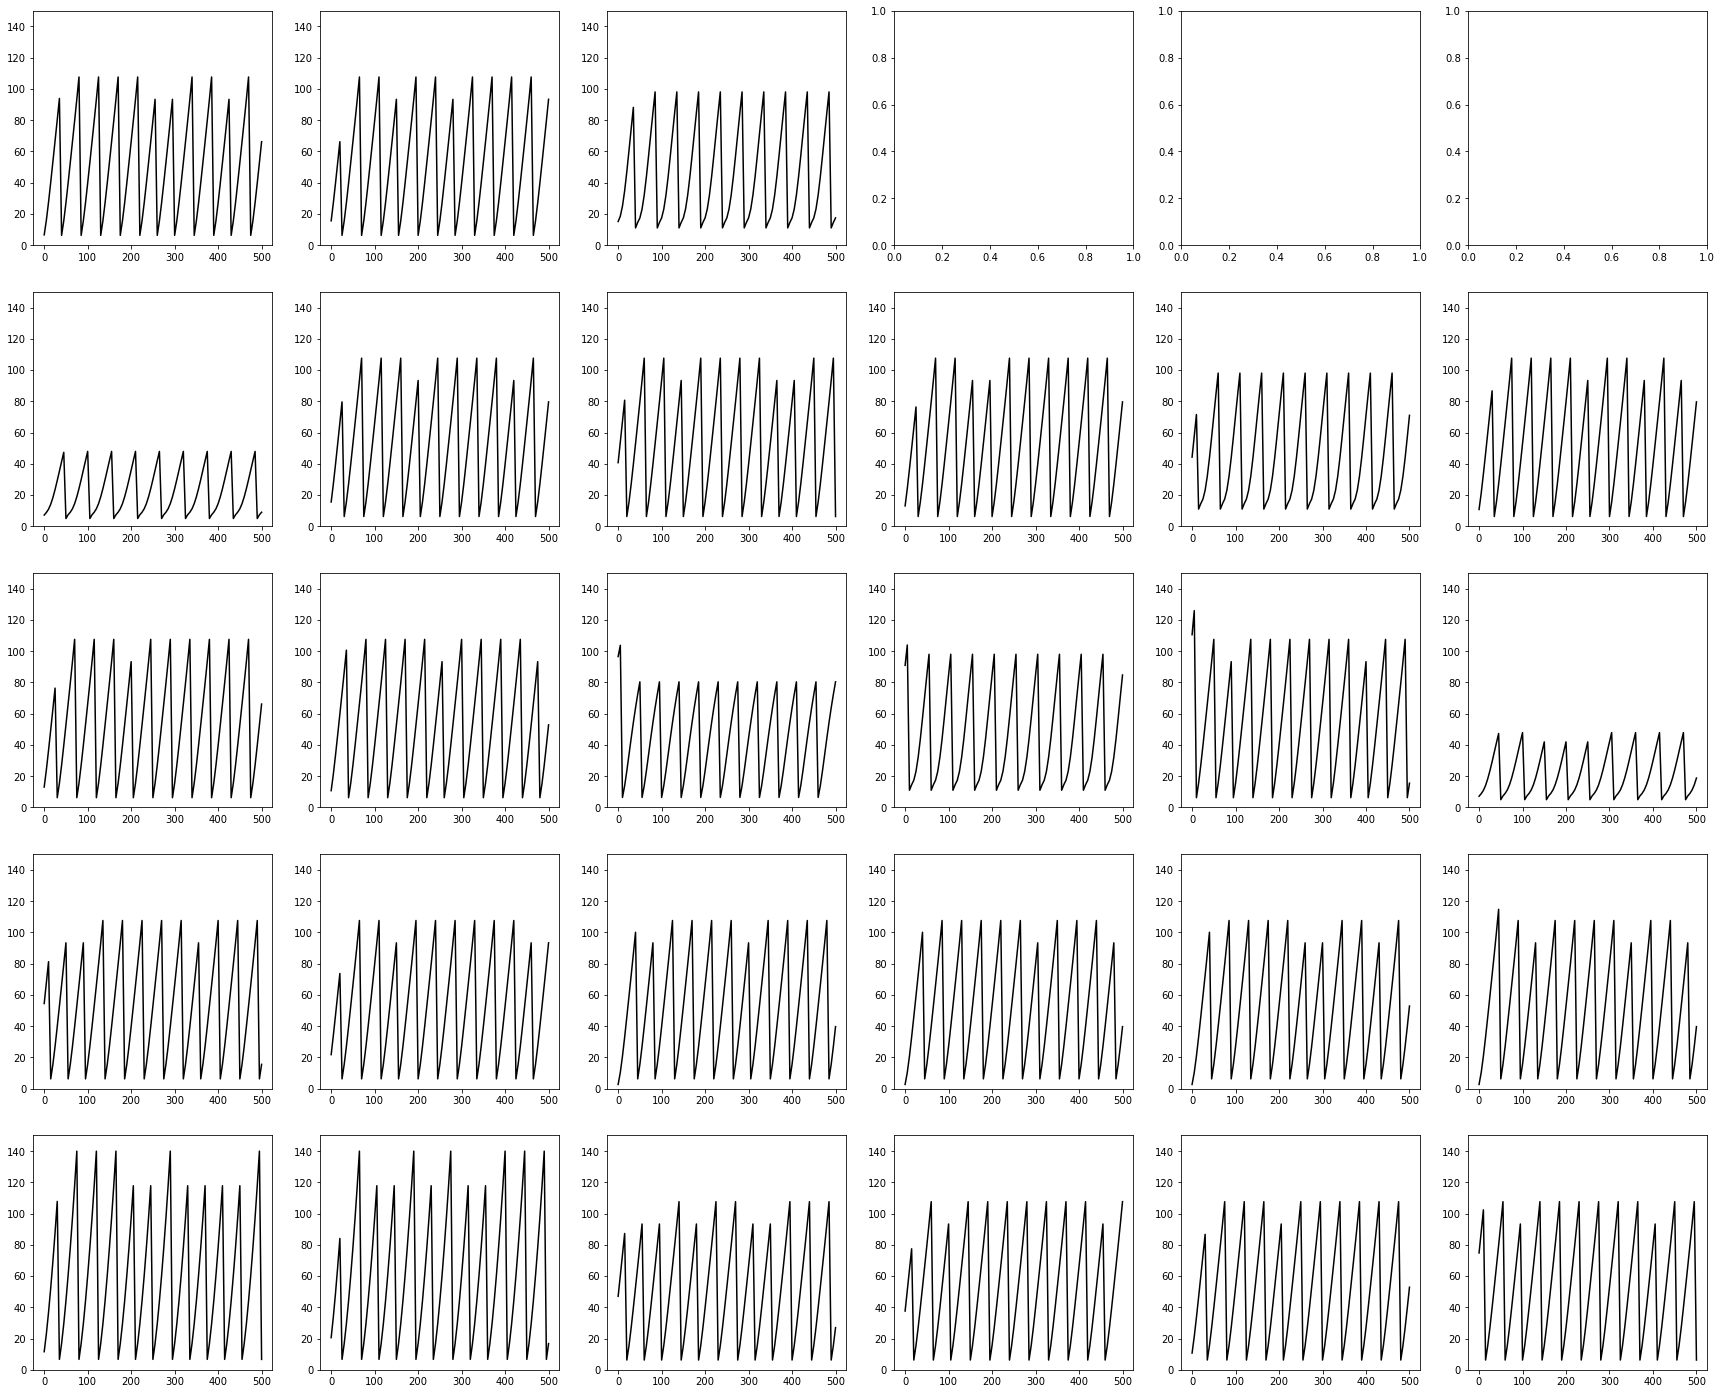

In [386]:
fig, axes = plt.subplots(5, 6, figsize=(30,25))
for key in carbon_dic.keys():
    row = key[0]
    col = key[1]
    ax = axes[5-row][col-1]
    carbon_list = carbon_dic[key]
    ax.plot(np.linspace(0,500,101), carbon_list, color='k')
    ax.set_ylim(0, 150)
plt.savefig('/Users/chengfei/Desktop/CarbonCurves_Sim.pdf')

In [373]:
clist_all = []
for i in range(len(d_list)):
    carbon = 0
    for key in carbon_dic.keys():
        carbon += carbon_dic[key][i]
    clist_all.append(carbon)

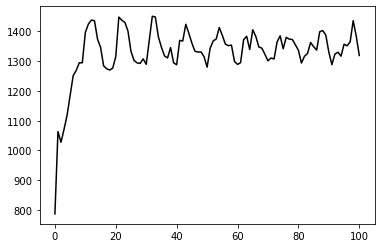

In [396]:
plt.plot(clist_all, color='k')
#plt.savefig("/Users/chengfei/Desktop/carbonAll.pdf")

In [411]:
sum(clist_all)/len(clist_all)

1329.7242334863843

In [413]:
max(clist_all)

1450.5350688045653

In [401]:
lifetimec = []
for i in range(len(d_list)):
    carbon = 0
    for key in carbon_dic.keys():
        carbon += carbon_dic[key][i]
    clist_all.append(carbon)

In [403]:
lifetimec = []
for i in range(len(trees)):
    carbon = 0
    for j in range(len(d_list)):
        lc = carbon_functions()[trees["TreeSpecies"][i]]["LifetimeC"](trees.loc[i, d_list[j]])
        carbon += lc
    lifetimec.append(lc)

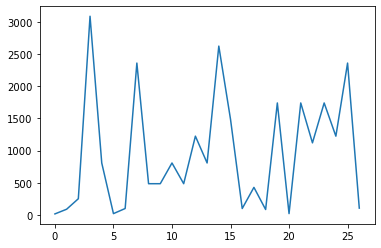

In [406]:
plt.plot(lifetimec)

In [443]:
D19 = list(trees.iloc[18,:][d_list])

In [449]:
C19 = [carbon_functions()['Spruce spp']['SeqRate'](d) for d in D19]

In [451]:
C19[:5]

[17.23463586088633,
 24.884665729150324,
 35.47406628653635,
 48.49146704862612,
 62.732556997489546]

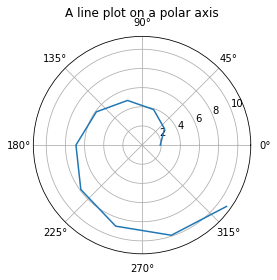

In [469]:
r = np.arange(0, 1, 0.1)
theta = 2 * np.pi * r

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, D19[:10])
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

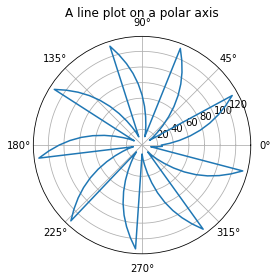

In [480]:
r = np.arange(0, 1, 0.01)
theta = 2 * np.pi * r

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, C19[1:])
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.savefig('/Users/chengfei/Desktop/CarbonRose.pdf')